# DSFB Course Project: Predicting IPO Share Price

![](https://img.etimg.com/thumb/height-480,width-640,msid-64038320,imgsize-108012/stock-market2-getty-images.jpg)

image source : https://img.etimg.com/thumb/height-480,width-640,msid-64038320,imgsize-108012/stock-market2-getty-images.jpg

## Introduction

An Initial Public Offering (IPO) is the process by which a private company becomes publicly traded on a stock exchange. The IPO company offers its shares to public investors in exchange of capital for sustaining expansion and growth. For this reason, IPOs are often issued by small or young companies, but they can also be done by large  companies looking to become publicly traded. During an IPO, the company obtains the assistance of an investment bank (underwriter), which helps determine the type, amount and price of the shares being offered. Decisions about the offering price are particularly important to avoid incurring excessive costs and maximize the capital received in the IPO. However at the end of the first trading day, price of each share can change due to market dynamics, which can lead to a price higher or lower than the offering one.

During an Initial Public Offering (IPO), the firm’s management have to disclose all relevant information about their business in a filing with the government called the "IPO Prospectus." Although there might be concerns about the public disclosure of sensitive information in the Prospectus that can help competitors, firms are encouraged to be as transparent as possible in order to avoid future litigation (lawsuits). A key textual field from the prospectus is:

__Risk_Factors__: Firms have to disclose all relevant information about internal or external risk factors that might affect future business performances. This information is contained in the “Risk Factors” section of the IPO prospectus. 

The key pricing variables are:

__Offering_Price__: the price at which a company sells its shares to investors.

__Num_Shares__: the total number of outstanding shares.

__Closing_Price__: (at the end of the first day of training) price at which shares trade in the open market, measured at the end of the first day of trading.

In this project you are provided with IPO data of different firms that are collected from different sources. You can find the dataset under project directory in the course git repository under the name of *ipo.xlsx*. The description of other variables can be found in *variable_description.xlsx*.

This Notebook will be presented as follow :

# Part 1 :
# Part 2 :
# Part 3 :
# Part 4 :

In [1]:
import pandas as pd     
import seaborn as sns
import numpy as np
import re as re
import nltk
import datetime as dt

import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from datetime import datetime, timedelta
from sklearn.base import TransformerMixin
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from nltk.corpus import stopwords 
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

/home/guillaume_grandjean77/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


In [2]:
from Plot_functions import *
from preprocessing_functions import *
from model_helpers import *


## 0.1 Import Dataset 

##### Import,  explore dataset and check missing values

In [54]:
#read dataset
DATA_FOLDER = 'data'

#Cost TIME
ipo = pd.read_csv(DATA_FOLDER+'/data_non_textual_clean.csv')
ipo_predict = pd.read_csv(DATA_FOLDER+'/data_non_textual_clean_predict.csv')
ipo_predict_predict = ipo_predict.copy()

ipo_text =  pd.read_csv(DATA_FOLDER+'/data_textual_clean.csv')
ipo_text_predict = pd.read_csv(DATA_FOLDER+'/data_textual_clean_predict.csv')

In [55]:
ipo.columns[ipo.isna().any()].tolist()

[]

In [56]:
ipo_predict.shape

(474, 3721)

In [57]:
ipo_text.shape

(3000, 503)

In [58]:
ipo_predict.head()

,Unnamed: 0,Closing_Price,Num_Shares,Offering_Price,SEC_fee,SP1,SP3,acc_fee,amd_hp,amd_pr_amt,...,8734.1,8742.1,8748.1,Class A Ord Shs,Class A Shares,Class B Shares,Common Shares,Ord/Common Shs.,Ordinary Shares,Target
0,3000,18.303713,8125000,12.0,33761.715,1367.69,1845.16,642375.7,14.0,30.0,...,0,0,0,0,0,0,1,0,0,1
1,3001,18.303713,14229999,11.0,5925.000,1410.69,1981.57,160000.0,13.0,40.0,...,0,0,0,0,0,0,0,0,1,1
2,3002,18.303713,94898000,16.0,47843.000,1372.82,1867.63,3500000.0,17.0,304.0,...,0,0,0,0,0,0,0,0,1,1
3,3003,18.303713,13426000,5.0,4939.000,1519.48,2124.29,75000.0,5.0,33.0,...,0,0,0,0,0,0,1,0,0,1
4,3004,18.303713,79990000,14.0,38085.000,1530.33,2105.20,1050000.0,19.0,270.0,...,0,0,0,0,0,0,1,0,0,1


 _________________________________________________________ 
## Part 1

Predict whether the closing price is higher than the offering price using non-text fields. By non-text fields, we mean all fields except the 'Risk_Factors'. If the price goes up from opening to closing, assign a value of 1 to a new target variable called __Price_Increase__, otherwise assign 0.

    f(non-text-fields) -> Probability of being in class 1 

For the evaluation metric, report the area under the curve (AUC) and plot an ROC graph.

We will drop closing_price since it contains futur information about the target: Price_Increase

In [59]:
ipo_predict = ipo_predict.drop(columns=ipo.columns[0])
ipo_text = ipo_text.drop(columns=ipo.columns[0])
ipo_text_predict = ipo_text_predict.drop(columns=ipo.columns[0])
ipo = ipo.drop(columns=ipo.columns[0])

In [60]:
Price_Increase = ipo['Target'] 
features = ipo.drop(['Target','Closing_Price'],axis = 1)

In [61]:
from sklearn.model_selection import train_test_split

# Separate target and features into test and training and validation sets
seed = 1
X_train, X_test, y_train, y_test = train_test_split(features, Price_Increase, test_size = 0.2, random_state = seed)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = seed)

### Dummy classifier

auc 0.4841365900117066


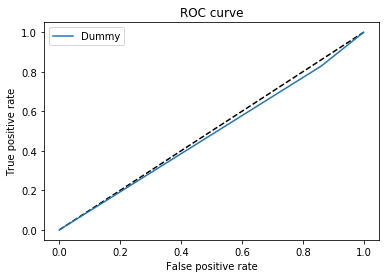

In [11]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
bbaseline_clf = DummyClassifier(strategy='stratified', random_state = seed)

# Fit the dummy classifier 
bbaseline_clf.fit(X_train,y_train)

# Predict target probabilities of belonging to positive class
y_pred = bbaseline_clf.predict_proba(X_test)

# Compute area under the curve score
baseline = roc_auc_score(y_test, y_pred[:,1])
print('auc',baseline)

plot_roc_curve_('Dummy',y_pred,y_test)

###### Not better than a random classifier

### Logistic Regression

Score  0.6126907279906347


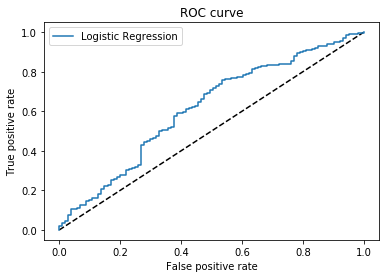

In [12]:
baseline_clf = LogisticRegression() 
baseline_clf.fit(X_train,y_train)
y_pred = baseline_clf.predict_proba(X_test)
print('Score ',roc_auc_score(y_test, y_pred[:,1]))
plot_roc_curve_('Logistic Regression',y_pred,y_test)

### Logistic regression tuning c penalty 

In [ ]:

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Standardize features and classifier in a single pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('lr_clf', LogisticRegression()))
pipeline = Pipeline(estimators)
pipeline.set_params(lr_clf__penalty='l1')

# Finding best value of C using validation set
scores = []
Cs = []
for C in np.logspace(-4, 5, 10):
    pipeline.set_params(lr_clf__C=C) 
    pipeline.fit(X_train,y_train)
    y_train_pred = pipeline.predict_proba(X_test)
    scores.append(roc_auc_score(y_test, y_train_pred[:,1]))
    Cs.append(C)

best_C = Cs[scores.index(max(scores))]
print ('best C = %d with auc score = %2.4f' %(best_C, max(scores)))

# Performance of the tuned model on test set
pipeline.set_params(lr_clf__C=best_C)
pipeline.fit(X_train,y_train)
y_pred_lr = pipeline.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred_lr[:,1])
print ('lr classifer auc with l1 regularization = %2.4f' %score)
plot_roc_curve_('l1 regularization',y_pred_lr,y_test)

### KNN tuning N neighbors

In [ ]:
# Standardize features and classifier in a single pipeline
from sklearn.neighbors import KNeighborsClassifier

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('knn_clf', KNeighborsClassifier()))
pipeline = Pipeline(estimators)

# Finding best value of K using validation set
scores = []
Ks = []
for K in [int(i) for i in np.linspace(5, 95, 10)]:
    pipeline.set_params(knn_clf__n_neighbors = K) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict_proba(X_train_val)
    scores.append(roc_auc_score(y_train_val, y_train_pred[:,1]))
    Ks.append(K)

best_K = Ks[scores.index(max(scores))]
print ('best K = %d with auc score = %2.4f' %(best_K, max(scores)))

# Performance of the tuned model on test set
pipeline.set_params(knn_clf__n_neighbors = best_K)
pipeline.fit(X_train,y_train)
y_pred_knn = pipeline.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred_knn[:,1])
print ('knn classifer auc = %2.4f' %score)
plot_roc_curve_('KNN',y_pred_knn,y_test)

### Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Define a random classifier pipeline
estimators = []
estimators.append(('rf_clf', RandomForestClassifier()))
pipeline = Pipeline(estimators)
pipeline.set_params(rf_clf__random_state = seed)
    
# Finding best value of n_estimators using validation set
scores = []
NSs = []
for NS in [int(i) for i in np.linspace(10, 100, 10)]:
    pipeline.set_params(rf_clf__n_estimators = NS) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict_proba(X_train_val)
    scores.append(roc_auc_score(y_train_val, y_train_pred[:,1]))
    NSs.append(NS)

best_NS = NSs[scores.index(max(scores))]
print ('best NS = %d with auc score = %2.4f' %(best_NS, max(scores)))

# Performance of the tuned model on test set
pipeline.set_params(rf_clf__n_estimators = best_NS)
pipeline.fit(X_train,y_train)
y_pred_rf = pipeline.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred_rf[:,1])
print ('rf classifer auc = %2.4f' %score)

best NS = 90 with auc score = 0.7588
rf classifer auc = 0.7368


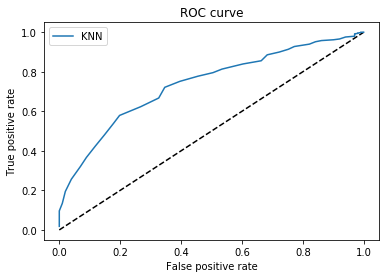

In [14]:
plot_roc_curve_('Random Forest',y_pred_rf,y_test)

###  Gradient Boosting classifier

best NS = 40 with auc score = 0.8466


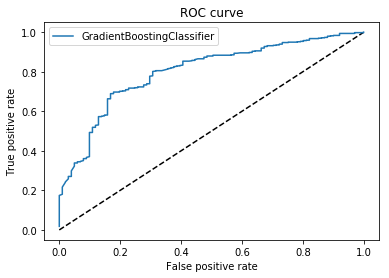

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

# Define a random classifier pipeline
estimators = []
estimators.append(('gb_clf', GradientBoostingClassifier()))
pipeline = Pipeline(estimators)
pipeline.set_params(gb_clf__random_state = seed)
    
# Finding best value of n_estimators using validation set
scores = []
NSs = []
for NS in [int(i) for i in np.linspace(10, 100, 10)]:
    pipeline.set_params(gb_clf__n_estimators = NS) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict_proba(X_train_val)
    scores.append(roc_auc_score(y_train_val, y_train_pred[:,1]))
    NSs.append(NS)

best_NS = NSs[scores.index(max(scores))]
print ('best NS = %d with auc score = %2.4f' %(best_NS, max(scores)))

# Performance of the tuned model on test set
pipeline.set_params(gb_clf__n_estimators = best_NS)
pipeline.fit(X_train,y_train)
y_pred_gb = pipeline.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred_gb[:,1])
plot_roc_curve_('Gradient Boosting Classifier',y_pred_gb,y_test)

Best classifier with NS = 40

##### Prediction

In [62]:
y_train = ipo['Target'] 
X_train = ipo.drop(['Target','Closing_Price'],axis = 1)

X_test = ipo_predict.drop(['Target','Closing_Price'],axis=1)
 
best_NS = 40    

# initialize the best model with the best parameters
best_model= GradientBoostingClassifier(n_estimators=best_NS)
best_model.fit(X_train,y_train)
ipo_predict_predict['Price_Change_Non_Textual'] = best_model.predict(X_test)

## Part 2

Predict whether the closing price is higher than the offering price using __only__ textual field 'Risk_Factors'. If the price goes up from opening to closing, assign a value of 1 to a new target variable called __Price_Increase__, otherwise assign 0.

    f(text-fields) -> Probability of being in class 1 

For the evaluation metric, report the area under the curve (AUC) and plot an ROC graph.

##### Get textual features

In [17]:
#Copy dataframe
text_features = ipo_text.copy()
text_target = Price_Increase[0:len(text_features)]

In [18]:
# Dataframe of Risk Factors :  risks_tfidf    
risks_tfidf = text_features.drop(columns = ['risks_words','risks_sentences'],axis =1)

In [19]:
seed = 0

warnings.filterwarnings('ignore')
# Define pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
def rf(features):
    estimators = []
    estimators.append(('rf_clf', RandomForestClassifier()))
    rf_pipe = Pipeline(estimators)
    rf_pipe.set_params(rf_clf__random_state = seed)

    # Fixed parameters
    score = 'roc_auc'

    # Setup possible values of parameters to optimize over
    p_grid = {"rf_clf__n_estimators": [int(i) for i in np.linspace(10.0, 50.0, 5)]}

    nested_cv(X = features, y = text_target, est_pipe = rf_pipe, p_grid = p_grid, p_score = score, n_cores = -1)

In [20]:
rf(risks_tfidf)

Average score: 0.5911 (+/- 0.0283)


In [69]:
def xgb(features):
    estimators = []
    estimators.append(('xgb_clf', XGBClassifier()))
    xgb_pipe = Pipeline(estimators)
    xgb_pipe.set_params(xgb_clf__n_jobs = -1)
    xgb_pipe.set_params(xgb_clf__random_state = seed)

    # Fixed parameters
    score = 'roc_auc'

    # Setup possible values of parameters to optimize over
    p_grid = {"xgb_clf__n_estimators": [int(i) for i in np.linspace(10, 100, 10)]}
    nested_cv(X = features, y = text_target, est_pipe = xgb_pipe, p_grid = p_grid, p_score = score, n_cores = -1)
    
    return xgb_pipe

In [22]:
xgb(risks_tfidf)

Average score: 0.6231 (+/- 0.0246)


### PCA

In [23]:
# Regroupe to 50 Fields 
from sklearn.decomposition import PCA

pca = PCA(n_components=200)

principalComponents = pca.fit_transform(risks_tfidf)
principalComponents = pd.DataFrame(principalComponents)



#Update the name of the columns
# get length of df's columns
num_cols = 200
# generate range of ints for suffixes
rng = range(0,num_cols)

new_cols = [ 'risk_'+str(i) for i in rng]

# ensure the length of the new columns list is equal to the length of df's columns
principalComponents.columns = new_cols[:num_cols]

principalComponents.head()

,risk_0,risk_1,risk_2,risk_3,risk_4,risk_5,risk_6,risk_7,risk_8,risk_9,...,risk_190,risk_191,risk_192,risk_193,risk_194,risk_195,risk_196,risk_197,risk_198,risk_199
0,-0.094937,-0.194391,0.222073,0.195715,-0.097811,0.022225,0.321670,-0.183056,-0.023520,0.078362,...,0.005079,0.013975,0.009323,-0.005504,0.001695,0.007856,0.005882,-0.019347,-0.000633,0.003402
1,-0.084956,-0.173382,0.308249,-0.141909,0.025328,0.073303,0.033944,-0.118219,0.000313,-0.018673,...,-0.003259,0.039566,-0.029224,0.003514,0.024916,-0.010298,-0.017930,0.012679,0.011881,-0.018468
2,0.569181,0.082901,0.010172,-0.031980,-0.049165,-0.003714,-0.107537,-0.019768,-0.157755,0.155390,...,-0.003471,0.000486,-0.010888,-0.026065,0.013774,-0.017394,0.004176,-0.013506,-0.003492,0.002393
3,0.566412,0.018128,0.038590,0.103180,-0.096850,-0.060072,0.080823,-0.040192,-0.084337,-0.010878,...,0.026911,0.027683,-0.001101,0.002390,-0.009279,0.014207,-0.006159,0.001733,-0.005899,-0.012857
4,0.544651,0.037491,0.006527,0.158099,-0.057665,-0.115939,0.230682,0.015801,-0.049421,0.027551,...,0.005726,-0.012532,0.009537,0.028063,-0.002012,-0.002820,-0.007189,0.020879,0.001303,-0.004923


In [24]:
rf(principalComponents)

Average score: 0.5713 (+/- 0.0119)


In [25]:
xgb(principalComponents)

Average score: 0.5906 (+/- 0.0099)


##### Predict

In [72]:
pipe = xgb(risks_tfidf)
y_train = ipo['Target'] 
X_train = text_features.drop(columns = ['risks_words','risks_sentences'],axis =1)

X_test = ipo_text_predict.drop(columns = ['risks_words','risks_sentences'],axis=1)
 
# initialize the best model with the best parameters
pipe.fit(X_train,y_train)
ipo_predict_predict['Price_Change_Textual'] = pipe.predict(X_test)

Average score: 0.6231 (+/- 0.0246)


## Part 3

Predict whether the closing price is higher than the offering price using __all__ fields. If the price goes up from opening to closing, assign a value of 1 to a new target variable called __Price_Increase__, otherwise assign 0.

    f(all-fields) -> Probability of being in class 1 
    
For the evaluation metric, report the area under the curve (AUC) and plot an ROC graph.

#### Merge all features and get train, validate and test set

In [26]:
features = ipo.drop(['Target','Closing_Price'],axis = 1)

In [27]:
for i in range(0,len(ipo_text.columns)):
    ipo_text.rename(columns={str(i): 'text_'+str(i)}, inplace='True')

all_features = pd.concat([features, ipo_text.drop(columns=['risks_sentences','risks_words'],axis = 1)], axis=1)
#Will have to remove theses line for full prediction
#all_features_small = all_features[0:2000].copy()
all_features_small = all_features.copy()
target_small = Price_Increase[0:len(all_features_small)].copy()


In [28]:
# Separate target and features into test and training and validation sets
seed = 1
#X_train, X_test, y_train, y_test = train_test_split(all_features, target, test_size = 0.2, random_state = seed)
X_train, X_test, y_train, y_test = train_test_split(all_features_small, target_small, test_size = 0.2, random_state = seed)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = seed)

###  Naive Bayes Classifier

Naive Bayes Score : 0.5335720946844184


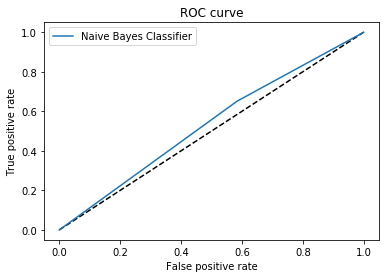

In [29]:
# Define pipeline
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
estimators = []
estimators.append(('sd',StandardScaler()))
estimators.append(('gnb_clf', GaussianNB(priors=None) ))
nb_pipe = Pipeline(estimators)

nb_pipe.fit(X_train,y_train)
y_pred_gb = nb_pipe.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred_gb[:,1])
print("Naive Bayes Score : "+str(score))
plot_roc_curve_('Naive Bayes Classifier',y_pred_gb,y_test)

### SGD Classifier

SGD Score : 0.5575705867179904


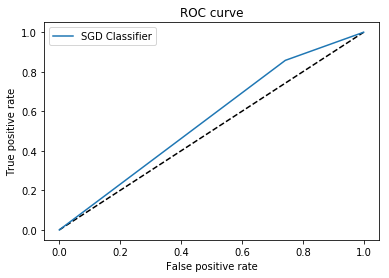

In [30]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="log", penalty="l2", max_iter=1000)

clf.fit(X_train,y_train)
y_pred_sgd = clf.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred_sgd[:,1])
print("SGD Score : "+str(score))
plot_roc_curve_('SGD Classifier',y_pred_sgd,y_test)

###  ADA Boost 

best NS = 10 with auc score = 0.7870
ADA Score : 0.785402488144606


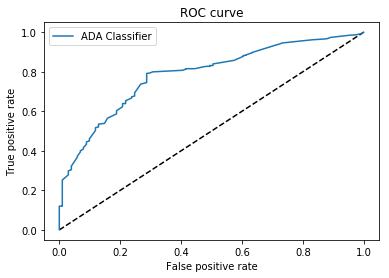

In [31]:
from sklearn.ensemble import AdaBoostClassifier

# Define pipeline
estimators = []
estimators.append(('sd',StandardScaler()))
estimators.append(('ada_clf', AdaBoostClassifier()))
ada_pipe = Pipeline(estimators)

# Fixed parameters
score = 'roc_auc'

# Finding best value of n_estimators using validation set
scores = []
NSs = []
for NS in [int(i) for i in np.linspace(10, 100, 10)]:
    ada_pipe.set_params(ada_clf__n_estimators = NS) 
    ada_pipe.fit(X_train_train,y_train_train)
    y_train_pred = ada_pipe.predict_proba(X_train_val)
    scores.append(roc_auc_score(y_train_val, y_train_pred[:,1]))
    NSs.append(NS)

best_NS = NSs[scores.index(max(scores))]
print ('best NS = %d with auc score = %2.4f' %(best_NS, max(scores)))

# Performance of the tuned model on test set
ada_pipe.set_params(ada_clf__n_estimators = best_NS)
ada_pipe.fit(X_train,y_train)
y_pred_ada = ada_pipe.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred_ada[:,1])
print("ADA Score : "+str(score))
plot_roc_curve_('ADA Classifier',y_pred_ada,y_test)

### XGB Classifier

best NS = 20 with auc score = 0.8335
Gradient Boosting Score : 0.7933490743863965


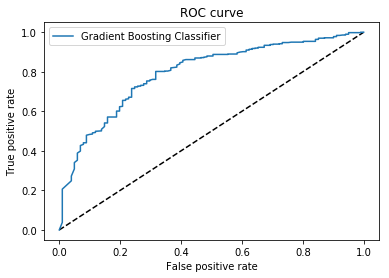

In [32]:
# Define pipeline
estimators = []
estimators.append(('xgb_clf', XGBClassifier()))
xgb_pipe = Pipeline(estimators)
xgb_pipe.set_params(xgb_clf__n_jobs = -1)
xgb_pipe.set_params(xgb_clf__random_state = seed)

# Fixed parameters
score = 'roc_auc'

# Finding best value of n_estimators using validation set
scores = []
NSs = []
for NS in [int(i) for i in np.linspace(10, 100, 10)]:
    xgb_pipe.set_params(xgb_clf__n_estimators = NS) 
    xgb_pipe.fit(X_train_train,y_train_train)
    y_train_pred = xgb_pipe.predict_proba(X_train_val)
    scores.append(roc_auc_score(y_train_val, y_train_pred[:,1]))
    NSs.append(NS)

best_NS = NSs[scores.index(max(scores))]
print ('best NS = %d with auc score = %2.4f' %(best_NS, max(scores)))

# Performance of the tuned model on test set
xgb_pipe.set_params(xgb_clf__n_estimators = best_NS)
xgb_pipe.fit(X_train,y_train)
y_pred_gb = xgb_pipe.predict_proba(X_test)
score = roc_auc_score(y_test, y_pred_gb[:,1])
print("Gradient Boosting Score : "+str(score))
plot_roc_curve_('Gradient Boosting Classifier',y_pred_gb,y_test)

Best NS = 20, Best Model with Auc Score = 0.79335

### Network models

In [33]:
# Build neural network model
def create_model_1():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=all_features.shape[1], activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
def create_model_2():
    # create model
    model = Sequential()
    model.add(Dense(64, input_dim=all_features.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_model_3():
    # create model
    model = Sequential()
    model.add(Dense(1000, input_dim=all_features.shape[1], activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [34]:
warnings.filterwarnings('ignore')

model = create_model_1()

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('nn_clf', KerasClassifier(build_fn=create_model_1)))
nn_pipe = Pipeline(estimators)
nn_pipe.set_params(nn_clf__epochs = 5)
nn_pipe.set_params(nn_clf__batch_size = 20)
nn_pipe.set_params(nn_clf__verbose = 2)

# Setup possible values of parameters to optimize over
p_grid = {}

# Fixed parameters
score = 'roc_auc'
# Get predicted values
nested_cv(X = all_features, y = text_target, est_pipe = nn_pipe, p_grid = p_grid, p_score = score, n_cores = -1)


Epoch 1/5
Epoch 1/5
Epoch 1/5
 - 2s - loss: 1.1291 - acc: 0.4614
Epoch 2/5
 - 3s - loss: 1.1582 - acc: 0.4539
Epoch 2/5
 - 1s - loss: 0.5577 - acc: 0.7412
Epoch 3/5
 - 3s - loss: 1.1175 - acc: 0.4614
Epoch 2/5
 - 1s - loss: 0.5514 - acc: 0.7434
Epoch 3/5
 - 1s - loss: 0.3901 - acc: 0.8530
Epoch 4/5
 - 1s - loss: 0.5341 - acc: 0.7509
Epoch 3/5
 - 1s - loss: 0.2962 - acc: 0.9010
 - 1s - loss: 0.3437 - acc: 0.8605
Epoch 5/5
Epoch 4/5
 - 1s - loss: 0.3653 - acc: 0.8575
Epoch 4/5
 - 1s - loss: 0.2513 - acc: 0.9077
Epoch 5/5
 - 1s - loss: 0.2324 - acc: 0.9220
 - 1s - loss: 0.2778 - acc: 0.9047
Epoch 5/5
 - 1s - loss: 0.1885 - acc: 0.9310
 - 1s - loss: 0.2167 - acc: 0.9280
Epoch 1/5
Epoch 1/5
Epoch 1/5
 - 2s - loss: 2.1971 - acc: 0.2003
Epoch 2/5
 - 2s - loss: 2.1457 - acc: 0.2018
Epoch 2/5
 - 1s - loss: 1.2206 - acc: 0.4921
Epoch 3/5
 - 3s - loss: 2.2153 - acc: 0.2011
Epoch 2/5
 - 1s - loss: 1.2182 - acc: 0.4554
Epoch 3/5
 - 1s - loss: 0.7945 - acc: 0.7629
Epoch 4/5
 - 1s - loss: 1.2187 - ac

Epoch 1/10
 - 2s - loss: 0.5452 - acc: 0.7350
Epoch 2/10
 - 1s - loss: 0.3618 - acc: 0.8412
Epoch 3/10
 - 1s - loss: 0.2770 - acc: 0.8621
Epoch 4/10
 - 1s - loss: 0.1985 - acc: 0.9008
Epoch 5/10
 - 1s - loss: 0.1361 - acc: 0.9450
Epoch 6/10
 - 1s - loss: 0.0854 - acc: 0.9721
Epoch 7/10
 - 1s - loss: 0.0480 - acc: 0.9867
Epoch 8/10
 - 1s - loss: 0.0399 - acc: 0.9863
Epoch 9/10
 - 1s - loss: 0.0270 - acc: 0.9917
Epoch 10/10
 - 1s - loss: 0.0171 - acc: 0.9942
Score for NN2 : 0.6449929562094485


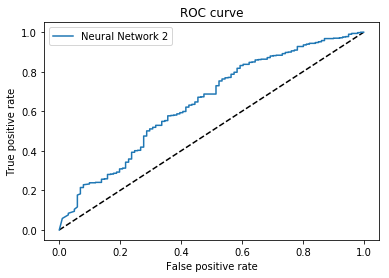

In [35]:
warnings.filterwarnings('ignore')

model = create_model_2()

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('nn_clf', KerasClassifier(build_fn=create_model_2)))
nn_pipe = Pipeline(estimators)
nn_pipe.set_params(nn_clf__epochs = 10)
nn_pipe.set_params(nn_clf__batch_size = 50)
nn_pipe.set_params(nn_clf__verbose = 2)

# Setup possible values of parameters to optimize over
p_grid = {}

# Fixed parameters
score = 'roc_auc'

# Train and evaluate model
#Train the pipe
nn_pipe.fit(X_train, y_train )
# Get predicted values
nn2_predict = nn_pipe.predict_proba(X_test)
score = roc_auc_score(y_test, nn2_predict[:,1])
print("Score for NN2 : "+str(score))
plot_roc_curve_('Neural Network 2',nn2_predict,y_test)

Epoch 1/10
 - 2s - loss: 0.5075 - acc: 0.8171
Epoch 2/10
 - 1s - loss: 0.2153 - acc: 0.9208
Epoch 3/10
 - 1s - loss: 0.1169 - acc: 0.9517
Epoch 4/10
 - 1s - loss: 0.0624 - acc: 0.9871
Epoch 5/10
 - 1s - loss: 0.0353 - acc: 0.9925
Epoch 6/10
 - 1s - loss: 0.0198 - acc: 0.9983
Epoch 7/10
 - 1s - loss: 0.0129 - acc: 0.9983
Epoch 8/10
 - 1s - loss: 0.0076 - acc: 0.9988
Epoch 9/10
 - 1s - loss: 0.0049 - acc: 1.0000
Epoch 10/10
 - 1s - loss: 0.0035 - acc: 1.0000
Score for NN 3 : 0.6440703188555329


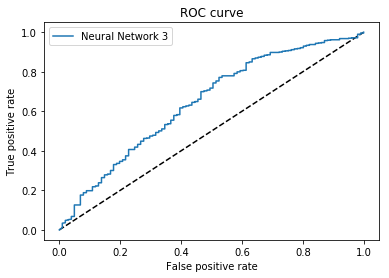

In [36]:
warnings.filterwarnings('ignore')

model = create_model_3()

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('nn_clf', KerasClassifier(build_fn=create_model_3)))
nn_pipe = Pipeline(estimators)
nn_pipe.set_params(nn_clf__epochs = 10)
nn_pipe.set_params(nn_clf__batch_size = 500)
nn_pipe.set_params(nn_clf__verbose = 2)

# Setup possible values of parameters to optimize over
p_grid = {}

# Fixed parameters
score = 'roc_auc'

#Train the pipe
nn_pipe.fit(X_train, y_train )
# Get predicted values
nn3_predict = nn_pipe.predict_proba(X_test)
score = roc_auc_score(y_test, nn3_predict[:,1])
print("Score for NN 3 : "+str(score))
plot_roc_curve_('Neural Network 3',nn3_predict,y_test)

In [37]:
y_pred_ensemble = np.mean( np.array([ y_pred_gb[:,1],y_pred_ada[:,1]]), axis=0 )


score = roc_auc_score(y_test, y_pred_ensemble)
print("Ensemble Score : "+str(score))

Ensemble Score : 0.796176511438719


##### Prediction

In [77]:
y_train = ipo['Target']
X_train = pd.concat([ipo.drop('Closing_Price',axis=1),ipo_text.drop(columns=['risks_words','risks_sentences'],axis=1)], axis=1)
X_test = ipo_predict.drop(['Target','Closing_Price'],axis=1)

best_NS = 20

# initialize the best model with the best parameters
best_model= XGBClassifier(n_estimators=best_NS)
best_model.fit(X_train,y_train)
ipo_predict_predict['Price_Change_All'] = best_model.predict(X_test)

ValueError: feature_names mismatch: ['Num_Shares', 'Offering_Price', 'SEC_fee', 'SP1', 'SP3', 'acc_fee', 'amd_hp', 'amd_pr_amt', 'amd_pr_shs_pct', 'amd_pr_shst_tot', 'amd_shst_tot', 'amt_filed', 'avg_firm_amt_vexp', 'avg_round_vexp', 'bluesky', 'book_proceeds', 'bvps', 'comm_eq', 'comm_eq_bef', 'date_found', 'days_in_registr', 'deal_size', 'exp_incl_gross', 'exp_pctofproceeds', 'free_float', 'gross_spread', 'gross_spread_allmkt', 'ipo_yr_ritt', 'lastamd_tot', 'legal_exp', 'lockup_days', 'mgt_fee', 'misc_exp', 'mkt_cap', 'mktval_aft', 'mktval_bef', 'nasdaq_avg_1', 'num_amd', 'num_bokr', 'num_emp', 'num_emp_date', 'num_firms_vexp', 'num_lead_mgr', 'num_mgrs', 'num_rounds_vexp', 'pct_ins_shs_aft', 'pct_ins_shs_bef', 'pctchg_amd_amt', 'pctchg_dj_1', 'pctchg_dj_2', 'pctchg_hp', 'pctchg_lp', 'pctchg_mp', 'pctchg_nasdaq_1', 'pctchg_nasdaq_2', 'pctchg_p', 'pctchg_sp_1', 'pctchg_sp_2', 'pctchg_sp_3', 'price_range', 'prim_shs_1', 'prim_shs_2', 'print_exp', 'reall_fee', 'round_tot', 'shs_ourst_aft_prosp', 'shs_out_bef', 'tang_ce_1', 'tang_ce_2', 'tor_ovt', 'tot ass_before', 'tot_ass_after', 'tot_mgtfee', 'tot_proceeds', 'underw_fee', 'lockup_last_duration', 'rate', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'dow_sin', 'dow_cos', 'time_amd', 'Agriculture, Forestry and Fishing', 'Finance, Insurance and Real Estate', 'Mining', 'Public Administration', 'Retail Trade', 'Transportation, Communications, Electric, Gas and Sanitary service', 'Wholesale Trade', 'BOOK RUNNER', 'CO MANAGER', 'GLOBAL COORDINATOR', 'JOINT LEAD MANAGER', 'SYNDICATE MEMBER', 'ABN AMRO Bank', 'ABN AMRO Bank NV', 'ABN AMRO Chicago Corp', 'ABN AMRO Financial Services', 'ABN AMRO Incorporated', 'ABN AMRO Rothschild', 'ABN AMRO Securities', 'ABN AMRO Securities (USA) Inc', 'AG Edwards Inc', 'AGC Partners', 'AGM Partners LLC', 'Academy Securities Inc', 'Access Financial Group', 'Access Securities', 'Access Sp zoo', 'Adams', 'Advanced Equities Inc', 'Advent International Corp', 'Aegis Capital', 'Alden', 'Allen & Company of Florida', 'Allen C. Ewing', 'Alpha Finance AE', 'Alta Capital Group LLC', 'American Financial Group Inc', 'American Fronteer Financial', 'Ameritrade Inc', 'Andrew, Alexander, Wise', 'Anglo-American Investor', 'Aon Benfield', 'Apex Securities Inc (UK)', 'Apollo Global Management, LLC', 'Arcadia Partners LP', 'Ardour Capital Investments LLC', 'Arneson Kercheville', 'Arnhold and S Bleichroeder Inc', 'Arnold Bleichroeder Company', 'Auerbach Pollak & Richardson', 'Avalon Research', 'Avondale Partners', 'Axia Ventures Group', 'Axiom Partners', 'B Riley & Company', 'BBVA', 'BBVA Securities', 'BC Ziegler & Co', 'BMO Nesbitt Burns Inc', 'BMO Nesbitt Thomson Ltd', 'BNY Capital Markets Inc', 'BNY Mellon Shareowner Services', 'BOCI Asia', 'BOSC, INC', 'BT Securities Corp', 'BTIG LLC', 'Baird Patrick & Co Inc', 'Baldwin & Associates Inc', 'Banc One Capital Corp', 'Banc of America Secs Ltd', 'BancAmerica Robertson Stephens', 'BancAmerica Securities Inc', 'BancBoston Robertson Stephens', 'Banca IMI', 'Banca IMI (Intesa Sanpaolo)', 'Banco BTG Pactual SA', 'Banco Continental SA (Ecuador)', 'Banco Itau SA', 'Banco Santander de Negocios SA', 'Banco do Brasil SA', 'Bank J Vontobel & Co AG', 'Bank am Bellevue', 'Bank of Bermuda Ltd', 'Bank of New York', 'Bank of New York Mellon Corp', "Banque Europeenne l'Amer Lat", 'Banque Nationale de Paris{BNP}', 'Barber & Bronson Inc.', 'Barclay Investments, Inc.', 'Barclays Capital Group', 'Barclays Capital Sec Ltd', 'Barington Capital Group LP', 'Barrington Associates', 'Barrington Research Inc.', 'Bayerische Landesbank Giro', 'Bear Stearns International', 'Berry-Shino Securities Inc', 'Berthel Fisher & Co Financial', 'Biltmore Securities', 'Bishop, Rosen & Co', 'Blackford Securities', 'Blackstone Advisory Partners', 'Blackstone Capital Partners LP', 'Blair House', 'Blaylock & Co Inc', 'Blaylock & Partners LP', 'Blaylock Beal Van LLC', 'Blaylock Robert Van', 'Boenning & Scattergood', 'Boston Group', 'Brad Peery Inc', 'Bradesco BBI', 'Branch & Co.', 'Branch Banking & Trust Co', 'Branch, Cabell and Company', 'Brean Murray & Co Inc', 'Brean Murray Carret & Co LLC', 'Brean Murray Foster Securities', 'Brenner Securities', 'Broadband Capital Management', 'Broadmark Capital Corp', 'Brookstreet Securities', 'Buckingham Research Group', 'Buckingham Securities', 'Builder Advisor Group LLC', 'Butler, Wick & Co.', 'C&Co/PrinceRidge LLC', 'CAPITAL MANAGEMENT GROUP', 'CF Global Trading LLC', 'CIBC Wood Gundy Capital', 'CIBC Wood Gundy Securities', 'CIMB Group Sdn Bhd', 'CJS Securities Inc', 'CMG Institutional Trading LLC', 'CRCA PCA', 'CRT Capital Group LLC', 'Cabrera Capital Markets Inc', 'Calyon', 'Calyon Financial', 'Calyon Securities USA Inc', 'Canaccord Adams', 'Canaccord Capital Corp', 'Canadian Imperial Bk Commerce', 'Cantor Fitzgerald & Co', 'Cantor, Weiss & Friedner, Inc.', 'Capital Growth Financial LLC', 'Capital One Bank', 'Capital One Equities', 'Capital One Financial Corp', 'Capital One Southcoast Inc', 'Cardinal Capital Management', 'Caris & Company', 'Carroll & Koster NV', 'CastleOak Securities LP', 'Cazenove & Co', 'Cazenove Inc', 'Centex Securities Inc', 'Chapin, Davis', 'Charles Schwab & Co Inc', 'Chase Manhattan Bank NA', 'Chatfield Dean', 'Chatsworth Securities LLC', 'Chemical Securities Inc', 'Chicago Capital Inc.', 'Chicago Corp', 'Chicago Investment Group LLC', 'China International Capital Co', 'Citicorp Securities Inc', 'City National Bank of NJ', 'City Securities', 'Cleary', 'Cleary Gull Reiland & McDevitt', 'Cleary Gull Reiland McDevitt', 'Coburn & Meredith, Inc', 'Cochran Caronia Waller', 'Cochran, Caronia & Co.', 'Code Advisors', 'Cohen & Steers Capital Advisor', 'Cohen Bros & Co', 'Cohig & Associates', 'Coker & Palmer', 'Collins Stewart Ltd', 'Columbia Group Inc', 'Comerica Securities', 'Commerz Markets LLC', 'Commerzbank AG', 'Commerzbank Capital Markets', 'Commonwealth Securities, Utah', 'Compass Point Research & Tradi', 'Comvest Partners', 'Concept Capital Markets LLC', 'Conning & Co', 'Continental Broker-Dealer Corp', 'Cooperative Centrale Raiffeise', 'Core Pacific-Yamaichi (HK)', 'Corinthian Partners, LLC', 'Cormark Securities Inc', 'Corporate Securities Group, In', 'Cowen', 'Cowen Securities LLC', 'Craigie', 'Credit Agricole CIB', 'Credit Agricole Indosuez', 'Credit Agricole Sec Asia BV', 'Credit Lyonnais SA', 'Credit Lyonnais Secs (London)', 'Credit Lyonnais Securities USA', 'Credit Research & Trading', 'Credit Suisse First Boston', 'Credit Suisse First Boston Int', 'Credit Suisse Securities (USA)', 'Crowell Weedon & Co', 'Cruttenden & Co. Inc.', 'Culverwell', 'D. H. Blair', 'D. H. Blair Investment Banking', 'DBS Bank Ltd', 'DLJdirect', 'DM Kelly & Co', 'DVB BANK AG', 'Dain, Kalman & Quail', 'Daiwa Capital Markets America', 'Daiwa Securities SMBC Europe', 'Dakin Securities Corp.', 'Danske Bank', 'Davenport', 'David A. Noyes', 'De La Rosa & Co', 'DeMatteo Monness LLC', 'Dean Witter', 'Delafield Hambrecht Inc', 'Deutsche Bank Capital Corp', 'Deutsche Bank Securities', 'Deutsche Bank Securities Corp', 'DnB Markets AS', 'DnB NOR BANK ASA', 'Doft & Co Inc', 'Doley Securities', 'Dominion Securities Harris', 'Donald & Co. Securities', 'Donaldson Lufkin & Jenrette', 'Donaldson Lufkin Jenrette Intl', 'Dougherty & Company LLC', 'Dougherty Summit Securities', 'Dowling & Partners Securities', 'Drake & Co', 'Dresdner Bank AG', 'Dresdner Kleinwort Benson', 'Dresdner Kleinwort Wasserstein', 'Drexel Hamilton LLC', 'Duncan-Williams Inc', 'E*Trade Securities Inc', 'EA Markets Securities LLC', 'EM Securities LLC', 'Earlybirdcapital Inc', 'Edgar M. Norris & Co', 'Edward D Jones & Co', 'Edward D Jones & Co LP', 'Emerging Equities Inc', 'Emerging Growth Equities Ltd', 'Empire', 'Epoch Capital Corp', 'Epoch Partners', 'EquiServe Trust Co', 'Equitable Securities, New York', 'Equity Securities Trading', 'Essex', 'FAC/Equities', 'FBD Investment Services, Inc.', 'Farrell', 'Fearnley Fonds A/S', 'Fechtor, Detwiler', 'Ferris & Company', 'Ferris Baker Watts', 'Fidelity Bank', 'Fidelity Investments Inc', 'Fifth Third Bank', 'Fifth Third Securities Inc', 'Fifth Third/Ohio Co', 'Fig Partners LLC', 'Financial West Group', 'First Albany', 'First Allied Securities, Inc.', 'First Analysis Securities', 'First Chicago Capital Markets', 'First Colonial Securities Grp', 'First Dallas Securities Inc', 'First Interstate Securities', 'First Liberty Investment Group', 'First Liberty National Bank', 'First Manhattan Co', 'First Montauk Securities', 'First Securities Corp. of NC', 'First Security Investments', 'First Security Van Kasper & Co', 'First Southwest', 'First Union Capital Markets', 'First Union National Bancorp', 'First Union Securities Inc', 'First Washington Securities', 'First of Michigan Corp', 'Fleet Boston Corp', 'FleetBoston Robertson Stephens', 'Florida Atlantic Stock', 'Fortis Bank Nederland NV', 'Fortis Securities Inc', 'Forum Capital Markets LP', 'Fox-Pitt Kelton', 'Fox-Pitt Kelton SA', 'Freeman & Co', 'Friedman Billings Ramsey & Co', 'Friedman Manger', 'Frost Securities', 'Fulcrum Global Partners', 'Fulcrum II L.P.', 'Furman & Co', 'Furman Selz Inc', 'Furman Selz Mager Dietz Birney', 'GMP Securities Ltd.', 'GRW Capital', 'GS Squared Securities', 'GS2 Securities Inc.', 'Gabelli & Co Inc', 'Gaines, Berland', 'Gardner Rich & Co', 'Genesis Merchant Group Secs', 'George K Baum & Co', 'Gerard Klauer Mattison & Co', 'Gilford Securities', 'Glaser Capital Corp', 'Gleacher & Co', 'Gleacher & Co Securities Inc', 'Global Hunter Securities LLC', 'Goldis Financial Group, Inc.', 'Goldsmith & Harris', 'Goldsmith, Agio & Co.', 'Gordon Haskett Capital Corp', 'Great Pacific Capital SA', 'Griffin Securities Inc', 'Griffiths McBurney Corp', 'Guggenheim Partners LLC', 'Gunn & Company', 'GunnAllen Financial Inc', 'Guzman & Co', 'H. D. Brous', 'H. G. Wellington & Co, Inc.', 'H.J. Meyers', 'HARRISdirect LLC', 'HCFP Brenner Securities LLC', 'HFF Securities LP', 'HSBC Bank USA', 'HSBC Holdings PLC', 'HSBC Securities Australia', 'HVB Capital', 'Hagerty, Stewart & Associates', 'Hallidays LLP', 'Hambrecht & Quist', 'Hamilton Robinson', 'Hanifen Imhoff & Samford', 'Hanifen Imhoff Inc', 'Harris Nesbitt', 'Harris Nesbitt Thomson Secs', 'Harris Webb & Garrison Inc', 'Hazlett, Burt & Watson', 'Hefren-Tillotson, Inc.', 'Heidtke & Co., Inc.', 'Henry Schroder', 'Herzog, Heine, Geduld, Inc.', 'Hibernia Southcoast Capital', 'Hill Thompson Group Ltd', 'Hilliard Lyons Inc', 'Hoak Securities Corp', 'Hobbs Melville Securities', 'Hongkong & Shanghai Bank (HK)', 'Hopper Soliday', 'Hornblower & Weeks Hemphill No', 'Hornblower, Weeks, Noyes & Tra', 'Hovde Financial, Inc.', 'Hovde Securities LLC', 'Howard Weil Financial Corp', 'Howard Weil Labouisse Freid', 'Howe Barnes Hoefer Arnett Inc', 'Huberman, Margaretten & Straus', 'Hudson Knight Securities, Inc.', 'Hudson Securities Pty Ltd', 'Huntington Capital Corp', 'Huntington Investment Company', 'Huntleigh Securities Corp', 'ING', 'ING Bank NV', 'ING FINANCIAL MARKETS LLC', 'ISG Capital Markets', 'Imperial Capital Corp.', 'Inverned Associates', 'Investec Ernst & Co- Investec', 'Investec Ernst & Company', 'Investec PMG Capital Corp', 'Investors Capital Corp', 'Israel Discount Bank of NY', 'Itau BBA USA Securities Inc', 'Itau USA Securities Inc', 'J Henry Schroder & Co Ltd', 'J. E. Sheehan', 'J.W. Barclay', 'JJB Hilliard WL Lyons Inc', 'JP Morgan', 'JP Morgan Securities Ltd', 'JW Charles Securities Inc', 'JW Genesis Capital Markets', 'Jackson Securities Inc', 'Janco Partners', 'Janssen-Meyers Associates', 'Jefferies Broadview', 'Jefferies Quarterdeck LLC', 'Jeffries Industries Ltd', 'Jensen Securities', 'Jesup & Lamont Securities', 'John Burnham & Co', 'John Edward', 'John J. Ryan', 'Johnston Associates', 'Johnston Lemon & Co Inc', 'Joseph Charles & Associates', 'Joseph Stevens & Company', 'Josephthal & Co Inc', 'KBC Securities', 'KSH Investment Group, Inc.', 'Kashner Davidson Securities', 'Kaufman Brothers LP', 'Keane Securities', 'Keeley Investment Corp', 'Kelton International', 'Kenny Securities Corp', 'Keystone National Bank', 'King & Shaxson Holdings', 'Kirkpatrick, Pettis, Smith, Po', 'Kleinwort Benson Inv Mngt', 'Knight Capital Group Inc', 'Koonce Securities', 'L.H. Friend', 'L.H. Friend Weinress &Frankson', 'LH Friend, Weinress, Frankson', 'LOYAL3 Securities Inc', 'LT Lawrence & Co Inc', 'LUMA Partners LLC', 'La Jolla Securities', 'La Salle National Bank Ltd', 'LaSalle Bank NA', 'LaSalle Capital', 'LaSalle Capital Markets', 'LaSalle National Bank,IL', 'LaSalle Street Securities Inc', 'Lafayette Investment Co', 'Laidlaw Global Securities', 'Laidlaw-Coggeshall', 'Lazard', 'Lazard Freres et Cie', 'Lazard Houses', 'Lebenthal', 'Legend Merchant Group Inc', 'Legg', 'Legg Mason Wood Walker', 'Libra Investments', 'Life Science Group Inc', 'Lintz Glover White & Co', 'LionTree Advisors LLC', 'Liquidnet Inc', 'Loeb Partners', 'Loewenbaum & Company Inc', 'Loewenbaum & Company Inc.', 'Lombard Odier Intl Underwriter', 'Loop Capital Markets', 'Loyal Strategy Co Ltd', 'M. H. Meyerson', 'MCS Capital Markets LLC', 'MJ Whitman Inc', 'MLV & Co', 'MR Beal & Co', 'Macquarie Capital Group Ltd', 'Macquarie Equity Capital Mkts', 'Madison Securities', 'Madison Williams & Co', 'Marion Bass Securities', 'Maxwell Capital', 'McAdams Wright Ragen Inc', 'McDonald & Co Investments Inc', 'McDonald & Company', 'McDonald Investments', 'McGinn, Smith & Co Inc', 'Mediobanca', 'MeesPierson NV', 'Mellon Financial Services Inc', 'Melvin & Company', 'Melvin Securities Corporation', 'Merit Capital Associates, Inc', 'Merrill Lynch', 'Merrill Lynch, Pierce, Fenner', 'Merriman Capital Inc', 'Mesirow', 'Mesirow Financial Corp', 'Midland Walwyn Inc', 'Midwest Research Maxus Group', 'Millenium Securities Corp', 'Millennium Financial Group', 'Miller Johnson Steichen Kinnar', 'Miller Tabak Hirsch', 'Miller, Johnson & Kuehn, Inc.', 'Mischler Financial Group Inc', 'Mitchell Securities Corp', 'Mitsubishi Securities(USA)Inc', 'Mitsubishi UFJ Sec Intl Plc', 'Mitsubishi UFJ Securities USA', 'Mizuho Intl PLC', 'Mizuho Securities Co Ltd', 'Monarch Capital Group LLC', 'Monness Crespi Hardt', 'Monroe Parker Securities', 'Monroe Securities Inc', 'Montgomery & Co', 'Montgomery Ward & Co Inc', 'Montrose Capital', 'Moors & Cabot Group', 'Moors & Cabot Inc', 'Morgan Fuller Capital', 'Morgan Joseph TriArtisan LLC', 'Morgan Stanley Dean Witter', 'Morgan Stanley International', 'Muriel Siebert & Co', 'NA Jensen & Co AS', 'NatCity Capital Markets', 'NatCity Investments Corp', 'NatWest Securities', 'Natcity Investments Inc.', 'Natexis Bleichroeder Inc', 'Natexis SA', 'National Bank Financial Inc', 'National City Investments', 'National Financial Mkts Grp', 'National Securities Corp (TW)', 'NationsBanc Capital Markets', 'NationsBanc Montgomery Sec', 'Natixis', 'Natixis Securities NA', 'Nesbitt Burns Corp', 'Nesbitt Burns Inc', 'Nesbitt Burns Securities', 'Nesbitt Thomson Securities NY', 'Nessuah Zannex, Ltd.', 'Network 1 Financial Securities', 'Neuberger Berman Inc', 'Nichols, Safina, Lerner & Co', 'Nikko Securities (New York)', 'Nikko Securities Co Intl', 'Noble Financial Capital Market', 'Noble International Investment', 'Noble Investment Co', 'Nomura International PLC', 'Nomura Secs Intl', 'Nomura Securities', 'Nomura Securities New York Inc', 'Nordberg Capital Inc', 'Nordea Markets', 'Northeast Securities Inc.', 'Northland Capital Markets', 'Nuveen Investments LLC', 'Oriental Financial Services', 'Ormes Capital Markets Inc', 'Orrues Capital Markets Inc', 'Oscar Ltd', 'PMG Capital', 'PNC Securities Corp', 'Pacific Securities Co Ltd', 'Paine, Webber, Jackson, Curtis', 'PaineWebber', 'PaineWebber International', 'Pali Capital LLC', 'Paradise Valley Securities Inc', 'Paragon Capital', 'Pareto Securities', 'Paribas Corporation', 'Parker Jackson', 'Pauli Johnson Capital & Resch', 'Peacock Hislop Staley & Given', 'Peninsula Merchant Group, Ltd', 'Pennsylvania Co Inc', 'Pennsylvania Merchant Group', 'Peregrine Capital Ltd', 'Peters & Co Ltd', 'Petrie Parkman & Co Inc', 'Pickering Energy Partners Inc', 'Piper Jaffray', 'Piper Jaffray & Hopwood Inc', 'Popular Securities Inc', 'Poten Capital Services LLC', 'Preferred Capital Markets', 'PrinceRidge Group LLC', 'Principal Financial Securities', 'Pritchard & Partners Pty Ltd', 'Pritchard Capital Partners LLC', 'Prudential Securities Group', 'Prudential Volpe Technology Gr', 'Pryor Govan Counts & Co Inc', 'Pryor McClendon Counts & Co', 'Punk Ziegel & Knoell', 'Putnam Lovell Group Inc', 'Putnam Lovell NBF Securities', 'Putnam Lovell Securities', 'Putnam, Coffin, Doolittle, New', 'Putnam, Lovell , de Guardiola', 'Quarterdeck Investment Partner', 'Quick & Reilly Group, Inc.', 'R. F. Lafferty', 'R. J. Steichen', 'R. M. Stark & Co', 'R.H. Investments, Inc.', 'RAF Financial', 'RAS Securities Corporation', 'RBC Dain Rauscher Corp', 'RBC Dominion Securities', 'RBC Dominion Securities Corp', 'RBS', 'RCS Capital Corp', 'RS Platou Markets AS', 'Rabo Securities NV', 'Rabobank NV', 'Ragen MacKenzie Group Inc', 'Raine Securities LLC', 'Rauscher Pierce Securities', 'Raymond James Ltd', 'Realty Capital International', 'Redstone Securities', 'Redwine & Company Inc', 'Regions Securities LLC', 'Renaissance Capital Partners', 'Richter, Cohen', 'Rickel & Associates', 'Robb Peck & McCoey', 'Robert J. Harris', 'Robertson, Colman & Stephens', 'Robotti & Eng, Inc.', 'Roney & Co', 'Roney Capital Markets', 'Rosenblatt', 'Rothschild Inc.', 'Royal Bank of Canada', 'RvR Securities Corp', 'Ryan, Hartley & Lee, Inc.', 'S W Bach & Company', 'S. C. Parker', 'SBC Warburg', 'SBC Warburg Dillon Read Inc', 'SBK Brooks Investment Corp', 'SEB', 'SG Americas Securities LLC', 'SG Warburg Group PLC', 'SL Hare Capital Inc', 'SMBC Nikko Capital Markets', 'SMBC Nikko Securities America', 'SMBC Nikko Securities Inc', 'SMH Capital Inc', 'SPP Capital Partners Inc', 'STERLING FINANCIAL INVESTMENT', 'Sage, Rutty', 'Salomon Brothers', 'Samsung Securities', 'Samuel A. Ramirez & Co.', 'San Jacinto Securities Inc', 'Sanders & Beckingham', 'Sanders Morris Mundy Inc', 'Sandler Capital Markets', "Sandler O'Neill Partners", 'Sands Brothers & Co Ltd', 'Sanford C Bernstein & Co Inc', 'Santander Investment Secs', 'Santander Securities PR', 'Schroders', 'Scotia Capital (USA) Inc.', 'Scotia Capital Inc', 'Scotia Capital Markets', 'Scotia Capital Markets (USA)', 'ScotiaMcLeod Inc', 'Scotiabank', 'Scott & Stringfellow Financial', 'Scott & Stringfellow Invest', 'Seaboard Planning', 'Security Capital Markets Group', 'Security Capital Trading Inc', 'Security Investment Company', 'Security Research Associates', 'Seidler Corp', 'Shamrock Associates', 'Shamrock Partners, Ltd.', 'ShareBuilder Securities', 'Shepherd Financial Group Inc', 'Shields', 'Shields Securities', 'Shochet Securities', 'Sidoti & Co LLC', 'Siebert Financial Corp', 'Signal Hill Capital Group LLC', 'Smeet Verbaet & Co', 'Smith Barney Inc', 'Smith, Moore', 'Societe Generale', 'Societe Generale Securities', 'SoundView Technology Group Inc', 'Soundview Technology', 'Soundview Technology (OLD)', 'Source Capital Group Inc', 'Southcoast Capital', 'Southeast Research Partners', 'Southwest Securities Group Inc', 'Southwest Securities Inc', 'Sovereign Equity Management', 'Spencer Trask', 'Stanford Group Company', 'Starr Securities', 'Sterling Financial Corp', 'Stifel/KBW', 'Strand,Atkinson,Williams&Yerl', 'Strasbourger Pearson Tulcin', 'Stuart, Coleman & Co Inc', 'Sturdivant & Co Inc', 'Summer Street Research Partner', 'Summit Investment', 'SunTrust Banks', 'SunTrust Equitable Securities', 'SunTrust Securities', 'SunTrust Securities, Inc.', 'Suncoast Capital Corp', 'Suppes Securities, Inc.', 'Suretrade', 'Surety Sav. Assc. of Houston', 'Susquehanna Bancshares Inc', 'Susquehanna Brokerage Services', 'Susquehanna Financial Group', 'Sutter Securities', 'TD Securities Inc', 'TPG Capital BD LLC', 'Tai Fook Securities Co Ltd', 'Tejas Securities Inc', 'Telsey Advisory Group LLC', 'The Robinson-Humphrey Co., Inc', 'The Seidler Companies Inc', 'The Shemano Group, Inc.', 'Ticonderoga Securities LLC', "Tod's Point Capital LLC", 'Topeka Capital Markets Inc', 'Toronto Dominion Sec. (USA)', 'Torrey Pines Securities', 'Toussaint Capital Partners', 'Trautman Kramer & Co.', 'Tri-Artisan Partners', 'Trout Capital LLC', 'Tucker Anthony Cleary Gull', 'UBS Ltd', 'UBS Warburg LLC', 'US Bancorp', 'US Bancorp Investments Inc', 'US Bancorp Piper Jaffray', 'US Capital Advisors LLC', 'UniCredit', 'Union Bancaire Privee', 'Unterberg Harris', 'Unterburg, Towbin Co', 'Value Investing Partners, Inc.', 'Vanguard Capital Ltd', 'Vector Securities Intl', 'Vectormex Inc', 'ViewTrade Securities Inc', 'W. E. Kaufman', 'W. M. Smith Securities, Inc', 'W.J. Nolan & Company, Inc.', 'WBB Securities LLC', 'WR Lazard & Laidlaw Inc', 'WR Securities LLC', 'Wachovia Bank NA', 'Wachovia Capital Markets', 'Wachtel', 'Waldron & Co', 'Wasserstein Perella Group Inc', 'Wasserstein Perella Securities', 'Weatherly Securities Corp', 'Web Street Securities Inc', 'Wedbush, Noble, Cooke', 'Wellington & Associates', 'Wells Fargo & Co', 'Werbel-Roth Securities', 'Westport Resources Investment', 'Wheat First Butcher & Singer', 'Wheat First Butcher Singer Inc', 'Wheat First Securities Inc', 'William K Woodruffe & Co Inc', 'William R. Hough', 'Williams Capital Group LP', 'Williams Holding Co Inc', 'Williams Securities Group', 'Willis Capital Markets', 'Wilson A. Scott', 'Win Capital Corp.', 'Wm. C. Roney', 'Wolfe Trahan Securities', 'Yorkton Securities Inc', 'fbr.com', 'vFinance Investments Inc', 'Biotechnology', 'Communications', 'Computer Equip.', 'Electronics', 'General Tech.', 'Non-Hitech', 'Advanced Manufacturing Systems', 'Advanced Materials', 'Alarm Systems', 'Applications Software(Business', 'Applications Software(Home)', 'Artificial Organs/Limbs', 'Blood Derivatives', 'CAD/CAM/CAE/Graphics Systems', 'CD Rom Drives', 'Cellular Communications', 'Communication/Network Software', 'Computer Consulting Services', 'Data Commun(Exclude networking', 'Data Processing Services', 'Database Software/Programming', 'Defense Related', 'Desktop Publishing', 'Disk Drives', 'Drug Delivery Sys(Not IV Sys)', 'Facsimile Equipment', 'General Med. Instruments/Supp.', 'General Pharmaceuticals', 'Genetically Eng. Prod(Animal)', 'Genetically Eng. Prod(Human)', 'Healthcare Services', 'In-Vitro Diagnostic Products', 'In-Vivo Diagnostic Products', 'Internet Services & Software', 'Lab Equipment', 'Lasers(Excluding Medical)', 'Mainframes & Super Computers', 'Medical Imaging Systems', 'Medical Lasers', 'Medical Monitoring Systems', 'Medicinal Chemicals', 'Messaging Systems', 'Micro-Computers(PCs)', 'Microwave Communications', 'Modems', 'Monitors/Terminals', 'Networking Systems (LAN,WAN)', 'Nuclear Medicines', 'Nuclear(Excluding Medical)', 'Operating Systems', 'Other Biotechnology', 'Other Computer Related Svcs', 'Other Computer Systems', 'Other Electronics', 'Other Peripherals', 'Other Software (inq. Games)', 'Other Telecommunications Equip', 'Over-The-Counter Drugs', 'Portable Computers', 'Precision/Measuring Test Equip', 'Printed Circuit Boards', 'Process Control Systems', 'Programming Services', 'Propulsion Systems', 'Rehabilitation Equipment', 'Research & Development Firm', 'Satellite Communications', 'Scanning Devices', 'Search,Detection,Navigation', 'Superconductors', 'Surgical Instruments/Equipment', 'Telecommunications Equipment', 'Telephone Interconnect Equip', 'Turnkey Systems', 'Utilities/File Mgmt Software', 'Vaccines/Specialty Drugs', 'Workstations', 'Aircraft Financing', 'Bal of Pymts Finance', 'Bank Deposit', 'Divestments', 'Industrial Developmt', 'Invst in Other Comp', 'Land Infrastructure', 'Leases', 'Place Funds on Deps', 'Redeem Class B Shs', 'Restructuring', 'Sale and Leaseback', 'Ship Financing', 'Tax Payment', 'Water Infrastructure', 'Adams & Reese LLP', 'Advokatfirman Vinge', 'Akerman, Senterfitt & Edison', 'Akin, Gump, Hauer & Feld', 'Akin, Gump, Strauss, Hauer & Feld', 'AllBright Law Offices', 'Allen & Overy', 'Allen, Matkins, Leck & Mallory LLP', 'Allman Spry Leggett & Crumpler', 'Alston & Bird', 'Amarchand Mangaldas', 'Amit Pollak Matalon & Ben-Naftali Erez & Co', 'Andrew N. Bernstein', 'Andrews & Kurth Mayor Day Caldwell & Keeton LLP', 'Andrews Kurth LLP', 'Appleby Spurling & Kempe', 'Appleby Spurling Hunter', 'Archer & Greiner', 'Arendt and Medernach', 'Arent Fox Kintner Plotkin & Kahn', 'Armstrong Teasdale LLP', 'Armstrong, Teasdale, Schlafly & Davis', 'Arnall Golden & Gregory', 'Arnold & Porter', 'Arter & Hadden', 'Arthur Cox (Dublin)', 'Ater Wynne LLP', 'Atlas, Pearlman, Trop & Borkson, P.A.', 'B & D Law Firm', 'BROWN, RUDNICK, BERLACK, ISRAELS LLP', 'Bachner, Tally, Polevoy & Misher', 'Baer Marks & Upham Inc', 'Baker & Botts', 'Baker & Daniels', 'Baker & Hostetler LLP', 'Baker & McKenzie', 'Baker & McKenzie (UK)', 'Baker & McKenzie Wong & Leow', 'Baker Botts LLP', 'Baker Donelson Bearman & Caldwell', 'Baker Donelson Bearman Caldwell & Berkowitz', 'Balch & Bingham LLP', 'Ballard Spahr Andrews & Ingersoll', 'Barnes & Thornburg', 'Barrett & McNagny', 'Bartlit Beck Herman Palenchar & Scott', 'Bass Berry & Sims PLC', 'Battle Fowler', 'Bay Venture Counsel LLP', 'Beard & Kultgen', 'Bell Boyd & Lloyd', 'Benesch, Friedlander, Coplan & Aronoff', 'Berliner Zisser Walter & Gallegos', 'Berman Wolfe & Rennert', 'Bingham Dana & Gould', 'Bingham Dana LLP', 'Bingham McCutchen LLP', 'Bizar Martin & Taub LLP', 'Blackwell Sanders Matheny Weary', 'Blackwell Sanders Matheny Weary & Lombardi', 'Blackwell Sanders Peper Martin LLP', 'Blake Cassels & Graydon', 'Blank, Rome, Comisky & Mccauley', 'Blau Kramer Wactle & Lieberman', 'Bondy & Schloss', 'Bracewell & Giuliani', 'Bracewell & Patterson', 'Bradley Arant Boult Cummings LLP', 'Bradley Arant Rose & White LLP', 'Brennar Saltzman & Wallman LLP', 'Briggs and Morgan (MN)', 'Broad & Cassel', 'Brobeck Phleger & Harrison LLP', 'Brock Partners, LLP', 'Brock, Fensterstock, Silverstein, McAuliffe & Wade', 'Brown & Wood', 'Brown Rudnick Freed & Gesmer', 'Brownstein Hyatt Farber & Strickland', 'Brownstein Hyatt Farber Schreck', 'Bruck & Perry', 'Bryan Cave LLP', 'Bryan, Cave, McPheeters & McRoberts', 'Buchalter Nemer Fields & Younger', 'Buchanan Ingersoll Professional Corp', 'Bull, Housser & Tupper', 'ByrneWallace', 'Cadwalader, Wickersham & Taft', 'Cadwell Sanford Deibert & Garry', 'Cahill Gordon & Reindel', 'Cairncross & Hempelmann', 'Calfee, Halter & Griswold (OH)', 'Camford Law Corp', 'Camhy Karlinsky & Stein LLP', 'Cantor Arkema & Edmonds PC', 'Carlton Fields Ward Emmanuel', 'Carter, Ledyard & Milburn', 'Certilman, Balin, Adier & Hyman', 'Chadbourne & Parke', 'Chamberlain, Hrdlicka, White, Williams & Martin', 'Chambliss', 'Chandler and Thong-Ek', 'Chen & Co Law Firm', 'Choate, Hall & Stewart LLP', 'Chrisman, Bynum & Johnson PC', 'Clark & Stant', 'Clark & Stant P.C. (VA)', 'Clark Hill PLC', 'Cleary Gottlieb Steen & Hamilton', 'Cliffe Dekker', 'Clifford Chance', 'Clifford Chance US LLP', 'Cohen & Grigsby', 'Cohen Brame & Smith', 'Commerce & Finance Law Offices', 'Conner & Winters', 'Connolly Epstein Chicco Foxman Engelmyer & Ewing', 'Conyers Dill & Pearman', 'Cooley Godward Castro Huddleson & Tatum', 'Cooley Godward Kronish LLP', 'Cooley Godward LLP', 'Cooley LLP', 'Cooperman Levitt Winikoff Lester & Newman', 'Correro Fishman Haygood Phelps Weiss Walmsley&Cast', 'Coudert Brothers', 'Covington & Burling', "Cozen & O'Connor", 'Cravath, Swaine & Moore', 'Crouch & Hallett', 'Crouch, Spangler & Douglas (MO)', 'Crowe & Dunlevy (OK)', 'Crummy, Deldeo, Dolan, Griffinger & Vecchione', 'Cummings & Lockwood', "D'Ancona & Pflaum", 'DLA Piper LLP', 'DLA Piper Rudnick Gray Cary LLP', 'Dacheng Law Offices', 'Davenport, Evans, Hurwitz & Smith', 'Davies Ward Phillips & Vineberg LLP', 'Davis Polk & Wardwell', 'Davis Wright Tremaine', 'Davis, Graham & Stubbs', 'Day Edwards Federman Propester & Christensen, P.C.', 'De Brauw Blackstone Westbroek', 'De Brauw Blackstone Westbroek NV', 'De Martino Finkelstein Rosen & Virga', 'Debevoise & Plimpton', 'Dechert', 'Dechert Price & Rhoads', 'Deheng Law Offices', 'Dentons', 'Dewey Ballantine', 'Dewey Ballantine LLP', 'Dewey, Ballantine, Bushby, Palmer & Wood', 'Dickinson Wright Moon Van Dusen', 'Dickstein Shapiro & Morin', 'Doherty, Rumble & Butler', 'Dorr, Baird & Lightner (MO)', 'Dorsey & Whitney LLP', 'Dow Lohnes & Albertson', 'Dreier Baritz LLP', 'Drinker Biddle & Reath LLP', 'Duane Morris LLP', 'Duane, Morris & Heckscher', 'Dykema Gossett', 'Dykema, Gossett, Spencer, Goodnow & Trigg', 'Eaton & Van Winkle', 'Eckert Seamans Cherin & Mellot', 'Edwards & Angell', 'Edwards Wildman Palmer LLP', 'Ehrenreich Eilenberg Krause and Zivian', 'Eitan, Pearl, Latzer & Cohen-Zedek', 'Elias, Matz, Tiernan & Herrick', 'Ellenoff Grossman Schole & Cyruli', 'Ellis Funk Goldberg & Labovitz', 'Elvinger, Hoss & Prussen', 'Epstein Becker & Green PC', 'Erdinast Ben Nathan & Co', 'FENIMORE, KAY, HARRISON & FORD LLP', 'Faegre & Benson', 'Faegre Baker Daniels LLP', 'Farella, Braun, & Martel', 'Fenwick & West LLP', 'Fiddler, Gonzalez & Rodriguez (PR)', 'Finnegan, Hickey, Dinsmoor & Johnson, P.C.', 'Fischbein, Badillo, Wagner & Itzler', 'Fisher Thurber, Ltd', 'Fishman & Merrick', 'Foley & Lardner', 'Foley Hoag & Eliot LLP', 'Foster Pepper & Shefelman PLLC', 'Foster, Pepper & Riviera', 'Fox Mandal', "Fox, Rothschild, O'Brien & Frankel", 'Fredrikson & Byron', 'Freeborn & Peters', 'Freshman Marantz Orlanski Cooper & Klein', 'Friday, Eldredge & Clark', 'Fried Frank Harris Shriver & Jacobson', 'Froriep Renggli', 'Frost & Jacobs', 'Frost Brown Todd LLC', 'Fulbright & Jaworski', 'Galindo, Arias & Lopez', 'Gallop Johnson & Newman  (MO)', 'Gambrell & Stolz, L.L.P.', 'Gardere & Wynne', 'Gardere Wynne Sewell LLP', 'Gardner Carton & Douglas', 'Gary A. Agron', 'General Counsel', 'Gersten, Savage, Kaplowitz & Curtin', 'Gersten, Savage, Kaplowitz & Fredericks LLP', 'Gersten, Savage, Kaplowitz, Wolf & Marcus LLP', 'Gibbons Del Deo Dolan Griffinger & Vecchione', 'Gibson Dunn & Crutcher', 'Glast, Phillips & Murray', 'Glenn, Rasmussen, Fogarty, Merryday', 'Godfrey & Kahn', 'Goldfarb Levy Eran & Co', 'Goldfarb Levy Giniger Eran & Co', 'Goldfarb Seligman & Co', 'Goldman, Antonetti, Cordova & Axtmayer (PR)', 'Goodman Phillips & Vineberg', 'Goodman Weiss Miller Freedman', 'Goodwin Procter & Hoar', 'Goodwin Procter LLP', 'Gordon Thomas Honeywell Malanca Peterson & Daheim', 'Gordon, Feinblatt, Rothman, Hoffberger & Hollander', 'Goulston & Storrs PC', 'Gracin & Marlow LLP', 'Grady & Associates', 'Graham & Dunn', 'Graham & James', 'Graham & James (CA)', 'Graubard Mollen Horowitz Pomeranz & Shapiro', 'Gray Cary Ames & Frye', 'Gray Cary Ware & Freidenrich', 'Gray Plant Mooty', 'Greenbaum, Rowe, Smith, Ravin, Davis & Himmel', 'Greenberg Traurig', 'Greenberg Traurig Hoffman Lipoff Rosen & Quentel', 'Greenberg, Traurig, Rosen, Hoffman & Quentel', 'Gross Kleinhendler Hodak Halevy Greenberg & Co', 'Gunderson Dettmer Stough Villeneuve Franklin&Hachi', 'Gunderson Stough Villeneuve Franklin', 'Gusrae Kaplan & Bruno', 'Hahn & Hessen', 'Haiwen & Partners', 'Hale & Dorr LLP', 'Hall, Estill, Hardwick, Gable, Golden', 'Han Kun Law Offices', 'Hanson,Bridgett,Marcus,Vlahos & Rudy (CA)', 'Harney Westwood & Riegels', 'Harter, Secrest & Emery', 'Hartman & Craven', 'Hartzog Conger & Cason', 'Harwell Howard Hyne Gabbert & Manner PC', 'Haskell Slaughter & Young', 'Haynes & Boone', 'Haythe & Curley', 'Hazel & Thomas', 'Heller Ehrman LLP', 'Heller Ehrman White & McAuliffe', 'Herbert  Smith/Gleiss Lutz/Stibbe', 'Herrick & Feinstein', 'Higgs & Johnson', 'Hill & Barlow', 'Hinckley Allen & Snyder', 'Hogan & Hartson', 'Hogan Lovells', 'Hogan Lovells US LLP', 'Holland & Hart', 'Holland & Knight LLP', 'Holleb & Coff', 'Holme Roberts & Owen', 'Honigman Miller Schwartz And Cohn', 'Hooper', 'Howard Darby Levin', 'Howard Rice', 'Howard Rice Nemerovsky Canady Falk & Rabkin', 'Howard, Rice, Nemerovski, Canady', 'Hughes & Luce LLP', 'Hughes Hubbard & Reed', 'Hunton & Williams', 'Hutcheson & Grundy', 'Hutchins & Wheeler', 'Hutchins Wheeler & Dittmar', 'Hutchison & Mason PLLC', 'I Gornitzky & Co', 'Ice Miller LLP', 'Ireland, Stapleton, Pryor & Pascoe', 'Irell & Manella', 'Jackson Walker LLP', 'Jackson, Walker & Winsteed', 'Jaffe, Raitt, Heuer & Weiss', 'Jamieson, Moore, Peskin & Spicer PC', 'Jeffer, Mangels, Butler & Marmaro', 'Jenkens & Gilchrist', 'Jenkins & Gilchrist', 'Jenner & Block', 'Johnson and Colmar', 'Johnson, Killen, Thibodeau & Seiler', 'Jones & Keller', 'Jones Day', 'Jones Day Reavis & Pogue', 'Jones Walker Waechter Poitevent Carrere & Denegre', 'Jordaan, Howard & Pennington, PLLC', 'Jun He Law Offices', 'K&L Gates', 'Kahn, Kleinman, Yanowitz & Arnson Co., L.P.A.', 'Kane, Kessler, Pronjansky, Preiss', 'Katten Muchin & Zavis', 'Katten Muchin Rosenman LLP', 'Katten Muchin Zavis Rosenman', 'Katten, Muchin, Zavis, Pearl', 'Kaye, Scholer LLP', 'Kaye, Scholer, Fierman, Hays & Handler', 'Keating, Muething & Klekamp', 'Keevican Weiss Bauerle & Hirsch', 'Kegler, Brown, Hill & Ritter Co., LPA', 'Keller, Rohrback', 'Kelley Drye & Warren', 'Kelly Hart & Hallman', 'Kennedy Covington Lobdell & Hickman', 'Kilpatrick & Cody', 'Kilpatrick Stockton LLP', 'Kilpatrick Townsend & Stockton LLP', 'Kimball & Weiner LLP', 'King & Spalding', 'King and Wood', 'Kirkland & Ellis', 'Kirkpatrick & Lockhart LLP', 'Kirkpatrick & Lockhart Nicholson Graham LLP', 'Kirkpatrick & Lockhart Preston Gates Ellis LLP', 'Klehr, Harrison, Harvey, Branzburg & Ellers', 'Kleinhendler & Halevy', 'Koerner, Silberberg & Weiner LP', 'Kohrman, Jackson & Krantz', 'Koley, Jessen, Daubman & Rupiper', 'Kramer Levin Naftalis & Frankel', 'Kramer, Levin, Nessen, Kamin & Frankel', 'Krieg, Devault, Alexander, Capehart', 'Kronish Lieb Weiner & Hellman', 'Kummer Kaempger Bonner & Renshaw', 'Kutak Rock', 'LKP Global Law LLP', 'Lahav, litvak-abadi', 'Lane Powell Spears Lubersky LLC', 'Larkin, Hoffman, Daly & Lindgren', 'Latham & Watkins', 'Law Office of Aaron A Grunfeld', 'LeBoeuf Lamb Greene & MacRae', 'LeBoeuf Lamb Leiby & MacRae', 'Ledgewood Law Firm PC', 'Lee and Li', 'Lewis & Roca', "Lewis, D'Amato, Brisbors & Bisgaard", 'Liddell Sapp Zivley Hill & Laboon', 'Lindabury, McCormick & Estabrook (NJ)', 'Lindquist & Vennum', 'Linklaters', 'Lionel Sawyer & Collins', 'Littman & Krooks, P.C.', 'Locke Liddell & Sapp LLP', 'Locke Lord Bissell & Liddell', 'Locke Purnell Rain Harrall', 'Locke, Purnell, Boren, Laney & Neely', 'Loeb & Loeb', 'Long Aldridge & Norman LLP', 'Lord Bissell & Brook', 'Lowenstein Sandler Kohl Fisher & Boylan', 'Lowenstein Sandler PC', 'Lowenthal, Landau, Fischer & Bring', 'Loyens & Loeff', 'Luce, Forward, Hamilton & Scripps', 'Luse Lehman Gorman Pomerenk & Schick', 'Luthra & Luthra Law Offices', 'Manatt Phelps & Phillips', 'Manatt, Phelps, Rothenberg & Phillips', 'Maples & Calder', 'Maples and Calder Asia', 'Maslon Edelman Borman & Brand', 'Mayer Brown & Platt', 'Mayer Brown LLP', 'Mayer Brown Rowe & Maw', 'Maynard, Cooper & Gale', 'McAfee & Taft', 'McCarthy Tetrault', 'McCutchen Doyle Brown & Enersen LLP', 'McDermott Will & Emery', 'McGuire Woods Battle & Boothe', 'McGuireWoods LLP', 'McKee Nelson LLP', 'McKenna Long & Aldridge LLP', 'McMillan Binch', 'Mcdermott & Trayner', 'Mcdermott Will & Emery', 'Meadows, Owens, Collier, Reed, Cousins & Blau, LLP', 'Meitar Liquornik Geva & Co', 'Messerli & Kramer', 'Michael, Best & Friedrich (WI)', 'Milbank Tweed Hadley & McCloy', 'Milberg, Weiss, Bershad, Specthrie & Lerach', 'Miles & Stockbridge', 'Miles & Stockbridge (MD)', 'Mintz Levin Cohn Ferris Glovsky & Popeo', "Mirick, O'Connell, DeMallie & Lougee (MA)", 'Mitchell, Williams, Selig, Gates & Woodyard', 'Moffatt, Thomas, Barrett, Rock & Fields', 'Moore & Van Allen PLLC', 'Morella & Associates', 'Morgan Lewis & Bockius', 'Morris Manning & Martin LLP', 'Morrison & Foerster', 'Morrison Cohen Singer & Weinstein, LLP', 'Morse, Barnes-Brown & Pendleton, P.C.', 'Morse, Zelnick, Rose & Lander, L.L.P.', 'Mourant Ozannes', 'Much Shelist Freed Denenberg Ament Bell&Rubenstein', 'Muldoon, Murphy & Faucette', 'Munger Tolles & Olson', 'Munsch Hardt Kopf Harr & Dinan PC', 'Murtha, Cullina, Richter & Pinney', 'NautaDutilh', 'Neal Gerber & Eisenberg', 'Nelson, Mullins, Riley & Scarborough', 'Nexsen, Pruet, Jacobs & Pollard', 'Nida & Maloney', 'Nixon Peabody LLP', 'No Lawyer', 'Norton Rose', 'Norton Rose Fulbright', 'Nutter McClennen & Fish', 'O Sullivan Graer & Karabell LLP', "O'Connor, Cavanagh & Killingsworth", "O'Connor, Cavanagh, Anderson, Westover, Killings*", "O'Melveny & Myers", "O'Sullivan Graev & Karabell LLP", 'Ogier & Le Massurier', 'Olshan Grundman Frome & Rosenzweig', 'Oppenheier Wolff Foster Shepard & Donnelly (MN)', 'Oppenheimer Wolff & Donnelly', 'Opton Handler Gottlieb Feiler Landau & Hirsch', 'Ori Rosen & Co', 'Orrick Herrington & Sutcliffe LLP', 'Osborn Maledon', 'Osler Hoskin & Harcourt LLP', 'Palmer & Dodge', 'Parker Chapin Flattau & Klimpl', 'Parker Poe Adams & Bernstein', 'Parsons, Behle & Latimer', 'Patterson Belknap Webb & Tyler', 'Patton Boggs', 'Paul Hastings LLP', 'Paul, Hasting & Janofsky', 'Paul, Hastings, Janofsky & Walker', 'Paul, Weiss', 'Pedersen & Houpt', 'Pepper Hamilton & Scheetz', 'Pepper Hamilton LLP', 'Perkins Coie', 'Perry, Guthery, Haase & Gessford', 'Petillon & Hansen', 'Phelps Dunbar', 'Phillips Nizer Benjamin Krim & Ballon', 'Pietrantoni Mendez & Alvarez', 'Pillsbury Madison & Sutro', 'Pillsbury Winthrop LLP', 'Pillsbury Winthrop Shaw Pitt LLP', 'Piper & Marbury', 'Pitney Hardin', 'Porter & Hedges', 'Powell Goldstein Frazer & Murphy', 'Preston Gates & Ellis (WA)', 'Preston Gates & Ellis LLP', 'Primes Shiloh Givon Meir Law Firm', 'Proskauer Rose Goetz & Mendelson', 'Proskauer Rose LLP', 'Pryor, Cashman, Sherman & Flynn', 'Quarles & Brady', 'Rajah & Tann LLP', 'Reed Smith LLP', 'Reed Smith Shaw & McClay', 'Reed Smith Shaw & McClay (PA)', 'Reeder & Simpson PC', 'Reicker Pfau Pyle McRoy & Herman LLP', 'Reid & Priest', 'Reinhart, Boerner, Van Deuren, Norris', 'Reitner & Stuart', 'Resch Polster Alpert & Berger LLP', 'Rich, May, Bilodeau & Flaherty', 'Richards Layton & Finger', 'Richardson & Patel LLP', 'Riordan & McKinzie', 'Robins Kaplan Miller & Ciresi', 'Robinson & Cole', 'Robinson Silverman Pearce Aronson Berman', 'Robinson, Silverman, Pearce, Aronsohn & Berman (NY', 'Rogers & Hardin', 'Rogers & Wells', 'Ropes & Gray', 'Rose Law Firm', 'Rosenberg & Liebentritt', 'Rosenman Colin Freund Lewis & Cohen', 'Rubin Baum Levin Constant & Friedman (NY)', 'Rubin, Baum, Levin, Constant & Friedman', 'Rubin, Baum, Levin, Constant, Friedman & Bilzin', 'Rudnick & Wolfe', 'Ruskin, Moscou, Evans & Faltischek', 'Rutan & Tucker', 'S&R Associates', 'SNR Denton US LLP', 'Sandberg Phoenix & Von Gontard  (MO)', 'Satterlee, Stephens, Burke & Burke', 'Saul, Ewing, Remick & Saul', 'Sayles Lidji & Casterline', 'Schellenberg Wittmer', 'Schiff Hardin & Waite', 'Schnader Harrison Segal & Lewis', 'Schroeder, Wheeler & Flint', 'Schulte Roth & Zabel LLP', 'Scudder Law Firm', 'Seward & Kissel', 'Seward & Kissel (NY)', 'Shack & Siegel P.C.', 'Shaw Pittman Potts & Trowbridge', 'ShawPittman LLP', 'Shearman & Sterling', 'Shearman & Sterling LLP', 'Shefsky & Froelich', 'Sheppard, Mullin, Richter & Hampton', 'Sherman & Howard (CO)', 'Shipman & Goodwin', 'Shook, Hardy & Bacon (MO)', 'Shulman, Rogers, Gandal, Pordy & Ecker', 'Shumaker, Loop & Kendrick', 'Sichenzia Ross & Friedman, LLP', 'Sidley & Austin', 'Sidley Austin Brown & Wood', 'Sidley Austin LLP', 'Sills Cummis Zuckerman Radin & Tischman', 'Sills Cummis Zuckerman Radin Tischman Epstein & Gr', 'Simpson Thacher & Bartlett', 'Sirote & Permutt, P.C.', 'Skadden, Arps, Slate, Meagher & Flom', 'Smith Mackinnon, PA', 'Smith McCullough PC', 'Smith Stratton Wise Heher & Brennan', 'Smith, Anderson, Blount, Dorsett', 'Smith, Gambrell & Russell', 'Smith,Anderson,Blount,Dorsett and Jernigan', 'Snell & Wilmer', 'Snow Becker Krauss', 'Sommer & Barnard', 'Sonnenschein Carlin Nath & Rosenthal', 'Sonnenschein Nath & Rosenthal', 'Spolin & Silverman', 'Squadron Ellenoff Plesent & Sheinfeld LLP', 'Squire Sanders & Dempsey (US) LLP', 'Squire Sanders LLP', 'Stearns Weaver Miller Weissler Alhadeff', 'Stephens Gourley & Bywater', 'Steptoe & Johnson', 'Stevens & Lee P.C.', 'Stibbe & Simont', 'Stikeman Elliott (Canada)', 'Stinson, Morrison, Hecker LLP', 'Stoel Rives LLP', 'Stoel, Rives, Boley, Fraser & Wyse', 'Stradley Ronon Stevens & Young', 'Stradling Yocca Carlson & Rauth', 'Strauss & Troy', 'Stroock & Stroock & Lavan', 'Stubbs Alderton & Markiles LLP', 'Stuntz Davis & Staffier PC', 'Stuzin & Camner', 'Suelthaus & Walsh', 'Sullivan & Cromwell', 'Summit Law Group', 'Summit Rovins & Feldesman', 'Sutherland Asbill & Brennan LLP', 'Swidler & Berlin', 'Swidler Berlin Shereff Friedman LLP', 'Taft, Stettinius & Hollister', 'Taft, Stettinius & Hollister (OH)', 'Tashlik, Kreutzer & Goldwyn P.C.', 'Tenzer Greenblatt LLP', 'Testa Hurwitz & Thibeault', 'Thacher Proffitt & Wood', 'Thompson & Knight PC', 'Thompson Hine LLP', 'Thompson, Hine & Flory', 'Tobin & Tobin', 'Torys', "Trenam, Kemker, Scharf, Barkla, Frye, O'Neill*", 'Troop Meisinger Steuber & Pasich LLP', 'Troutman Sanders LLP', 'Troutman Sanders Lockerman & Ashmore', 'Troy & Gould Professional Corp.', 'Tulchinsky Stern & Co', 'Ulmer, Berne, Laronge, Glickman & Curtis', 'Uria Menendez', 'Van Cott, Bagley, Cornwall &', 'Van Doorne', 'Van Valkenberg Furber Law Group PLLC', 'Varnum, Riddering, Schmidt & Howlett', 'Vedder Price Kaufman & Kammholz', 'Venable Baetjer & Howard', 'Venable LLP', 'Venture Law Group', 'Vinson & Elkins LLP', 'Vorys, Sater, Seymour & Pease', 'Wachtell Lipton Rosen & Katz', 'Walkers', 'Wallace, Bauman, Fodiman & Shannon, P.A.', 'Waller Lansden Dortch & Davis', 'Warner Stackpole', 'Watkins Ludlam Winter & Stennis', 'Watson Farley & Williams', 'Weil Gotshal & Manges', 'Weil, Gotshal & Manges - Pawel Rymarz SK', 'Wells, Moore, Simmons, Stubblefield &Neeld', 'White & Case LLP', 'Wildman,Harrold,Allen,Dixon & Mcdonnell', 'William Fry', 'Williams, Mullen, Christian & Dobbins', 'Willkie Farr & Gallagher', 'Wilmer Cutler & Pickering', 'WilmerHale', 'Wilson Sonsini Goodrich & Rosati', 'Windels Marx Lane & Mittendorf, LLP', 'Winstead, Sechrest & Minick', 'Winston & Strawn', 'Winthrop & Weinstine, P.A. (MN)', 'Winthrop Stimson Putnam & Roberts', 'Wise & Reber LC (KS)', 'Wolin, Fuller, Ridley & Miller LLP', 'Womble Carlyle Sandridge & Rice PLLC', 'Wong Fleming PC', 'WongPartnership LLP', 'Wyatt Tarrant & Combs', 'Wyrick, Robbins, Yates & Ponton', 'Yigal Arnon & Co', 'Yingke Law Firm', 'Zevnik, Horton, Guibard & McGovern', 'Zhong Lun Law Firm', 'Zukerman Gore & Brandeis', 'Zysman Aharoni Gayer & Co', 'Zysman Aharoni Gayer & Co./Sullivan & Worcester', 'American', 'Frankfurt', 'NYSE Alter', 'NYSE Amex', 'NYSE Arca', 'NYSE MKT', 'Nasdaq', 'OTC', 'Pacific', 'Sm Cap Mkt', 'Aegis Capital Corp.', 'BancAmerica Robertson Stephens Inc', 'BancBoston Robertson Stephens Inc', 'Barclays Capital Securities Ltd', 'Barington Capital Group, L.P.', 'Berthel Fisher & Company Financial Services, Inc.', 'Boston Group, LP', 'Broadband Capital Management LLC', 'Cohig & Associates Inc.', 'Credit Suisse First Boston Corp', 'Credit Suisse First Boston Ltd International', 'D. H. Blair & Company, Inc.', 'Deutsche Bank Securities Corp.', 'Deutsche Bank Securities Inc', 'Donald & Co. Securities, Inc.', 'Donaldson Lufkin & Jenrette Inc', 'Fechtor, Detwiler & Co., Inc.', 'Ferris Baker Watts Inc', 'First Albany Corporation', 'First Montauk Securities Corp', 'First Union Capital Markets Group', 'Fleet Boston Corp,Boston,Massachusetts', 'Friedman Billings Ramsey & Co Inc', 'Gaines, Berland, Inc.', 'Gerard Klauer Mattison & Co Inc', 'Gilford Securities Incorporated', 'GunnAllen Financial, Inc.', 'H. D. Brous & Co., Inc.', 'Hambrecht & Quist Inc', 'Howard Weil Labouisse Friedrichs Inc', 'Huberman, Margaretten & Straus, Inc.', 'JP Morgan & Co Inc', 'Joseph Charles & Associates, Inc.', 'Joseph Stevens & Company, LP', 'LH Friend, Weinress, Frankson & Presson, Inc.', 'Laidlaw Global Securities, Inc.', 'McDonald Investments Inc', 'Merrill Lynch & Co Inc', 'Merrill Lynch Pierce Fenner & Smith', 'Morgan Stanley Dean Witter & Co', 'NatWest Securities Limited', 'NationsBanc Montgomery Securities Inc', 'Network 1 Financial Securities, Inc.', 'Nomura Securities International Inc', 'Oppenheimer & Co Inc (DO NOT USE after 9/2/2003)', 'PaineWebber Inc', 'Pennsylvania Merchant Group Ltd', 'Principal Financial Securities Inc', 'R. J. Steichen & Company', 'Roney & Co,Detroit,Michigan', 'SMBC Nikko Securities America Inc', 'Salomon Brothers Inc', "Sandler O'Neill Partners  L.P.", 'Santander Investment Securities Inc', 'Scott & Stringfellow Financial Inc', 'Smith Barney Incorporated', 'Southcoast Capital Corp', 'Summit Investment Corporation', 'The Seidler Companies Incorporated', 'US Bancorp Piper Jaffray Inc', 'Wedbush Securities, Inc.', 'Westport Resources Investment Services, Inc.', 'Wheat First Butcher & Singer Capital Markets', 'William R. Hough & Co.', 'Agriculture', 'Bus', 'Commercial Bank', 'Credit Inst.', 'Electric Service', 'Gas Distribution', 'Gas Pipeline', 'Healthcare', 'Hotel', 'Insurance', 'Investment Bank', 'Leisure', 'Mortgage Bank', 'Mtg Securities', 'National Agency', 'Natural Resource', 'Other Finance', 'Other Services', 'REIT', 'Radio', 'Regional Agency', 'Retail', 'S&L', 'Sanitation', 'Telephone Commun', 'Water Supply', 'Wholesale', 'Government', 'JV', 'Private', 'Public', 'SPV', 'Subsidiary', 'Trust', 'Aidman Piser & Co', 'Altschuler, Melvoin & Glasser', 'Armanino McKenna LLP', 'Arnold, Walker, Arnold & Co', 'Arthur Andersen & Co', 'Arthur Andersen LLP', 'BDO', 'BDO Seidman LLP', 'BDO USA LLP', 'BKD LLP', 'Baird Kurtz & Dobson', 'Beard Miller Company LLP', 'Bernstein & Pinchuk LLP', 'Brightman Almagor & Co', 'Burr Pilger & Mayer LLP', 'Cherry Bekaert & Holland', 'Clifton Gunderson & Co', 'CohnReznick LLP', 'Coopers & Lybrand LLP', 'Corbin & Company LLP', 'Cordovano & Honeck PC', 'Crowe Chizek & Co', 'Crowe Horwath LLP', 'Dalby Wendland & Co PC', 'Daniel Professional Group Inc', 'Daszkal Bolton & Manela', 'Deloitte & Touche LLP', 'Deloitte Hadjipavlou Sofianos', 'Deloitte LLP', 'Deloitte Touche Tohmatsu', 'Demetrius and Company', 'Dixon Hughes PLLC', 'Dominic KF Chan & Co', 'Ehrhardt Keefe & Steiner PC', 'Ehrhardt, Keefe, Steiner & Hot', 'EideBailly LLP', 'Eisner LLP', 'EisnerAmper LLP', 'Ernst & Young (Hellas)', 'Ernst & Young Audit', 'Ernst & Young LLP', 'Ernst & Young SL', 'Fahn Kanne & Co', 'Feldman Sherb Ehrlich & Co PC', 'Friedman LLP', 'Grant Thornton LLP', 'Grant Thornton Ltd', 'Gumbiner Savett Inc', 'Hacker Johnson Cohen & Grieb', 'Hansen Barnett & Maxwell', 'Haskell & White', 'Hein & Associates', 'Henry Martin & Asociados', 'JH Cohn', 'Johnson Lambert & Co', 'Joseph Decosimo & Co LLP', 'KBA Group LLP', 'KCCW Accountancy Corp', 'KMJ Corbin & Co LLP', 'KPMG', 'KPMG Accountants NV', 'KPMG Audit PLC', 'KPMG Bohlins AB', 'KPMG Deutsche Treuhand-Gesell', 'KPMG International', 'KPMG LLP', 'KPMG Peat Marwick LLP', 'Kempisty & Company CPA PC', 'Kesselman & Kesselman', 'Kost Forer & Gabbay', 'Kost Forer Gabbay & Kasierer', 'Kost Levary & Forer', 'Lazar Levine & Co', 'Malin Bergquist Comp LLP', 'Malone & Bailey, PLLC', 'Marcum & Kliegman LLP', 'Mayer Hoffman McCann', 'McGladrey & Pullen LLP', 'McGladrey Hendrickson & Pullen', 'Moss Adams LLP', 'Most Horowitz & Co', 'Mutnick & Associates, P.A.', 'Nations Smith Hermes & Diamond', 'PMB Helin Donovan LLP', 'Pannell Kerr Forster', 'Perry-Smith & Co.', 'Plante &  Moran', 'Porter, Keadle & Moore', 'Price Waterhouse', 'Pricewaterhouse Coopers LLP', 'PricewaterhouseCoopers', 'PricewaterhouseCoopers NV', 'PricewaterhouseCoopers Zhong', 'Richard Eisner', 'Rotenberg & Company', 'Rothstein Kass & Co', 'Rudolph Palitz', 'Schechter Dokken Kanter Andrew', 'Schneider Downs & Co Inc', 'Schwartz Levitsky Feldman', 'Semple & Cooper', 'Shatswell MacLeod & Co.', 'Singer Lewak Greenbaum&Goldste', 'Somekh Chaikin', 'Stegman & Co', 'Stonefield Josephson', 'TULLIUS TAYLOR SARTAIN', 'Tanner & Co', 'UHY LLP', 'Virchow, Krause & Company LLP', 'Vitale Caturano & Company PC', 'Wiss & Co LLP', 'Witt Mares & Company PLC', 'Acton', 'Addison', 'Agoura Hills', 'Airport City Lod', 'Alachua', 'Alameda', 'Albany', 'Albuquerque', 'Alexandria', 'Aliso Viejo', 'Allen', 'Almelo', 'Alpharetta', 'Alsio Viejo', 'Altamonte Springs', 'Alviso', 'Amarillo', 'American Fork', 'Ames', 'Anaheim', 'Anchorage', 'Andonver', 'Andover', 'Ann Arbor', 'Annapolis', 'Ardmore', 'Arlington', 'Arlington Heights', 'Aston', 'Athens', 'Atlanta', 'Audubon', 'Aurora', 'Austin', 'Avondale', 'Azusa', 'Bakersfield', 'Bala Cynwyd', 'Ballsbridge', 'Baltimore', 'Basking Ridge', 'Baton Rouge', 'Bay Harbor Island', 'Beaumont', 'Beaverton', 'Bedford', 'Bedminster', 'Bedminster,', 'Beijing', 'Beijing City', 'Belleville', 'Bellevue', 'Beltsville', 'Bend', 'Bensenville', 'Berkeley', 'Berkeley Heights', 'Berkshire', 'Berlin', 'Bernardsville', 'Berwyn', 'Bethesda', 'Bethlehem', 'Beverly', 'Beverly Hills', 'Billerica', 'Billings', 'Bingham Farms', 'Birmingham', 'Bloomfield Hills', 'Bloomingdale', 'Bloomington', 'Blue Bell', 'Boca Raton', 'Boise', 'Bolingbrook', 'Boso', 'Bothell', 'Boulder', 'Bouller', 'Bowie', 'Bozeman', 'Bradenton', 'Braintree', 'Branford', 'Brea', 'Brentwood', 'Briarcliff Manor', 'Bridgewater', 'Brisbane', 'Bristol', 'Brookfield', 'Brooklyn', 'Broomfield', 'Buenos Aires', 'Buffaclo', 'Buffalo Grove', 'Burbank', 'Burlingame', 'Burlington', 'Burnaby', 'Calabasas', 'Camarillo', 'Cambridge', 'Cambridge,', 'Cambridgeshire', 'Campbell', 'Canfield', 'Canonsburg', 'Canton', 'Cardiff By The Sea', 'Carencro', 'Carle Place', 'Carlsbad', 'Carpinteria', 'Carrollton', 'Carson', 'Cary', 'Central', 'Chanhassen', 'Chantilly', 'Chapel Hill', 'Charles Town', 'Charleston', 'Charlotte', 'Chatsworth', 'Chattanooga', 'Chelmsford', 'Cheshire', 'Chester', 'Chesterbrook', 'Chesterland', 'Chevy Chase', 'Chickamauga', 'Cincinnati', 'City of Commerce', 'Clarence', 'Claymont', 'Clearwater', 'Cleveland', 'Clifton', 'Coconut Grove', "Coeur D'Alene", 'Columbia', 'Columbus', 'Commerce', 'Concord', 'Conshohocken', 'Coppell', 'Coral Gables', 'Coral Springs', 'Coralville', 'Coraopolis', 'Corpus Christi', 'Corte Madera', 'Corvallis', 'Costa Mesa', 'Coudersport', 'Covington', 'Cranbury', 'Crownsville', 'Cudahy', 'Cupertino', 'Dallas', 'Danbury', 'Danville', 'Darien', 'Davis', 'Dayton', 'Daytona Beach', 'Deerfield', 'Del Mar', 'Delanco', 'Delray Beach', 'Denver', 'Deridder', 'Des Moines', 'Detroit', 'Devon', 'Didcot', 'Didsbury', 'Downers Grove', 'Draper', 'Dubai', 'Dublin', 'Dulles', 'Duluth', 'Durham', 'Durnham', 'Eagan', 'East Lansing', 'East Norriton', 'Eatontown', 'Eden Prairie', 'Edina', 'Edison', 'Edmond', 'El Dorado Hills', 'El Paso', 'El Segundo', 'Elgin', 'Elk Grove Village', 'Elmhurst', 'Elmwood Park', 'Emeryville', 'Enfield', 'Englewood', 'Englewood Cliffs, New Jersey', 'Erithrea, Athens', 'Euless', 'Evanston', 'Evansville', 'Everett', 'Exton', 'Fairfax', 'Fairfield', 'Fairport', 'Falls Church', 'Fargo', 'Farmington', 'Farmington Hills', 'Flanders', 'Flint', 'Forester City', 'Forests Hills', 'Fort Collins', 'Fort Lauderdale', 'Fort Mill', 'Fort Myers', 'Fort Washington', 'Fort Wayne', 'Fort Worth', 'Foster City', 'Framingham', 'Franklin', 'Fredericksburg', 'Freehold', 'Fremont', 'Ft Lauderdale', 'Ft Myers', 'Ft. Lauderdale', 'Fulton', 'Gaithersburg', 'Garden City', 'Gardena', 'Garfield Heights', 'Germantown', 'Gillette', 'Glassport', 'Glastonbury', 'Glen Allen', 'Glendale', 'Glenwood', 'Glyfada', 'Goleta', 'Goodlettsville', 'Grand Cayman', 'Grand Duchy Of Luxembourg', 'Grand Prairie', 'Grand Rapids', 'Grande Prairie', 'Graniteville', 'Great Neck', 'Greeley', 'Greensboro', 'Greenville', 'Greenwich', 'Greenwood Village', 'Greifensee', 'Gretna', 'Gulfport', "Ha'Ayin", 'Hackensack', 'Haidian District, Beijing', 'Hamiltin HM HX', 'Hamilton', 'Hampton', 'Harrisburg', 'Hartford', 'Hato Rey, San Juan', 'Hauppauge', 'Hawthorne', 'Hayward', 'Heathrow', 'Hebron', 'Herndon', 'Herselia', 'Hickory', 'High Point', 'Highland Heights', 'Hillsboror', 'Hilton Head Island', 'Hod-Hasharon', 'Hoffman Estates', 'Holland', 'Holliston', 'Hollywood', 'Holmdel', 'Honolulu', 'Horsham', 'Houma', 'Houston', 'Huenenberg', 'Huntingdon Valley', 'Huntsville', 'Hutchinson', 'Hyannis', 'Independence', 'Indianapolis', 'Inglewood', 'Irvine', 'Irving', 'Irvington', 'Iselin', 'Itasca', 'Jackson', 'Jacksonville', 'Jeffersonville', 'Jenkintown', 'Jersey City', 'Jerusalem', 'Johns Creek', 'Kansas City', 'Kennesaw', 'Kent', 'King Of Prussia', 'King Of Prussia,', 'King of Prussia', 'Kingwood', 'Kirkland', 'Kng Of Prussa', 'Knoxville', 'Kokomo', 'Kowloon', 'La Jolla', 'Lafayette', 'Laguna Hills', 'Lake Forest', 'Lake Mary', 'Lake Oswego', 'Lake Success', 'Lakeland', 'Lakewood', 'Landover', 'Langhorne', 'Lanham', 'Laporte', 'Largo', 'Las Vegas', 'Latham', 'Latrobe', 'Lauderdale Lakes', 'Lawrenceville', 'Leawood', 'Lehi', 'Leiden', 'Lewisville', 'Lexingtom', 'Lexington', 'Lincoln', 'Lincolnshire', 'Lisle', 'Littleton', 'Livermore', 'Livonia', 'London', 'Long Beach', 'Long Island City', 'Longmont', 'Los Altos', 'Los Angeles', 'Los Angelos', 'Los Gatos', 'Louisville', 'Lowell', 'Lyndhurst', 'Lynwood', 'Madison', 'Malvern', 'Manchester', 'Manhasset', 'Manhattan Beach', 'Manitowoc', 'Maple Plain', 'Marietta', 'Marina Del Rey', 'Marlboro', 'Marlborough', 'Maryland Heights', 'Massapequa', 'Matthews', 'McLean', 'Mclean', 'Mcsherrystown', 'Mechanicsburg', 'Medford', 'Melbourne', 'Melrose Park', 'Melville', 'Memphis', 'Menlo Park', 'Meridian', 'Merrimack', 'Mgdal Haemeq', 'Miami', 'Miami Lakes', 'Middletown', 'Midland', 'Midvale', 'Migdal Haemek', 'Milesburg', 'Milford', 'Milpitas', 'Milton Park Abingdon', 'Milwaukee', 'Minneapolis', 'Minnetonka', 'Miramar', 'Mission Viejo', 'Missouri City', 'Mobile', 'Modesto', 'Monrovia', 'Montvale', 'Moon Township', 'Moorestown', 'Moorpark', 'Moorpark,', 'Morgan City', 'Morristown', 'Morrisville', 'Mount Airy', 'Mount Laurel', 'Mount Prospect', 'Mountain Veiw', 'Mountain View', 'Mountainview', 'Mt. Laurel', 'Murray Hill', 'Napa', 'Naperville', 'Naples', 'Nashua', 'Nashville', 'Natick', 'Needham', 'Netanya', 'New Albany', 'New Hartford', 'New Haven', 'New Iberia', 'New Prague', 'New York City', 'New York, New York', 'Newark', 'Newport Beach', 'Newton', 'Newtown', 'Niwot', 'Norcross', 'Norfolk', 'Norristown', 'North Andover', 'North Barrington', 'North Begen', 'North Billerica', 'North Canton', 'North Charleston', 'North Hollywood', 'North Palm Beach', 'North Ryde', 'North Sydney, New South Wales', 'North Venice', 'Northborough', 'Northbrook', 'Northlake', 'Norwalk', 'Norwood', 'Novato', 'Oak Brook', 'Oak Ridge', 'Oakbrook Terrace', 'Oakdale', 'Oakland', 'Oakmont', 'Oceanport', 'Oklahoma City', 'Olathe', 'Old Greenwich', 'Omaha', 'Or Yehuda', 'Orange', 'Orem', 'Orinda', 'Orlando', 'Overland Park', 'Owings Mills', 'Oxford', 'Palatine', 'Palm Beach', 'Palo Alto', 'Paola', 'Paramus', 'Park City', 'Park Ridge', 'Parsippany', 'Parsippany,', 'Pasadena', 'Peabody', 'Pembroke', 'Petach Tikva', 'Petah Tikva', 'Petaluma', 'Philadelphia', 'Phoenix', 'Phoneix', 'Piraeus', 'Piraues', 'Pittsburgh', 'Plainfield', 'Plainview', 'Plano', 'Plantation', 'Pleasanton', 'Plymouth', 'Pocatello', 'Pomona', 'Pompano Beach', 'Port Washington', 'Portland', 'Portsmouth', 'Poway', 'Prides Crossing', 'Princeton', 'Princeton Junction', 'Providence', 'Providence Forge', 'Provo', 'Pryor', 'Quebec', 'Queensbury', 'Quincy', 'Radford', 'Radnor', 'Raleigh', 'Rancho Cordova', 'Rancho Cucamonga', 'Rancho Dominguez', 'Rancho Dominquez', 'Red Bank', 'Red Wood City', 'Redmond', 'Redwood', 'Redwood City', 'Redwood City, California', 'Redwood Shores', 'Rehovot', 'Reno', 'Research Triangle Park', 'Reston', 'Reynoldsburg', 'Richardson', 'Richland', 'Richmond', 'Ridgefield', 'Riviera Beach', 'Road Town', 'Roanoke', 'Rochester', 'Rockville', 'Rohnert Park', 'Romeoville', 'Ronan', 'Rosemont', 'Rosh- Ha Ayin', 'Roslyn Heights', 'Roswell', 'Round Rock', 'Rutland', 'Rye', 'Saint Paul', 'Salt Lake', 'Salt Lake City', 'San Antonio', 'San Bruno', 'San Carlos', 'San Diego', 'San Francisco', 'San Francisco, South', 'San Francisoc', 'San Franscisco', 'San Fransisco', 'San Fransisco South', 'San Jose', 'San Leandro', 'San Luis Obispo', 'San Marcos', 'San Mateo', 'San Rafael', 'San Ramon', 'Sandpoint', 'Santa Ana', 'Santa Ana Heights', 'Santa Barbara', 'Santa Clara', 'Santa Jose', 'Santa Monica', 'Santa Rosa', 'Sarasota', 'Savannah', 'Schaumburg', 'Scotts Valley', 'Scottsdale', 'Seal Beach', 'Seattle', 'Sebastian', 'Secaucus', 'Shanghai', 'Shelton', 'Shenzhen', 'Shenzhen, Guangdong', 'Silver Spring', 'Simi Valley', 'Simsbury', 'Sioux Falls', 'Solon', 'Solvang', 'Somers', 'Somerset', 'Sonoma', 'South Deerfield', 'South Jordan', 'South Lindon', 'South Milwaukee', 'South Plainfield', 'South Portland', 'South San Francisco', 'Southampton', 'Southborough', 'Southfield', 'Southlake', 'Spicewood', 'Spokane', 'St John', 'St Louis', 'St. Eustatius', 'St. Helier', 'St. Louis', 'St. Paul', 'St. Petersburg', 'St.Helena', 'Sta Clara', 'Stamford', 'State College', 'Staten Island', 'Sterling', 'Stockton', 'Studio City', 'Sugar Land', 'Suite 2209-2217, Kowloon Bay', 'Sun Valley', 'Sunnyvale', 'Sunnyvale,', 'Sunrise', 'Symmes Township', 'Syracuse', 'Tampa', 'Tarrytown', 'Tarzana', 'Teaneck', 'Tel Aviv', 'Tel Aviv-Yafo', 'Temecula', 'Tempe', 'The Netherland', 'The Woodlands', 'Thousand Oaks', 'Toano', 'Tongxiang, Zhejiang', 'Torrance', 'Trevose', 'Trinity', 'Troy', 'Tucson', 'Tulsa', 'Tuscon', 'Tustin', 'Tyler', 'Tyngsboro', 'Tysons Corner', 'Um Uthayna, Amman, Jordan', 'Uniondale', 'Upper Galilee', 'Valencia', 'Vancouver', 'Vancouver,', 'Venlo', 'Vernon Hills', 'Vero Beach', 'Vienna', 'Virginia Beach', 'Vista', 'Vonore', 'Voorhees', 'Voula', 'Waco', 'Wakefield', 'Wallingford', 'Waltham', 'Warminster', 'Warren', 'Warrendale', 'Warsaw', 'Watertown', 'Waukesha', 'Wayne', 'Waynesboro', 'Weehawken', 'Weifang', 'Wellesley', 'West Chester', 'West Des Moines', 'West Lafayette', 'West Nyack', 'West Palm Beach', 'West Point', 'Westboro', 'Westborough', 'Westchester', 'Westerville', 'Westford', 'Westlake', 'Westlake Village', 'Westminster', 'Westmont', 'Weston', 'Westport', 'Whippany', 'White Plains', 'Wichita', 'Wilbraham', 'Wilmington', 'Wilton', 'Windsor', 'Winston Salem', 'Winston-Salem', 'Wisconsin Rapids', 'Wixom', 'Woburn', 'Woodbridge', 'Woodbury', 'Woodcliff Lake', 'Woodland', 'Woodland Hills', 'Wynnewood', 'Yardley', 'Yavne', 'Yokneam', 'Yoqneam', 'Zhengzhou', 'Advanced Aircraft/Aerospace', 'Advanced photographic processes (incl lithographs)', 'Advertising and Public Relations', 'Agricultural Chemicals', 'Agricultural Products', 'Agriculture related', 'Airfield and Other Transportation Services', 'Airlines and Aviation Related', 'Amusement & Recreational Facilities', 'Animal husbandry', 'Applications Software', 'Auto Repair Shops', 'Banking', 'Banks/Financial Institutions Software', 'Batteries', 'Biochemical Products', 'Biosensors for Medical Diagnostic Applications', 'Biotech Related Analytical Instruments & Apparatus', 'Biotech Related Commodity Chemicals', 'Biotech Related Fine Chemicals (NOT Pharmaceuts.)', 'Biotech Related Food Enzymes and Cultures', 'Biotech Related Production Equipment', 'Biotech Related Research & Other Services', 'Biotech Related Research & Production Equipment', 'Biotechnology and Pharmacology', 'Business Products and Supplies', 'Business and Office Services', 'Business and Office Software', 'CAD/CAM, CAE,EDA  Systems', 'CAT Scanning', 'CATV & Pay TV Systems', 'Calculators', 'Chemical and Solid Material Recycling', 'Chromatographs & Related Laboratory Equipment', 'Circuit Boards', 'Clothing and Shoe Stores', 'Clothing,Shoes & Accessories (incl. jewelry)', 'Coal Mining', 'Coatings & Adhesives Manufacturers', 'Commercial Communications', 'Commodity Chemicals & Polymers', 'Communications Processors/Network Management', 'Communications Products', 'Communications Products/Services', 'Communications and Media', 'Communications/Networking Software', 'Component Testing Equipment', 'Computer Related', 'Computer Related services', 'Computer Services', 'Computer Software', 'Computer Training Services', 'Computer related', 'Computerized Billing & Accounting Services', 'Computers and Hardware', 'Construction & Building Products', 'Construction Services', 'Consulting Services', 'Consumer Info/Content', 'Consumer Services', 'Customized Semiconductors', 'DNA/RNA Probes', 'Data Communications', 'Data I/O Devices', 'Data Processing,Analysis & Input Services', 'Data communications systems management', 'Database & File Management', 'Dependent Care (child care/assisted living', 'Diagnostic Services', 'Diagnostic Test Products & Equipment', 'Disk Related Memory Devices', 'Disposable Medical Products', 'Distribution of Building Products & Systems', 'Distributors,Importers and Wholesalers', 'Drug Delivery & Other Equipment', 'Drug Stores', 'E-Commerce Technology', 'E-Commerce--Selling products Online or Internet', 'ERP/Inventory Software', 'Ecommerce Enabling Software', 'Ecommerce Services', 'Ecommerce--Selling Services Online/Internet', 'Education', 'Education & Educational Products and Materials', 'Education Products', 'Education Services', 'Educational Software', 'Electric Companies', 'Electronic Chemicals', 'Electronic Components', 'Electronics Related Equipment', 'Emergency Services/Ambulance', 'Energy Related', 'Fast Food Restaurants', 'Fiber Optic Cables', 'Fiber Optic Communication Systems (see 1510)', 'Fiber Optic Couplers and Connectors', 'Fiber-Reinforced (Plastic) Composites', 'Finance/Insurance/Real Estate', 'Finance/Insurance/Real Estate Services', 'Finance/Insurance/Real Estate products', 'Financial Services', 'Financial Services,0ther', 'Financial Transactions Services', 'Fishing related', 'Floppy Disks & Drives', 'Food Supplements/Vitamins', 'Food and Beverages', 'Furnishings & Furniture', 'Garden and Horticultural Products', 'Gas Transmission & Distribution', 'General Food Products', 'Graphic Systems', 'Handicap Aids', 'Hardware,Plumbing Supplies', 'Health & Beauty Aids', 'Health related optics (including glasses, lenses)', 'Hoists,Cranes & Conveyors', 'Holding Companies', 'Home Furnishing & Housewares', 'Home Use Software', 'Hospital & Other Institutional Management', 'Hospitals/Clinics/Primary Care', 'Hotels and Resorts', 'Housewares', 'Human Biotechnology', 'Immune Response Effectors (interferons,vaccines)', 'In Vitro Monoclonal Antibody Diagnostics', 'In Vivo Monoclonal Antibody Diagnostics/Imaging', 'Industrial Chemicals', 'Industrial Measurement & Sensing Equipment', 'Industrial Products', 'Industrial Services', 'Industrial Trucks and Tractors', 'Insurance Related', 'Integrated Software', 'Integrated Turnkey Systems and Solutions', 'Internet Access Services and Service Providers', 'Internet Communications and Infrastructure NEC', 'Internet Marketing Services', 'Internet Multimedia Services', 'Internet Search Software and Engines', 'Internet Security and Transaction Services', 'Internet Services', 'Internet Systems Software', 'Internet and Online Related', 'Internet/Web Design and programming services', 'Investment Groups', 'Laser Components (incl. beamsplitters, excimers)', 'Leasing (not elsewhere classified)', 'Leasing of Railcars,Buses and Cars', 'Lenses with Optoelectronics applications', 'Local Area Networks (incl. voice/data PBX systems)', 'Long Distance Telephone Services', 'Long Term Care/Home Care/Elder Care', 'Lubricants & Functional Fluids', 'Machine Tools, Other Metalworking Equipment', 'Magnetic Tapes', 'Mail and Package Shipment', 'Mainframes', 'Mainframes & Scientific Computers', 'Managed care (including PPO/PPM)', 'Manufacture of Building Products', 'Manufacture of Pre-Fabricated Buildings & Systems', 'Manufacturing/Industrial Software', 'Manufacturing/Industrial/Construction', 'Media Related Services', 'Medical Diagnostic Biotechnology Products', 'Medical Diagnostics', 'Medical Health Related Products', 'Medical Health Services', 'Medical Imaging', 'Medical Monitoring Equipment', 'Medical/Health', 'Medical/Health Info/Content', 'Medical/Health Related', 'Medical/Health Services', 'Medical/Health Software', 'Memory Cards', 'Messaging Services', 'Microwave & Satellite Components', 'Military Electronics (excluding communications)', 'Mini Computers', 'Mining Machinery', 'Modems and Multiplexers', 'Motor Vehicles,Transporation Equipment & Parts', 'Movies,Movie Products & Theater Operations', 'Music,Records,Production and Instruments', 'Network test, monitor and support equipment', 'Non Bank Credit', 'Nuclear Imaging', 'Office Furniture & Other Professional Furnishings', 'Oil & Gas Drilling & Extraction Equipment', 'Oil & Gas Drilling & Support Services', 'Oil & Gas Drilling Instrumentation', 'Oil & Gas Exploration Services', 'Oil & Gas Exploration and Production', 'Operating Systems & Utilities', 'Optoelectronics fabrication equipment', 'Optoelectronics semiconductors (incl laser diodes)', 'Other Aggregation/Portal/Exchange Sites', 'Other Artificial Intelligence Related', 'Other Biotech Process for Food/Industrial Products', 'Other Biotech Research & Production Equipment', 'Other Biotechnology Related', 'Other Commercial Communications', 'Other Communications Related', 'Other Communications Services NEC', 'Other Computer Services', 'Other Consumer Services', 'Other Data Communication Components', 'Other Electronics Related (including keyboards)', 'Other Environmental Related', 'Other Fabricated Plastics', 'Other Food and Beverages', 'Other Graphics Peripherals', 'Other Healthcare Facilities', 'Other Home Furnishings (NEC)', 'Other Industrial Equipment & Machinery', 'Other Industrial Process Machinery', 'Other Industrial Products (not yet classified)', 'Other Industry specific Software', 'Other Intergrated Systems and Solutions', 'Other Internet Communications NEC', 'Other Internet Software Services', 'Other Internet and Online Services NEC', 'Other Leisure/Recreational Products and Services', 'Other Manufacturing (not elsewhere classified)', 'Other Measuring Devices', 'Other Medical Diagnostic Biotechnology', 'Other Medical Diagnostics', 'Other Medical Imaging', 'Other Medical/Health (NEC)', 'Other Medical/Health Services', 'Other Memory Devices (excl. semiconductors)', 'Other Mini and Personal Computers', 'Other Multimedia NEC', 'Other Oil & Gas (NEC)', 'Other Peripherals (not yet classified)', 'Other Pharmaceutical NEC', 'Other Plant Related Biotechnology', 'Other Restaurants', 'Other Retailing Related', 'Other Services NEC', 'Other Services and Manufacturing', 'Other Software Related', 'Other Systems Software', 'Other Therapeutic Biotechnology', 'Other Therapeutic Proteins (incl. hormones & TPA)', 'Other Transportation', 'Pacemakers & Artificial Organs', 'Packaging Products & Systems', 'Peripherals', 'Pharmaceutical Equipment', 'Pharmaceutical Production', 'Pharmaceutical Research', 'Pharmaceutical Services', 'Pharmaceuticals', 'Photovoltaic Solar', 'Plastic Fabricators', 'Polymer (Plastics) Materials', 'Portable Computers (notebooks/laptops)', 'Power Transmission Equipment (generators & motors)', 'Printing & Binding', 'Process Control Equipment & Systems', 'Product Manufacturing', 'Program Development Tools/CASE/Languages', 'Programming Services/Systems Engineering', 'Publishing', 'Publishing Info/Content', 'Publishing Products', 'Publishing Services', 'Pumps,Ball Bearings,Compressors,Indus. Hardware', 'Pure & Contract Biotechnology Research', 'Radio & TV Broadcasting & Other Related Equipment', 'Radio & TV Broadcasting Stations', 'Railway related', 'Recreation/Entertainment/Music/Movies', 'Recreational/Game Software', 'Retailing', 'Retailing Related', 'Retailing Software', 'Satellite Ground (and other) Equipment', 'Satellite Services/Carriers/Operators', 'Scanning Hardware', 'Securities & Commodities Brokers and Services', 'Security/Alarm/Sensors', 'Security/Firewalls,Encryption software', 'Semiconductor Fabrication Equip. & Wafer Products', 'Servers', 'Services to Commercial Communications', 'Soft Drinks & Bottling Plants', 'Software Consulting Services', 'Software Services', 'Solar Energy', 'Specialty Department and retail stores', 'Specialty Metals (incl. coatings, alloys, clad)', 'Sporting Goods,Hobby Equipment & Athletic Clothes', 'Sports', 'Standard Semiconductors', 'Superconducting materials', 'Surgical Instrumentation & Equipment', 'Surgical lasers (including laser delivery fibers)', 'Switches/Hubs/Routers/Gateways/ATM', 'Systems Software', 'TVs,Radio,Stereo Equipment & Consumer Electronics', 'Telecommunications', 'Telephone Interconnect & Other Equipment', 'Telephone answering and/or management systems,PBXs', 'Textiles (Synthetic & Natural)', 'Therapeutic Biotechnology Products', 'Therapeutic Monoclonal Antibodies', 'Time Sharing Firms', 'Toys & Electronic Games', 'Transportation Services', 'Travel Agencies and Services', 'Trucking', 'Ultra Sound Imaging', 'Venture Capital and Private Equity Investors', 'Water Treatment Equipment & Waste Disposal Systems', 'Water,Sewage,Chem. & Solid Waste Treatment Plants', 'Web Aggregration/Portal Sites/Exchanges', 'Web Authoring/Development Software', 'Wine & Liquors', 'Wireless Communications', 'Wireless Communications Components', 'Wireless Communications Services', 'X-Rays', '111339', '115112', '115116', '211111', '212319', '212321', '212322', '213111', '213112', '221111', '221119', '221121', '221122', '221210', '221320', '236115', '236117', '236118', '236210', '236220', '237110', '237120', '237210', '237990', '238210', '238220', '238910', '238990', '311111', '311330', '311411', '311421', '311422', '311511', '311514', '311611', '311615', '311712', '311811', '311821', '311823', '311919', '311920', '312111', '312113', '312120', '312130', '312229', '313210', '315191', '315211', '315222', '315228', '315234', '315239', '316213', '316992', '316999', '321920', '321992', '322121', '322211', '322215', '323110', '324110', '325110', '325120', '325182', '325188', '325193', '325199', '325211', '325311', '325312', '325320', '325411', '325412', '325413', '325414', '325611', '325620', '325992', '325998', '326113', '326121', '326199', '326299', '327390', '327420', '327991', '327999', '331111', '331311', '331312', '331314', '331421', '331422', '332111', '332114', '332117', '332211', '332212', '332313', '332431', '332722', '332912', '332919', '332991', '332999', '333120', '333132', '333220', '333293', '333294', '333298', '333313', '333314', '333315', '333319', '333414', '333415', '333611', '333996', '333997', '333999', '334111', '334112', '334119', '334210', '334220', '334290', '334310', '334411', '334412', '334413', '334418', '334419', '334510', '334511', '334513', '334515', '334516', '334517', '334518', '334519', '334611', '334612', '335121', '335122', '335311', '335312', '335314', '335911', '335999', '336111', '336312', '336322', '336330', '336350', '336399', '336411', '336412', '336413', '336510', '336611', '336612', '336991', '336992', '337125', '337214', '337910', '339112', '339113', '339114', '339115', '339911', '339920', '339932', '339992', '339993', '339999', '423310', '423330', '423430', '423450', '423510', '423610', '423620', '423690', '423710', '423720', '423730', '423820', '423830', '423840', '423920', '424120', '424210', '424410', '424420', '424490', '424690', '424720', '424910', '424920', '424930', '441110', '441310', '442110', '442299', '443112', '443120', '444110', '444190', '444220', '445110', '445299', '446110', '446191', '448110', '448120', '448130', '448140', '448150', '448190', '448210', '451110', '451120', '451140', '451211', '451220', '452111', '452112', '452990', '453210', '453220', '453910', '453991', '453998', '454111', '454113', '454390', '481111', '483111', '483112', '483113', '483211', '484121', '484230', '485510', '486110', '486210', '486910', '488111', '488190', '488510', '491110', '492110', '493190', '511110', '511120', '511130', '511210', '512110', '512131', '512240', '515111', '515112', '515120', '515210', '517110', '517210', '517410', '517911', '517919', '518210', '519110', '519130', '519190', '522110', '522190', '522210', '522220', '522291', '522292', '522298', '522320', '522390', '523110', '523120', '523140', '523210', '523910', '523920', '523930', '523999', '524113', '524114', '524126', '524127', '524128', '524130', '524210', '524298', '525190', '531110', '531120', '531190', '531210', '531311', '531312', '531390', '532210', '532230', '532292', '532299', '532411', '532420', '532490', '533110', '541110', '541211', '541213', '541214', '541219', '541320', '541330', '541380', '541511', '541512', '541513', '541519', '541611', '541612', '541613', '541614', '541618', '541690', '541711', '541712', '541720', '541810', '541830', '541850', '541860', '541870', '541890', '541910', '541990', '551111', '551112', '561110', '561210', '561312', '561320', '561330', '561421', '561422', '561440', '561499', '561510', '561520', '561599', '561611', '561621', '561990', '562111', '562211', '611110', '611310', '611410', '611430', '611519', '611699', '611710', '621111', '621210', '621399', '621410', '621420', '621491', '621498', '621511', '621512', '621610', '621991', '621999', '622110', '623110', '623220', '623312', '623990', '624410', '711130', '711211', '711212', '711310', '711320', '713110', '713910', '713920', '713940', '721110', '721120', '721310', '722110', '722211', '722213', '722320', '722410', '812191', '812310', '812921', '812990', 'BBBBBA', 'BCCCCE', 'Australia', 'Bermuda', 'British Virgin', 'Canada', 'China', 'Greece', 'Ireland-Rep', 'Israel', 'Netherlands', 'United Kingdom', 'United States', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Idaho', 'Illinois', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'West Virginia', 'Wisconsin', 'Wyoming', '11', '22', '23', '31', '32', '33', '44', '45', '48', '49', '51', '52', '53', '54', '56', '61', '62', '71', '81', '92', 'Finance', 'Industrial', 'Utility', '1311', '1381', '1382', '1531', '1629', '1731', '2023', '2047', '2329', '2621', '2819', '2821', '2834', '2835', '2836', '2869', '3571', '3572', '3652', '3661', '3663', '3669', '3671', '3672', '3674', '3679', '3691', '3711', '3812', '3821', '3841', '3842', '3844', '3845', '3851', '3911', '4213', '4215', '4412', '4512', '4812', '4813', '4832', '4833', '4899', '4911', '4953', '5047', '5122', '5141', '5411', '5511', '5699', '5812', '5942', '5961', '5999', '6022', '6141', '6159', '6162', '6211', '6282', '6289', '6311', '6321', '6324', '6331', '6351', '6411', '6519', '6531', '6552', '6798', '6799', '7011', '7311', '7359', '7371', '7372', '7373', '7374', '7375', '7379', '7389', '7514', '7812', '7999', '8062', '8082', '8099', '8211', '8711', '8731', '8734', '8741', '8742', '8748', '1311.1', '1381.1', '1382.1', '1389', '1522', '1531.1', '1629.1', '1711', '1731.1', '1799', '2023.1', '2047.1', '2221', '2311', '2329.1', '2361', '2621.1', '2711', '2721', '2741', '2819.1', '2821.1', '2833', '2834.1', '2835.1', '2836.1', '2869.1', '2899', '2911', '3089', '3111', '3312', '3351', '3356', '3357', '3399', '3499', '3533', '3559', '3571.1', '3572.1', '3585', '3651', '3652.1', '3661.1', '3663.1', '3669.1', '3671.1', '3672.1', '3674.1', '3679.1', '3691.1', '3699', '3711.1', '3714', '3812.1', '3821.1', '3822', '3823', '3829', '3841.1', '3842.1', '3844.1', '3845.1', '3851.1', '3861', '3911.1', '3999', '4213.1', '4412.1', '4512.1', '4581', '4724', '4731', '4812.1', '4813.1', '4822', '4832.1', '4833.1', '4841', '4899.1', '4911.1', '4922', '4923', '4924', '4931', '4939', '4941', '4953.1', '5013', '5063', '5085', '5112', '5122.1', '5141.1', '5211', '5311', '5331', '5399', '5411.1', '5451', '5461', '5499', '5511.1', '5531', '5611', '5621', '5632', '5699.1', '5712', '5719', '5731', '5812.1', '5942.1', '5943', '5945', '5961.1', '5963', '5999.1', '6000', '6021', '6022.1', '6029', '6035', '6036', '6099', '6141.1', '6153', '6159.1', '6211.1', '6282.1', '6289.1', '6311.1', '6321.1', '6324.1', '6331.1', '6351.1', '6399', '6411.1', '6512', '6519.1', '6531.1', '6552.1', '6799.1', '7011.1', '7311.1', '7319', '7349', '7359.1', '7361', '7363', '7371.1', '7372.1', '7373.1', '7374.1', '7375.1', '7376', '7379.1', '7389.1', '7514.1', '7812.1', '7922', '7941', '7997', '7999.1', '8051', '8059', '8062.1', '8071', '8082.1', '8093', '8099.1', '8299', '8361', '8711.1', '8721', '8731.1', '8732', '8734.1', '8742.1', '8748.1', 'Class A Ord Shs', 'Class A Shares', 'Class B Shares', 'Common Shares', 'Ord/Common Shs.', 'Ordinary Shares', 'Target', 'text_0', 'text_1', 'text_2', 'text_3', 'text_4', 'text_5', 'text_6', 'text_7', 'text_8', 'text_9', 'text_10', 'text_11', 'text_12', 'text_13', 'text_14', 'text_15', 'text_16', 'text_17', 'text_18', 'text_19', 'text_20', 'text_21', 'text_22', 'text_23', 'text_24', 'text_25', 'text_26', 'text_27', 'text_28', 'text_29', 'text_30', 'text_31', 'text_32', 'text_33', 'text_34', 'text_35', 'text_36', 'text_37', 'text_38', 'text_39', 'text_40', 'text_41', 'text_42', 'text_43', 'text_44', 'text_45', 'text_46', 'text_47', 'text_48', 'text_49', 'text_50', 'text_51', 'text_52', 'text_53', 'text_54', 'text_55', 'text_56', 'text_57', 'text_58', 'text_59', 'text_60', 'text_61', 'text_62', 'text_63', 'text_64', 'text_65', 'text_66', 'text_67', 'text_68', 'text_69', 'text_70', 'text_71', 'text_72', 'text_73', 'text_74', 'text_75', 'text_76', 'text_77', 'text_78', 'text_79', 'text_80', 'text_81', 'text_82', 'text_83', 'text_84', 'text_85', 'text_86', 'text_87', 'text_88', 'text_89', 'text_90', 'text_91', 'text_92', 'text_93', 'text_94', 'text_95', 'text_96', 'text_97', 'text_98', 'text_99', 'text_100', 'text_101', 'text_102', 'text_103', 'text_104', 'text_105', 'text_106', 'text_107', 'text_108', 'text_109', 'text_110', 'text_111', 'text_112', 'text_113', 'text_114', 'text_115', 'text_116', 'text_117', 'text_118', 'text_119', 'text_120', 'text_121', 'text_122', 'text_123', 'text_124', 'text_125', 'text_126', 'text_127', 'text_128', 'text_129', 'text_130', 'text_131', 'text_132', 'text_133', 'text_134', 'text_135', 'text_136', 'text_137', 'text_138', 'text_139', 'text_140', 'text_141', 'text_142', 'text_143', 'text_144', 'text_145', 'text_146', 'text_147', 'text_148', 'text_149', 'text_150', 'text_151', 'text_152', 'text_153', 'text_154', 'text_155', 'text_156', 'text_157', 'text_158', 'text_159', 'text_160', 'text_161', 'text_162', 'text_163', 'text_164', 'text_165', 'text_166', 'text_167', 'text_168', 'text_169', 'text_170', 'text_171', 'text_172', 'text_173', 'text_174', 'text_175', 'text_176', 'text_177', 'text_178', 'text_179', 'text_180', 'text_181', 'text_182', 'text_183', 'text_184', 'text_185', 'text_186', 'text_187', 'text_188', 'text_189', 'text_190', 'text_191', 'text_192', 'text_193', 'text_194', 'text_195', 'text_196', 'text_197', 'text_198', 'text_199', 'text_200', 'text_201', 'text_202', 'text_203', 'text_204', 'text_205', 'text_206', 'text_207', 'text_208', 'text_209', 'text_210', 'text_211', 'text_212', 'text_213', 'text_214', 'text_215', 'text_216', 'text_217', 'text_218', 'text_219', 'text_220', 'text_221', 'text_222', 'text_223', 'text_224', 'text_225', 'text_226', 'text_227', 'text_228', 'text_229', 'text_230', 'text_231', 'text_232', 'text_233', 'text_234', 'text_235', 'text_236', 'text_237', 'text_238', 'text_239', 'text_240', 'text_241', 'text_242', 'text_243', 'text_244', 'text_245', 'text_246', 'text_247', 'text_248', 'text_249', 'text_250', 'text_251', 'text_252', 'text_253', 'text_254', 'text_255', 'text_256', 'text_257', 'text_258', 'text_259', 'text_260', 'text_261', 'text_262', 'text_263', 'text_264', 'text_265', 'text_266', 'text_267', 'text_268', 'text_269', 'text_270', 'text_271', 'text_272', 'text_273', 'text_274', 'text_275', 'text_276', 'text_277', 'text_278', 'text_279', 'text_280', 'text_281', 'text_282', 'text_283', 'text_284', 'text_285', 'text_286', 'text_287', 'text_288', 'text_289', 'text_290', 'text_291', 'text_292', 'text_293', 'text_294', 'text_295', 'text_296', 'text_297', 'text_298', 'text_299', 'text_300', 'text_301', 'text_302', 'text_303', 'text_304', 'text_305', 'text_306', 'text_307', 'text_308', 'text_309', 'text_310', 'text_311', 'text_312', 'text_313', 'text_314', 'text_315', 'text_316', 'text_317', 'text_318', 'text_319', 'text_320', 'text_321', 'text_322', 'text_323', 'text_324', 'text_325', 'text_326', 'text_327', 'text_328', 'text_329', 'text_330', 'text_331', 'text_332', 'text_333', 'text_334', 'text_335', 'text_336', 'text_337', 'text_338', 'text_339', 'text_340', 'text_341', 'text_342', 'text_343', 'text_344', 'text_345', 'text_346', 'text_347', 'text_348', 'text_349', 'text_350', 'text_351', 'text_352', 'text_353', 'text_354', 'text_355', 'text_356', 'text_357', 'text_358', 'text_359', 'text_360', 'text_361', 'text_362', 'text_363', 'text_364', 'text_365', 'text_366', 'text_367', 'text_368', 'text_369', 'text_370', 'text_371', 'text_372', 'text_373', 'text_374', 'text_375', 'text_376', 'text_377', 'text_378', 'text_379', 'text_380', 'text_381', 'text_382', 'text_383', 'text_384', 'text_385', 'text_386', 'text_387', 'text_388', 'text_389', 'text_390', 'text_391', 'text_392', 'text_393', 'text_394', 'text_395', 'text_396', 'text_397', 'text_398', 'text_399', 'text_400', 'text_401', 'text_402', 'text_403', 'text_404', 'text_405', 'text_406', 'text_407', 'text_408', 'text_409', 'text_410', 'text_411', 'text_412', 'text_413', 'text_414', 'text_415', 'text_416', 'text_417', 'text_418', 'text_419', 'text_420', 'text_421', 'text_422', 'text_423', 'text_424', 'text_425', 'text_426', 'text_427', 'text_428', 'text_429', 'text_430', 'text_431', 'text_432', 'text_433', 'text_434', 'text_435', 'text_436', 'text_437', 'text_438', 'text_439', 'text_440', 'text_441', 'text_442', 'text_443', 'text_444', 'text_445', 'text_446', 'text_447', 'text_448', 'text_449', 'text_450', 'text_451', 'text_452', 'text_453', 'text_454', 'text_455', 'text_456', 'text_457', 'text_458', 'text_459', 'text_460', 'text_461', 'text_462', 'text_463', 'text_464', 'text_465', 'text_466', 'text_467', 'text_468', 'text_469', 'text_470', 'text_471', 'text_472', 'text_473', 'text_474', 'text_475', 'text_476', 'text_477', 'text_478', 'text_479', 'text_480', 'text_481', 'text_482', 'text_483', 'text_484', 'text_485', 'text_486', 'text_487', 'text_488', 'text_489', 'text_490', 'text_491', 'text_492', 'text_493', 'text_494', 'text_495', 'text_496', 'text_497', 'text_498', 'text_499'] ['Num_Shares', 'Offering_Price', 'SEC_fee', 'SP1', 'SP3', 'acc_fee', 'amd_hp', 'amd_pr_amt', 'amd_pr_shs_pct', 'amd_pr_shst_tot', 'amd_shst_tot', 'amt_filed', 'avg_firm_amt_vexp', 'avg_round_vexp', 'bluesky', 'book_proceeds', 'bvps', 'comm_eq', 'comm_eq_bef', 'date_found', 'days_in_registr', 'deal_size', 'exp_incl_gross', 'exp_pctofproceeds', 'free_float', 'gross_spread', 'gross_spread_allmkt', 'ipo_yr_ritt', 'lastamd_tot', 'legal_exp', 'lockup_days', 'mgt_fee', 'misc_exp', 'mkt_cap', 'mktval_aft', 'mktval_bef', 'nasdaq_avg_1', 'num_amd', 'num_bokr', 'num_emp', 'num_emp_date', 'num_firms_vexp', 'num_lead_mgr', 'num_mgrs', 'num_rounds_vexp', 'pct_ins_shs_aft', 'pct_ins_shs_bef', 'pctchg_amd_amt', 'pctchg_dj_1', 'pctchg_dj_2', 'pctchg_hp', 'pctchg_lp', 'pctchg_mp', 'pctchg_nasdaq_1', 'pctchg_nasdaq_2', 'pctchg_p', 'pctchg_sp_1', 'pctchg_sp_2', 'pctchg_sp_3', 'price_range', 'prim_shs_1', 'prim_shs_2', 'print_exp', 'reall_fee', 'round_tot', 'shs_ourst_aft_prosp', 'shs_out_bef', 'tang_ce_1', 'tang_ce_2', 'tor_ovt', 'tot ass_before', 'tot_ass_after', 'tot_mgtfee', 'tot_proceeds', 'underw_fee', 'lockup_last_duration', 'rate', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'dow_sin', 'dow_cos', 'time_amd', 'Agriculture, Forestry and Fishing', 'Finance, Insurance and Real Estate', 'Mining', 'Public Administration', 'Retail Trade', 'Transportation, Communications, Electric, Gas and Sanitary service', 'Wholesale Trade', 'BOOK RUNNER', 'CO MANAGER', 'GLOBAL COORDINATOR', 'JOINT LEAD MANAGER', 'SYNDICATE MEMBER', 'ABN AMRO Bank', 'ABN AMRO Bank NV', 'ABN AMRO Chicago Corp', 'ABN AMRO Financial Services', 'ABN AMRO Incorporated', 'ABN AMRO Rothschild', 'ABN AMRO Securities', 'ABN AMRO Securities (USA) Inc', 'AG Edwards Inc', 'AGC Partners', 'AGM Partners LLC', 'Academy Securities Inc', 'Access Financial Group', 'Access Securities', 'Access Sp zoo', 'Adams', 'Advanced Equities Inc', 'Advent International Corp', 'Aegis Capital', 'Alden', 'Allen & Company of Florida', 'Allen C. Ewing', 'Alpha Finance AE', 'Alta Capital Group LLC', 'American Financial Group Inc', 'American Fronteer Financial', 'Ameritrade Inc', 'Andrew, Alexander, Wise', 'Anglo-American Investor', 'Aon Benfield', 'Apex Securities Inc (UK)', 'Apollo Global Management, LLC', 'Arcadia Partners LP', 'Ardour Capital Investments LLC', 'Arneson Kercheville', 'Arnhold and S Bleichroeder Inc', 'Arnold Bleichroeder Company', 'Auerbach Pollak & Richardson', 'Avalon Research', 'Avondale Partners', 'Axia Ventures Group', 'Axiom Partners', 'B Riley & Company', 'BBVA', 'BBVA Securities', 'BC Ziegler & Co', 'BMO Nesbitt Burns Inc', 'BMO Nesbitt Thomson Ltd', 'BNY Capital Markets Inc', 'BNY Mellon Shareowner Services', 'BOCI Asia', 'BOSC, INC', 'BT Securities Corp', 'BTIG LLC', 'Baird Patrick & Co Inc', 'Baldwin & Associates Inc', 'Banc One Capital Corp', 'Banc of America Secs Ltd', 'BancAmerica Robertson Stephens', 'BancAmerica Securities Inc', 'BancBoston Robertson Stephens', 'Banca IMI', 'Banca IMI (Intesa Sanpaolo)', 'Banco BTG Pactual SA', 'Banco Continental SA (Ecuador)', 'Banco Itau SA', 'Banco Santander de Negocios SA', 'Banco do Brasil SA', 'Bank J Vontobel & Co AG', 'Bank am Bellevue', 'Bank of Bermuda Ltd', 'Bank of New York', 'Bank of New York Mellon Corp', "Banque Europeenne l'Amer Lat", 'Banque Nationale de Paris{BNP}', 'Barber & Bronson Inc.', 'Barclay Investments, Inc.', 'Barclays Capital Group', 'Barclays Capital Sec Ltd', 'Barington Capital Group LP', 'Barrington Associates', 'Barrington Research Inc.', 'Bayerische Landesbank Giro', 'Bear Stearns International', 'Berry-Shino Securities Inc', 'Berthel Fisher & Co Financial', 'Biltmore Securities', 'Bishop, Rosen & Co', 'Blackford Securities', 'Blackstone Advisory Partners', 'Blackstone Capital Partners LP', 'Blair House', 'Blaylock & Co Inc', 'Blaylock & Partners LP', 'Blaylock Beal Van LLC', 'Blaylock Robert Van', 'Boenning & Scattergood', 'Boston Group', 'Brad Peery Inc', 'Bradesco BBI', 'Branch & Co.', 'Branch Banking & Trust Co', 'Branch, Cabell and Company', 'Brean Murray & Co Inc', 'Brean Murray Carret & Co LLC', 'Brean Murray Foster Securities', 'Brenner Securities', 'Broadband Capital Management', 'Broadmark Capital Corp', 'Brookstreet Securities', 'Buckingham Research Group', 'Buckingham Securities', 'Builder Advisor Group LLC', 'Butler, Wick & Co.', 'C&Co/PrinceRidge LLC', 'CAPITAL MANAGEMENT GROUP', 'CF Global Trading LLC', 'CIBC Wood Gundy Capital', 'CIBC Wood Gundy Securities', 'CIMB Group Sdn Bhd', 'CJS Securities Inc', 'CMG Institutional Trading LLC', 'CRCA PCA', 'CRT Capital Group LLC', 'Cabrera Capital Markets Inc', 'Calyon', 'Calyon Financial', 'Calyon Securities USA Inc', 'Canaccord Adams', 'Canaccord Capital Corp', 'Canadian Imperial Bk Commerce', 'Cantor Fitzgerald & Co', 'Cantor, Weiss & Friedner, Inc.', 'Capital Growth Financial LLC', 'Capital One Bank', 'Capital One Equities', 'Capital One Financial Corp', 'Capital One Southcoast Inc', 'Cardinal Capital Management', 'Caris & Company', 'Carroll & Koster NV', 'CastleOak Securities LP', 'Cazenove & Co', 'Cazenove Inc', 'Centex Securities Inc', 'Chapin, Davis', 'Charles Schwab & Co Inc', 'Chase Manhattan Bank NA', 'Chatfield Dean', 'Chatsworth Securities LLC', 'Chemical Securities Inc', 'Chicago Capital Inc.', 'Chicago Corp', 'Chicago Investment Group LLC', 'China International Capital Co', 'Citicorp Securities Inc', 'City National Bank of NJ', 'City Securities', 'Cleary', 'Cleary Gull Reiland & McDevitt', 'Cleary Gull Reiland McDevitt', 'Coburn & Meredith, Inc', 'Cochran Caronia Waller', 'Cochran, Caronia & Co.', 'Code Advisors', 'Cohen & Steers Capital Advisor', 'Cohen Bros & Co', 'Cohig & Associates', 'Coker & Palmer', 'Collins Stewart Ltd', 'Columbia Group Inc', 'Comerica Securities', 'Commerz Markets LLC', 'Commerzbank AG', 'Commerzbank Capital Markets', 'Commonwealth Securities, Utah', 'Compass Point Research & Tradi', 'Comvest Partners', 'Concept Capital Markets LLC', 'Conning & Co', 'Continental Broker-Dealer Corp', 'Cooperative Centrale Raiffeise', 'Core Pacific-Yamaichi (HK)', 'Corinthian Partners, LLC', 'Cormark Securities Inc', 'Corporate Securities Group, In', 'Cowen', 'Cowen Securities LLC', 'Craigie', 'Credit Agricole CIB', 'Credit Agricole Indosuez', 'Credit Agricole Sec Asia BV', 'Credit Lyonnais SA', 'Credit Lyonnais Secs (London)', 'Credit Lyonnais Securities USA', 'Credit Research & Trading', 'Credit Suisse First Boston', 'Credit Suisse First Boston Int', 'Credit Suisse Securities (USA)', 'Crowell Weedon & Co', 'Cruttenden & Co. Inc.', 'Culverwell', 'D. H. Blair', 'D. H. Blair Investment Banking', 'DBS Bank Ltd', 'DLJdirect', 'DM Kelly & Co', 'DVB BANK AG', 'Dain, Kalman & Quail', 'Daiwa Capital Markets America', 'Daiwa Securities SMBC Europe', 'Dakin Securities Corp.', 'Danske Bank', 'Davenport', 'David A. Noyes', 'De La Rosa & Co', 'DeMatteo Monness LLC', 'Dean Witter', 'Delafield Hambrecht Inc', 'Deutsche Bank Capital Corp', 'Deutsche Bank Securities', 'Deutsche Bank Securities Corp', 'DnB Markets AS', 'DnB NOR BANK ASA', 'Doft & Co Inc', 'Doley Securities', 'Dominion Securities Harris', 'Donald & Co. Securities', 'Donaldson Lufkin & Jenrette', 'Donaldson Lufkin Jenrette Intl', 'Dougherty & Company LLC', 'Dougherty Summit Securities', 'Dowling & Partners Securities', 'Drake & Co', 'Dresdner Bank AG', 'Dresdner Kleinwort Benson', 'Dresdner Kleinwort Wasserstein', 'Drexel Hamilton LLC', 'Duncan-Williams Inc', 'E*Trade Securities Inc', 'EA Markets Securities LLC', 'EM Securities LLC', 'Earlybirdcapital Inc', 'Edgar M. Norris & Co', 'Edward D Jones & Co', 'Edward D Jones & Co LP', 'Emerging Equities Inc', 'Emerging Growth Equities Ltd', 'Empire', 'Epoch Capital Corp', 'Epoch Partners', 'EquiServe Trust Co', 'Equitable Securities, New York', 'Equity Securities Trading', 'Essex', 'FAC/Equities', 'FBD Investment Services, Inc.', 'Farrell', 'Fearnley Fonds A/S', 'Fechtor, Detwiler', 'Ferris & Company', 'Ferris Baker Watts', 'Fidelity Bank', 'Fidelity Investments Inc', 'Fifth Third Bank', 'Fifth Third Securities Inc', 'Fifth Third/Ohio Co', 'Fig Partners LLC', 'Financial West Group', 'First Albany', 'First Allied Securities, Inc.', 'First Analysis Securities', 'First Chicago Capital Markets', 'First Colonial Securities Grp', 'First Dallas Securities Inc', 'First Interstate Securities', 'First Liberty Investment Group', 'First Liberty National Bank', 'First Manhattan Co', 'First Montauk Securities', 'First Securities Corp. of NC', 'First Security Investments', 'First Security Van Kasper & Co', 'First Southwest', 'First Union Capital Markets', 'First Union National Bancorp', 'First Union Securities Inc', 'First Washington Securities', 'First of Michigan Corp', 'Fleet Boston Corp', 'FleetBoston Robertson Stephens', 'Florida Atlantic Stock', 'Fortis Bank Nederland NV', 'Fortis Securities Inc', 'Forum Capital Markets LP', 'Fox-Pitt Kelton', 'Fox-Pitt Kelton SA', 'Freeman & Co', 'Friedman Billings Ramsey & Co', 'Friedman Manger', 'Frost Securities', 'Fulcrum Global Partners', 'Fulcrum II L.P.', 'Furman & Co', 'Furman Selz Inc', 'Furman Selz Mager Dietz Birney', 'GMP Securities Ltd.', 'GRW Capital', 'GS Squared Securities', 'GS2 Securities Inc.', 'Gabelli & Co Inc', 'Gaines, Berland', 'Gardner Rich & Co', 'Genesis Merchant Group Secs', 'George K Baum & Co', 'Gerard Klauer Mattison & Co', 'Gilford Securities', 'Glaser Capital Corp', 'Gleacher & Co', 'Gleacher & Co Securities Inc', 'Global Hunter Securities LLC', 'Goldis Financial Group, Inc.', 'Goldsmith & Harris', 'Goldsmith, Agio & Co.', 'Gordon Haskett Capital Corp', 'Great Pacific Capital SA', 'Griffin Securities Inc', 'Griffiths McBurney Corp', 'Guggenheim Partners LLC', 'Gunn & Company', 'GunnAllen Financial Inc', 'Guzman & Co', 'H. D. Brous', 'H. G. Wellington & Co, Inc.', 'H.J. Meyers', 'HARRISdirect LLC', 'HCFP Brenner Securities LLC', 'HFF Securities LP', 'HSBC Bank USA', 'HSBC Holdings PLC', 'HSBC Securities Australia', 'HVB Capital', 'Hagerty, Stewart & Associates', 'Hallidays LLP', 'Hambrecht & Quist', 'Hamilton Robinson', 'Hanifen Imhoff & Samford', 'Hanifen Imhoff Inc', 'Harris Nesbitt', 'Harris Nesbitt Thomson Secs', 'Harris Webb & Garrison Inc', 'Hazlett, Burt & Watson', 'Hefren-Tillotson, Inc.', 'Heidtke & Co., Inc.', 'Henry Schroder', 'Herzog, Heine, Geduld, Inc.', 'Hibernia Southcoast Capital', 'Hill Thompson Group Ltd', 'Hilliard Lyons Inc', 'Hoak Securities Corp', 'Hobbs Melville Securities', 'Hongkong & Shanghai Bank (HK)', 'Hopper Soliday', 'Hornblower & Weeks Hemphill No', 'Hornblower, Weeks, Noyes & Tra', 'Hovde Financial, Inc.', 'Hovde Securities LLC', 'Howard Weil Financial Corp', 'Howard Weil Labouisse Freid', 'Howe Barnes Hoefer Arnett Inc', 'Huberman, Margaretten & Straus', 'Hudson Knight Securities, Inc.', 'Hudson Securities Pty Ltd', 'Huntington Capital Corp', 'Huntington Investment Company', 'Huntleigh Securities Corp', 'ING', 'ING Bank NV', 'ING FINANCIAL MARKETS LLC', 'ISG Capital Markets', 'Imperial Capital Corp.', 'Inverned Associates', 'Investec Ernst & Co- Investec', 'Investec Ernst & Company', 'Investec PMG Capital Corp', 'Investors Capital Corp', 'Israel Discount Bank of NY', 'Itau BBA USA Securities Inc', 'Itau USA Securities Inc', 'J Henry Schroder & Co Ltd', 'J. E. Sheehan', 'J.W. Barclay', 'JJB Hilliard WL Lyons Inc', 'JP Morgan', 'JP Morgan Securities Ltd', 'JW Charles Securities Inc', 'JW Genesis Capital Markets', 'Jackson Securities Inc', 'Janco Partners', 'Janssen-Meyers Associates', 'Jefferies Broadview', 'Jefferies Quarterdeck LLC', 'Jeffries Industries Ltd', 'Jensen Securities', 'Jesup & Lamont Securities', 'John Burnham & Co', 'John Edward', 'John J. Ryan', 'Johnston Associates', 'Johnston Lemon & Co Inc', 'Joseph Charles & Associates', 'Joseph Stevens & Company', 'Josephthal & Co Inc', 'KBC Securities', 'KSH Investment Group, Inc.', 'Kashner Davidson Securities', 'Kaufman Brothers LP', 'Keane Securities', 'Keeley Investment Corp', 'Kelton International', 'Kenny Securities Corp', 'Keystone National Bank', 'King & Shaxson Holdings', 'Kirkpatrick, Pettis, Smith, Po', 'Kleinwort Benson Inv Mngt', 'Knight Capital Group Inc', 'Koonce Securities', 'L.H. Friend', 'L.H. Friend Weinress &Frankson', 'LH Friend, Weinress, Frankson', 'LOYAL3 Securities Inc', 'LT Lawrence & Co Inc', 'LUMA Partners LLC', 'La Jolla Securities', 'La Salle National Bank Ltd', 'LaSalle Bank NA', 'LaSalle Capital', 'LaSalle Capital Markets', 'LaSalle National Bank,IL', 'LaSalle Street Securities Inc', 'Lafayette Investment Co', 'Laidlaw Global Securities', 'Laidlaw-Coggeshall', 'Lazard', 'Lazard Freres et Cie', 'Lazard Houses', 'Lebenthal', 'Legend Merchant Group Inc', 'Legg', 'Legg Mason Wood Walker', 'Libra Investments', 'Life Science Group Inc', 'Lintz Glover White & Co', 'LionTree Advisors LLC', 'Liquidnet Inc', 'Loeb Partners', 'Loewenbaum & Company Inc', 'Loewenbaum & Company Inc.', 'Lombard Odier Intl Underwriter', 'Loop Capital Markets', 'Loyal Strategy Co Ltd', 'M. H. Meyerson', 'MCS Capital Markets LLC', 'MJ Whitman Inc', 'MLV & Co', 'MR Beal & Co', 'Macquarie Capital Group Ltd', 'Macquarie Equity Capital Mkts', 'Madison Securities', 'Madison Williams & Co', 'Marion Bass Securities', 'Maxwell Capital', 'McAdams Wright Ragen Inc', 'McDonald & Co Investments Inc', 'McDonald & Company', 'McDonald Investments', 'McGinn, Smith & Co Inc', 'Mediobanca', 'MeesPierson NV', 'Mellon Financial Services Inc', 'Melvin & Company', 'Melvin Securities Corporation', 'Merit Capital Associates, Inc', 'Merrill Lynch', 'Merrill Lynch, Pierce, Fenner', 'Merriman Capital Inc', 'Mesirow', 'Mesirow Financial Corp', 'Midland Walwyn Inc', 'Midwest Research Maxus Group', 'Millenium Securities Corp', 'Millennium Financial Group', 'Miller Johnson Steichen Kinnar', 'Miller Tabak Hirsch', 'Miller, Johnson & Kuehn, Inc.', 'Mischler Financial Group Inc', 'Mitchell Securities Corp', 'Mitsubishi Securities(USA)Inc', 'Mitsubishi UFJ Sec Intl Plc', 'Mitsubishi UFJ Securities USA', 'Mizuho Intl PLC', 'Mizuho Securities Co Ltd', 'Monarch Capital Group LLC', 'Monness Crespi Hardt', 'Monroe Parker Securities', 'Monroe Securities Inc', 'Montgomery & Co', 'Montgomery Ward & Co Inc', 'Montrose Capital', 'Moors & Cabot Group', 'Moors & Cabot Inc', 'Morgan Fuller Capital', 'Morgan Joseph TriArtisan LLC', 'Morgan Stanley Dean Witter', 'Morgan Stanley International', 'Muriel Siebert & Co', 'NA Jensen & Co AS', 'NatCity Capital Markets', 'NatCity Investments Corp', 'NatWest Securities', 'Natcity Investments Inc.', 'Natexis Bleichroeder Inc', 'Natexis SA', 'National Bank Financial Inc', 'National City Investments', 'National Financial Mkts Grp', 'National Securities Corp (TW)', 'NationsBanc Capital Markets', 'NationsBanc Montgomery Sec', 'Natixis', 'Natixis Securities NA', 'Nesbitt Burns Corp', 'Nesbitt Burns Inc', 'Nesbitt Burns Securities', 'Nesbitt Thomson Securities NY', 'Nessuah Zannex, Ltd.', 'Network 1 Financial Securities', 'Neuberger Berman Inc', 'Nichols, Safina, Lerner & Co', 'Nikko Securities (New York)', 'Nikko Securities Co Intl', 'Noble Financial Capital Market', 'Noble International Investment', 'Noble Investment Co', 'Nomura International PLC', 'Nomura Secs Intl', 'Nomura Securities', 'Nomura Securities New York Inc', 'Nordberg Capital Inc', 'Nordea Markets', 'Northeast Securities Inc.', 'Northland Capital Markets', 'Nuveen Investments LLC', 'Oriental Financial Services', 'Ormes Capital Markets Inc', 'Orrues Capital Markets Inc', 'Oscar Ltd', 'PMG Capital', 'PNC Securities Corp', 'Pacific Securities Co Ltd', 'Paine, Webber, Jackson, Curtis', 'PaineWebber', 'PaineWebber International', 'Pali Capital LLC', 'Paradise Valley Securities Inc', 'Paragon Capital', 'Pareto Securities', 'Paribas Corporation', 'Parker Jackson', 'Pauli Johnson Capital & Resch', 'Peacock Hislop Staley & Given', 'Peninsula Merchant Group, Ltd', 'Pennsylvania Co Inc', 'Pennsylvania Merchant Group', 'Peregrine Capital Ltd', 'Peters & Co Ltd', 'Petrie Parkman & Co Inc', 'Pickering Energy Partners Inc', 'Piper Jaffray', 'Piper Jaffray & Hopwood Inc', 'Popular Securities Inc', 'Poten Capital Services LLC', 'Preferred Capital Markets', 'PrinceRidge Group LLC', 'Principal Financial Securities', 'Pritchard & Partners Pty Ltd', 'Pritchard Capital Partners LLC', 'Prudential Securities Group', 'Prudential Volpe Technology Gr', 'Pryor Govan Counts & Co Inc', 'Pryor McClendon Counts & Co', 'Punk Ziegel & Knoell', 'Putnam Lovell Group Inc', 'Putnam Lovell NBF Securities', 'Putnam Lovell Securities', 'Putnam, Coffin, Doolittle, New', 'Putnam, Lovell , de Guardiola', 'Quarterdeck Investment Partner', 'Quick & Reilly Group, Inc.', 'R. F. Lafferty', 'R. J. Steichen', 'R. M. Stark & Co', 'R.H. Investments, Inc.', 'RAF Financial', 'RAS Securities Corporation', 'RBC Dain Rauscher Corp', 'RBC Dominion Securities', 'RBC Dominion Securities Corp', 'RBS', 'RCS Capital Corp', 'RS Platou Markets AS', 'Rabo Securities NV', 'Rabobank NV', 'Ragen MacKenzie Group Inc', 'Raine Securities LLC', 'Rauscher Pierce Securities', 'Raymond James Ltd', 'Realty Capital International', 'Redstone Securities', 'Redwine & Company Inc', 'Regions Securities LLC', 'Renaissance Capital Partners', 'Richter, Cohen', 'Rickel & Associates', 'Robb Peck & McCoey', 'Robert J. Harris', 'Robertson, Colman & Stephens', 'Robotti & Eng, Inc.', 'Roney & Co', 'Roney Capital Markets', 'Rosenblatt', 'Rothschild Inc.', 'Royal Bank of Canada', 'RvR Securities Corp', 'Ryan, Hartley & Lee, Inc.', 'S W Bach & Company', 'S. C. Parker', 'SBC Warburg', 'SBC Warburg Dillon Read Inc', 'SBK Brooks Investment Corp', 'SEB', 'SG Americas Securities LLC', 'SG Warburg Group PLC', 'SL Hare Capital Inc', 'SMBC Nikko Capital Markets', 'SMBC Nikko Securities America', 'SMBC Nikko Securities Inc', 'SMH Capital Inc', 'SPP Capital Partners Inc', 'STERLING FINANCIAL INVESTMENT', 'Sage, Rutty', 'Salomon Brothers', 'Samsung Securities', 'Samuel A. Ramirez & Co.', 'San Jacinto Securities Inc', 'Sanders & Beckingham', 'Sanders Morris Mundy Inc', 'Sandler Capital Markets', "Sandler O'Neill Partners", 'Sands Brothers & Co Ltd', 'Sanford C Bernstein & Co Inc', 'Santander Investment Secs', 'Santander Securities PR', 'Schroders', 'Scotia Capital (USA) Inc.', 'Scotia Capital Inc', 'Scotia Capital Markets', 'Scotia Capital Markets (USA)', 'ScotiaMcLeod Inc', 'Scotiabank', 'Scott & Stringfellow Financial', 'Scott & Stringfellow Invest', 'Seaboard Planning', 'Security Capital Markets Group', 'Security Capital Trading Inc', 'Security Investment Company', 'Security Research Associates', 'Seidler Corp', 'Shamrock Associates', 'Shamrock Partners, Ltd.', 'ShareBuilder Securities', 'Shepherd Financial Group Inc', 'Shields', 'Shields Securities', 'Shochet Securities', 'Sidoti & Co LLC', 'Siebert Financial Corp', 'Signal Hill Capital Group LLC', 'Smeet Verbaet & Co', 'Smith Barney Inc', 'Smith, Moore', 'Societe Generale', 'Societe Generale Securities', 'SoundView Technology Group Inc', 'Soundview Technology', 'Soundview Technology (OLD)', 'Source Capital Group Inc', 'Southcoast Capital', 'Southeast Research Partners', 'Southwest Securities Group Inc', 'Southwest Securities Inc', 'Sovereign Equity Management', 'Spencer Trask', 'Stanford Group Company', 'Starr Securities', 'Sterling Financial Corp', 'Stifel/KBW', 'Strand,Atkinson,Williams&Yerl', 'Strasbourger Pearson Tulcin', 'Stuart, Coleman & Co Inc', 'Sturdivant & Co Inc', 'Summer Street Research Partner', 'Summit Investment', 'SunTrust Banks', 'SunTrust Equitable Securities', 'SunTrust Securities', 'SunTrust Securities, Inc.', 'Suncoast Capital Corp', 'Suppes Securities, Inc.', 'Suretrade', 'Surety Sav. Assc. of Houston', 'Susquehanna Bancshares Inc', 'Susquehanna Brokerage Services', 'Susquehanna Financial Group', 'Sutter Securities', 'TD Securities Inc', 'TPG Capital BD LLC', 'Tai Fook Securities Co Ltd', 'Tejas Securities Inc', 'Telsey Advisory Group LLC', 'The Robinson-Humphrey Co., Inc', 'The Seidler Companies Inc', 'The Shemano Group, Inc.', 'Ticonderoga Securities LLC', "Tod's Point Capital LLC", 'Topeka Capital Markets Inc', 'Toronto Dominion Sec. (USA)', 'Torrey Pines Securities', 'Toussaint Capital Partners', 'Trautman Kramer & Co.', 'Tri-Artisan Partners', 'Trout Capital LLC', 'Tucker Anthony Cleary Gull', 'UBS Ltd', 'UBS Warburg LLC', 'US Bancorp', 'US Bancorp Investments Inc', 'US Bancorp Piper Jaffray', 'US Capital Advisors LLC', 'UniCredit', 'Union Bancaire Privee', 'Unterberg Harris', 'Unterburg, Towbin Co', 'Value Investing Partners, Inc.', 'Vanguard Capital Ltd', 'Vector Securities Intl', 'Vectormex Inc', 'ViewTrade Securities Inc', 'W. E. Kaufman', 'W. M. Smith Securities, Inc', 'W.J. Nolan & Company, Inc.', 'WBB Securities LLC', 'WR Lazard & Laidlaw Inc', 'WR Securities LLC', 'Wachovia Bank NA', 'Wachovia Capital Markets', 'Wachtel', 'Waldron & Co', 'Wasserstein Perella Group Inc', 'Wasserstein Perella Securities', 'Weatherly Securities Corp', 'Web Street Securities Inc', 'Wedbush, Noble, Cooke', 'Wellington & Associates', 'Wells Fargo & Co', 'Werbel-Roth Securities', 'Westport Resources Investment', 'Wheat First Butcher & Singer', 'Wheat First Butcher Singer Inc', 'Wheat First Securities Inc', 'William K Woodruffe & Co Inc', 'William R. Hough', 'Williams Capital Group LP', 'Williams Holding Co Inc', 'Williams Securities Group', 'Willis Capital Markets', 'Wilson A. Scott', 'Win Capital Corp.', 'Wm. C. Roney', 'Wolfe Trahan Securities', 'Yorkton Securities Inc', 'fbr.com', 'vFinance Investments Inc', 'Biotechnology', 'Communications', 'Computer Equip.', 'Electronics', 'General Tech.', 'Non-Hitech', 'Advanced Manufacturing Systems', 'Advanced Materials', 'Alarm Systems', 'Applications Software(Business', 'Applications Software(Home)', 'Artificial Organs/Limbs', 'Blood Derivatives', 'CAD/CAM/CAE/Graphics Systems', 'CD Rom Drives', 'Cellular Communications', 'Communication/Network Software', 'Computer Consulting Services', 'Data Commun(Exclude networking', 'Data Processing Services', 'Database Software/Programming', 'Defense Related', 'Desktop Publishing', 'Disk Drives', 'Drug Delivery Sys(Not IV Sys)', 'Facsimile Equipment', 'General Med. Instruments/Supp.', 'General Pharmaceuticals', 'Genetically Eng. Prod(Animal)', 'Genetically Eng. Prod(Human)', 'Healthcare Services', 'In-Vitro Diagnostic Products', 'In-Vivo Diagnostic Products', 'Internet Services & Software', 'Lab Equipment', 'Lasers(Excluding Medical)', 'Mainframes & Super Computers', 'Medical Imaging Systems', 'Medical Lasers', 'Medical Monitoring Systems', 'Medicinal Chemicals', 'Messaging Systems', 'Micro-Computers(PCs)', 'Microwave Communications', 'Modems', 'Monitors/Terminals', 'Networking Systems (LAN,WAN)', 'Nuclear Medicines', 'Nuclear(Excluding Medical)', 'Operating Systems', 'Other Biotechnology', 'Other Computer Related Svcs', 'Other Computer Systems', 'Other Electronics', 'Other Peripherals', 'Other Software (inq. Games)', 'Other Telecommunications Equip', 'Over-The-Counter Drugs', 'Portable Computers', 'Precision/Measuring Test Equip', 'Printed Circuit Boards', 'Process Control Systems', 'Programming Services', 'Propulsion Systems', 'Rehabilitation Equipment', 'Research & Development Firm', 'Satellite Communications', 'Scanning Devices', 'Search,Detection,Navigation', 'Superconductors', 'Surgical Instruments/Equipment', 'Telecommunications Equipment', 'Telephone Interconnect Equip', 'Turnkey Systems', 'Utilities/File Mgmt Software', 'Vaccines/Specialty Drugs', 'Workstations', 'Aircraft Financing', 'Bal of Pymts Finance', 'Bank Deposit', 'Divestments', 'Industrial Developmt', 'Invst in Other Comp', 'Land Infrastructure', 'Leases', 'Place Funds on Deps', 'Redeem Class B Shs', 'Restructuring', 'Sale and Leaseback', 'Ship Financing', 'Tax Payment', 'Water Infrastructure', 'Adams & Reese LLP', 'Advokatfirman Vinge', 'Akerman, Senterfitt & Edison', 'Akin, Gump, Hauer & Feld', 'Akin, Gump, Strauss, Hauer & Feld', 'AllBright Law Offices', 'Allen & Overy', 'Allen, Matkins, Leck & Mallory LLP', 'Allman Spry Leggett & Crumpler', 'Alston & Bird', 'Amarchand Mangaldas', 'Amit Pollak Matalon & Ben-Naftali Erez & Co', 'Andrew N. Bernstein', 'Andrews & Kurth Mayor Day Caldwell & Keeton LLP', 'Andrews Kurth LLP', 'Appleby Spurling & Kempe', 'Appleby Spurling Hunter', 'Archer & Greiner', 'Arendt and Medernach', 'Arent Fox Kintner Plotkin & Kahn', 'Armstrong Teasdale LLP', 'Armstrong, Teasdale, Schlafly & Davis', 'Arnall Golden & Gregory', 'Arnold & Porter', 'Arter & Hadden', 'Arthur Cox (Dublin)', 'Ater Wynne LLP', 'Atlas, Pearlman, Trop & Borkson, P.A.', 'B & D Law Firm', 'BROWN, RUDNICK, BERLACK, ISRAELS LLP', 'Bachner, Tally, Polevoy & Misher', 'Baer Marks & Upham Inc', 'Baker & Botts', 'Baker & Daniels', 'Baker & Hostetler LLP', 'Baker & McKenzie', 'Baker & McKenzie (UK)', 'Baker & McKenzie Wong & Leow', 'Baker Botts LLP', 'Baker Donelson Bearman & Caldwell', 'Baker Donelson Bearman Caldwell & Berkowitz', 'Balch & Bingham LLP', 'Ballard Spahr Andrews & Ingersoll', 'Barnes & Thornburg', 'Barrett & McNagny', 'Bartlit Beck Herman Palenchar & Scott', 'Bass Berry & Sims PLC', 'Battle Fowler', 'Bay Venture Counsel LLP', 'Beard & Kultgen', 'Bell Boyd & Lloyd', 'Benesch, Friedlander, Coplan & Aronoff', 'Berliner Zisser Walter & Gallegos', 'Berman Wolfe & Rennert', 'Bingham Dana & Gould', 'Bingham Dana LLP', 'Bingham McCutchen LLP', 'Bizar Martin & Taub LLP', 'Blackwell Sanders Matheny Weary', 'Blackwell Sanders Matheny Weary & Lombardi', 'Blackwell Sanders Peper Martin LLP', 'Blake Cassels & Graydon', 'Blank, Rome, Comisky & Mccauley', 'Blau Kramer Wactle & Lieberman', 'Bondy & Schloss', 'Bracewell & Giuliani', 'Bracewell & Patterson', 'Bradley Arant Boult Cummings LLP', 'Bradley Arant Rose & White LLP', 'Brennar Saltzman & Wallman LLP', 'Briggs and Morgan (MN)', 'Broad & Cassel', 'Brobeck Phleger & Harrison LLP', 'Brock Partners, LLP', 'Brock, Fensterstock, Silverstein, McAuliffe & Wade', 'Brown & Wood', 'Brown Rudnick Freed & Gesmer', 'Brownstein Hyatt Farber & Strickland', 'Brownstein Hyatt Farber Schreck', 'Bruck & Perry', 'Bryan Cave LLP', 'Bryan, Cave, McPheeters & McRoberts', 'Buchalter Nemer Fields & Younger', 'Buchanan Ingersoll Professional Corp', 'Bull, Housser & Tupper', 'ByrneWallace', 'Cadwalader, Wickersham & Taft', 'Cadwell Sanford Deibert & Garry', 'Cahill Gordon & Reindel', 'Cairncross & Hempelmann', 'Calfee, Halter & Griswold (OH)', 'Camford Law Corp', 'Camhy Karlinsky & Stein LLP', 'Cantor Arkema & Edmonds PC', 'Carlton Fields Ward Emmanuel', 'Carter, Ledyard & Milburn', 'Certilman, Balin, Adier & Hyman', 'Chadbourne & Parke', 'Chamberlain, Hrdlicka, White, Williams & Martin', 'Chambliss', 'Chandler and Thong-Ek', 'Chen & Co Law Firm', 'Choate, Hall & Stewart LLP', 'Chrisman, Bynum & Johnson PC', 'Clark & Stant', 'Clark & Stant P.C. (VA)', 'Clark Hill PLC', 'Cleary Gottlieb Steen & Hamilton', 'Cliffe Dekker', 'Clifford Chance', 'Clifford Chance US LLP', 'Cohen & Grigsby', 'Cohen Brame & Smith', 'Commerce & Finance Law Offices', 'Conner & Winters', 'Connolly Epstein Chicco Foxman Engelmyer & Ewing', 'Conyers Dill & Pearman', 'Cooley Godward Castro Huddleson & Tatum', 'Cooley Godward Kronish LLP', 'Cooley Godward LLP', 'Cooley LLP', 'Cooperman Levitt Winikoff Lester & Newman', 'Correro Fishman Haygood Phelps Weiss Walmsley&Cast', 'Coudert Brothers', 'Covington & Burling', "Cozen & O'Connor", 'Cravath, Swaine & Moore', 'Crouch & Hallett', 'Crouch, Spangler & Douglas (MO)', 'Crowe & Dunlevy (OK)', 'Crummy, Deldeo, Dolan, Griffinger & Vecchione', 'Cummings & Lockwood', "D'Ancona & Pflaum", 'DLA Piper LLP', 'DLA Piper Rudnick Gray Cary LLP', 'Dacheng Law Offices', 'Davenport, Evans, Hurwitz & Smith', 'Davies Ward Phillips & Vineberg LLP', 'Davis Polk & Wardwell', 'Davis Wright Tremaine', 'Davis, Graham & Stubbs', 'Day Edwards Federman Propester & Christensen, P.C.', 'De Brauw Blackstone Westbroek', 'De Brauw Blackstone Westbroek NV', 'De Martino Finkelstein Rosen & Virga', 'Debevoise & Plimpton', 'Dechert', 'Dechert Price & Rhoads', 'Deheng Law Offices', 'Dentons', 'Dewey Ballantine', 'Dewey Ballantine LLP', 'Dewey, Ballantine, Bushby, Palmer & Wood', 'Dickinson Wright Moon Van Dusen', 'Dickstein Shapiro & Morin', 'Doherty, Rumble & Butler', 'Dorr, Baird & Lightner (MO)', 'Dorsey & Whitney LLP', 'Dow Lohnes & Albertson', 'Dreier Baritz LLP', 'Drinker Biddle & Reath LLP', 'Duane Morris LLP', 'Duane, Morris & Heckscher', 'Dykema Gossett', 'Dykema, Gossett, Spencer, Goodnow & Trigg', 'Eaton & Van Winkle', 'Eckert Seamans Cherin & Mellot', 'Edwards & Angell', 'Edwards Wildman Palmer LLP', 'Ehrenreich Eilenberg Krause and Zivian', 'Eitan, Pearl, Latzer & Cohen-Zedek', 'Elias, Matz, Tiernan & Herrick', 'Ellenoff Grossman Schole & Cyruli', 'Ellis Funk Goldberg & Labovitz', 'Elvinger, Hoss & Prussen', 'Epstein Becker & Green PC', 'Erdinast Ben Nathan & Co', 'FENIMORE, KAY, HARRISON & FORD LLP', 'Faegre & Benson', 'Faegre Baker Daniels LLP', 'Farella, Braun, & Martel', 'Fenwick & West LLP', 'Fiddler, Gonzalez & Rodriguez (PR)', 'Finnegan, Hickey, Dinsmoor & Johnson, P.C.', 'Fischbein, Badillo, Wagner & Itzler', 'Fisher Thurber, Ltd', 'Fishman & Merrick', 'Foley & Lardner', 'Foley Hoag & Eliot LLP', 'Foster Pepper & Shefelman PLLC', 'Foster, Pepper & Riviera', 'Fox Mandal', "Fox, Rothschild, O'Brien & Frankel", 'Fredrikson & Byron', 'Freeborn & Peters', 'Freshman Marantz Orlanski Cooper & Klein', 'Friday, Eldredge & Clark', 'Fried Frank Harris Shriver & Jacobson', 'Froriep Renggli', 'Frost & Jacobs', 'Frost Brown Todd LLC', 'Fulbright & Jaworski', 'Galindo, Arias & Lopez', 'Gallop Johnson & Newman  (MO)', 'Gambrell & Stolz, L.L.P.', 'Gardere & Wynne', 'Gardere Wynne Sewell LLP', 'Gardner Carton & Douglas', 'Gary A. Agron', 'General Counsel', 'Gersten, Savage, Kaplowitz & Curtin', 'Gersten, Savage, Kaplowitz & Fredericks LLP', 'Gersten, Savage, Kaplowitz, Wolf & Marcus LLP', 'Gibbons Del Deo Dolan Griffinger & Vecchione', 'Gibson Dunn & Crutcher', 'Glast, Phillips & Murray', 'Glenn, Rasmussen, Fogarty, Merryday', 'Godfrey & Kahn', 'Goldfarb Levy Eran & Co', 'Goldfarb Levy Giniger Eran & Co', 'Goldfarb Seligman & Co', 'Goldman, Antonetti, Cordova & Axtmayer (PR)', 'Goodman Phillips & Vineberg', 'Goodman Weiss Miller Freedman', 'Goodwin Procter & Hoar', 'Goodwin Procter LLP', 'Gordon Thomas Honeywell Malanca Peterson & Daheim', 'Gordon, Feinblatt, Rothman, Hoffberger & Hollander', 'Goulston & Storrs PC', 'Gracin & Marlow LLP', 'Grady & Associates', 'Graham & Dunn', 'Graham & James', 'Graham & James (CA)', 'Graubard Mollen Horowitz Pomeranz & Shapiro', 'Gray Cary Ames & Frye', 'Gray Cary Ware & Freidenrich', 'Gray Plant Mooty', 'Greenbaum, Rowe, Smith, Ravin, Davis & Himmel', 'Greenberg Traurig', 'Greenberg Traurig Hoffman Lipoff Rosen & Quentel', 'Greenberg, Traurig, Rosen, Hoffman & Quentel', 'Gross Kleinhendler Hodak Halevy Greenberg & Co', 'Gunderson Dettmer Stough Villeneuve Franklin&Hachi', 'Gunderson Stough Villeneuve Franklin', 'Gusrae Kaplan & Bruno', 'Hahn & Hessen', 'Haiwen & Partners', 'Hale & Dorr LLP', 'Hall, Estill, Hardwick, Gable, Golden', 'Han Kun Law Offices', 'Hanson,Bridgett,Marcus,Vlahos & Rudy (CA)', 'Harney Westwood & Riegels', 'Harter, Secrest & Emery', 'Hartman & Craven', 'Hartzog Conger & Cason', 'Harwell Howard Hyne Gabbert & Manner PC', 'Haskell Slaughter & Young', 'Haynes & Boone', 'Haythe & Curley', 'Hazel & Thomas', 'Heller Ehrman LLP', 'Heller Ehrman White & McAuliffe', 'Herbert  Smith/Gleiss Lutz/Stibbe', 'Herrick & Feinstein', 'Higgs & Johnson', 'Hill & Barlow', 'Hinckley Allen & Snyder', 'Hogan & Hartson', 'Hogan Lovells', 'Hogan Lovells US LLP', 'Holland & Hart', 'Holland & Knight LLP', 'Holleb & Coff', 'Holme Roberts & Owen', 'Honigman Miller Schwartz And Cohn', 'Hooper', 'Howard Darby Levin', 'Howard Rice', 'Howard Rice Nemerovsky Canady Falk & Rabkin', 'Howard, Rice, Nemerovski, Canady', 'Hughes & Luce LLP', 'Hughes Hubbard & Reed', 'Hunton & Williams', 'Hutcheson & Grundy', 'Hutchins & Wheeler', 'Hutchins Wheeler & Dittmar', 'Hutchison & Mason PLLC', 'I Gornitzky & Co', 'Ice Miller LLP', 'Ireland, Stapleton, Pryor & Pascoe', 'Irell & Manella', 'Jackson Walker LLP', 'Jackson, Walker & Winsteed', 'Jaffe, Raitt, Heuer & Weiss', 'Jamieson, Moore, Peskin & Spicer PC', 'Jeffer, Mangels, Butler & Marmaro', 'Jenkens & Gilchrist', 'Jenkins & Gilchrist', 'Jenner & Block', 'Johnson and Colmar', 'Johnson, Killen, Thibodeau & Seiler', 'Jones & Keller', 'Jones Day', 'Jones Day Reavis & Pogue', 'Jones Walker Waechter Poitevent Carrere & Denegre', 'Jordaan, Howard & Pennington, PLLC', 'Jun He Law Offices', 'K&L Gates', 'Kahn, Kleinman, Yanowitz & Arnson Co., L.P.A.', 'Kane, Kessler, Pronjansky, Preiss', 'Katten Muchin & Zavis', 'Katten Muchin Rosenman LLP', 'Katten Muchin Zavis Rosenman', 'Katten, Muchin, Zavis, Pearl', 'Kaye, Scholer LLP', 'Kaye, Scholer, Fierman, Hays & Handler', 'Keating, Muething & Klekamp', 'Keevican Weiss Bauerle & Hirsch', 'Kegler, Brown, Hill & Ritter Co., LPA', 'Keller, Rohrback', 'Kelley Drye & Warren', 'Kelly Hart & Hallman', 'Kennedy Covington Lobdell & Hickman', 'Kilpatrick & Cody', 'Kilpatrick Stockton LLP', 'Kilpatrick Townsend & Stockton LLP', 'Kimball & Weiner LLP', 'King & Spalding', 'King and Wood', 'Kirkland & Ellis', 'Kirkpatrick & Lockhart LLP', 'Kirkpatrick & Lockhart Nicholson Graham LLP', 'Kirkpatrick & Lockhart Preston Gates Ellis LLP', 'Klehr, Harrison, Harvey, Branzburg & Ellers', 'Kleinhendler & Halevy', 'Koerner, Silberberg & Weiner LP', 'Kohrman, Jackson & Krantz', 'Koley, Jessen, Daubman & Rupiper', 'Kramer Levin Naftalis & Frankel', 'Kramer, Levin, Nessen, Kamin & Frankel', 'Krieg, Devault, Alexander, Capehart', 'Kronish Lieb Weiner & Hellman', 'Kummer Kaempger Bonner & Renshaw', 'Kutak Rock', 'LKP Global Law LLP', 'Lahav, litvak-abadi', 'Lane Powell Spears Lubersky LLC', 'Larkin, Hoffman, Daly & Lindgren', 'Latham & Watkins', 'Law Office of Aaron A Grunfeld', 'LeBoeuf Lamb Greene & MacRae', 'LeBoeuf Lamb Leiby & MacRae', 'Ledgewood Law Firm PC', 'Lee and Li', 'Lewis & Roca', "Lewis, D'Amato, Brisbors & Bisgaard", 'Liddell Sapp Zivley Hill & Laboon', 'Lindabury, McCormick & Estabrook (NJ)', 'Lindquist & Vennum', 'Linklaters', 'Lionel Sawyer & Collins', 'Littman & Krooks, P.C.', 'Locke Liddell & Sapp LLP', 'Locke Lord Bissell & Liddell', 'Locke Purnell Rain Harrall', 'Locke, Purnell, Boren, Laney & Neely', 'Loeb & Loeb', 'Long Aldridge & Norman LLP', 'Lord Bissell & Brook', 'Lowenstein Sandler Kohl Fisher & Boylan', 'Lowenstein Sandler PC', 'Lowenthal, Landau, Fischer & Bring', 'Loyens & Loeff', 'Luce, Forward, Hamilton & Scripps', 'Luse Lehman Gorman Pomerenk & Schick', 'Luthra & Luthra Law Offices', 'Manatt Phelps & Phillips', 'Manatt, Phelps, Rothenberg & Phillips', 'Maples & Calder', 'Maples and Calder Asia', 'Maslon Edelman Borman & Brand', 'Mayer Brown & Platt', 'Mayer Brown LLP', 'Mayer Brown Rowe & Maw', 'Maynard, Cooper & Gale', 'McAfee & Taft', 'McCarthy Tetrault', 'McCutchen Doyle Brown & Enersen LLP', 'McDermott Will & Emery', 'McGuire Woods Battle & Boothe', 'McGuireWoods LLP', 'McKee Nelson LLP', 'McKenna Long & Aldridge LLP', 'McMillan Binch', 'Mcdermott & Trayner', 'Mcdermott Will & Emery', 'Meadows, Owens, Collier, Reed, Cousins & Blau, LLP', 'Meitar Liquornik Geva & Co', 'Messerli & Kramer', 'Michael, Best & Friedrich (WI)', 'Milbank Tweed Hadley & McCloy', 'Milberg, Weiss, Bershad, Specthrie & Lerach', 'Miles & Stockbridge', 'Miles & Stockbridge (MD)', 'Mintz Levin Cohn Ferris Glovsky & Popeo', "Mirick, O'Connell, DeMallie & Lougee (MA)", 'Mitchell, Williams, Selig, Gates & Woodyard', 'Moffatt, Thomas, Barrett, Rock & Fields', 'Moore & Van Allen PLLC', 'Morella & Associates', 'Morgan Lewis & Bockius', 'Morris Manning & Martin LLP', 'Morrison & Foerster', 'Morrison Cohen Singer & Weinstein, LLP', 'Morse, Barnes-Brown & Pendleton, P.C.', 'Morse, Zelnick, Rose & Lander, L.L.P.', 'Mourant Ozannes', 'Much Shelist Freed Denenberg Ament Bell&Rubenstein', 'Muldoon, Murphy & Faucette', 'Munger Tolles & Olson', 'Munsch Hardt Kopf Harr & Dinan PC', 'Murtha, Cullina, Richter & Pinney', 'NautaDutilh', 'Neal Gerber & Eisenberg', 'Nelson, Mullins, Riley & Scarborough', 'Nexsen, Pruet, Jacobs & Pollard', 'Nida & Maloney', 'Nixon Peabody LLP', 'No Lawyer', 'Norton Rose', 'Norton Rose Fulbright', 'Nutter McClennen & Fish', 'O Sullivan Graer & Karabell LLP', "O'Connor, Cavanagh & Killingsworth", "O'Connor, Cavanagh, Anderson, Westover, Killings*", "O'Melveny & Myers", "O'Sullivan Graev & Karabell LLP", 'Ogier & Le Massurier', 'Olshan Grundman Frome & Rosenzweig', 'Oppenheier Wolff Foster Shepard & Donnelly (MN)', 'Oppenheimer Wolff & Donnelly', 'Opton Handler Gottlieb Feiler Landau & Hirsch', 'Ori Rosen & Co', 'Orrick Herrington & Sutcliffe LLP', 'Osborn Maledon', 'Osler Hoskin & Harcourt LLP', 'Palmer & Dodge', 'Parker Chapin Flattau & Klimpl', 'Parker Poe Adams & Bernstein', 'Parsons, Behle & Latimer', 'Patterson Belknap Webb & Tyler', 'Patton Boggs', 'Paul Hastings LLP', 'Paul, Hasting & Janofsky', 'Paul, Hastings, Janofsky & Walker', 'Paul, Weiss', 'Pedersen & Houpt', 'Pepper Hamilton & Scheetz', 'Pepper Hamilton LLP', 'Perkins Coie', 'Perry, Guthery, Haase & Gessford', 'Petillon & Hansen', 'Phelps Dunbar', 'Phillips Nizer Benjamin Krim & Ballon', 'Pietrantoni Mendez & Alvarez', 'Pillsbury Madison & Sutro', 'Pillsbury Winthrop LLP', 'Pillsbury Winthrop Shaw Pitt LLP', 'Piper & Marbury', 'Pitney Hardin', 'Porter & Hedges', 'Powell Goldstein Frazer & Murphy', 'Preston Gates & Ellis (WA)', 'Preston Gates & Ellis LLP', 'Primes Shiloh Givon Meir Law Firm', 'Proskauer Rose Goetz & Mendelson', 'Proskauer Rose LLP', 'Pryor, Cashman, Sherman & Flynn', 'Quarles & Brady', 'Rajah & Tann LLP', 'Reed Smith LLP', 'Reed Smith Shaw & McClay', 'Reed Smith Shaw & McClay (PA)', 'Reeder & Simpson PC', 'Reicker Pfau Pyle McRoy & Herman LLP', 'Reid & Priest', 'Reinhart, Boerner, Van Deuren, Norris', 'Reitner & Stuart', 'Resch Polster Alpert & Berger LLP', 'Rich, May, Bilodeau & Flaherty', 'Richards Layton & Finger', 'Richardson & Patel LLP', 'Riordan & McKinzie', 'Robins Kaplan Miller & Ciresi', 'Robinson & Cole', 'Robinson Silverman Pearce Aronson Berman', 'Robinson, Silverman, Pearce, Aronsohn & Berman (NY', 'Rogers & Hardin', 'Rogers & Wells', 'Ropes & Gray', 'Rose Law Firm', 'Rosenberg & Liebentritt', 'Rosenman Colin Freund Lewis & Cohen', 'Rubin Baum Levin Constant & Friedman (NY)', 'Rubin, Baum, Levin, Constant & Friedman', 'Rubin, Baum, Levin, Constant, Friedman & Bilzin', 'Rudnick & Wolfe', 'Ruskin, Moscou, Evans & Faltischek', 'Rutan & Tucker', 'S&R Associates', 'SNR Denton US LLP', 'Sandberg Phoenix & Von Gontard  (MO)', 'Satterlee, Stephens, Burke & Burke', 'Saul, Ewing, Remick & Saul', 'Sayles Lidji & Casterline', 'Schellenberg Wittmer', 'Schiff Hardin & Waite', 'Schnader Harrison Segal & Lewis', 'Schroeder, Wheeler & Flint', 'Schulte Roth & Zabel LLP', 'Scudder Law Firm', 'Seward & Kissel', 'Seward & Kissel (NY)', 'Shack & Siegel P.C.', 'Shaw Pittman Potts & Trowbridge', 'ShawPittman LLP', 'Shearman & Sterling', 'Shearman & Sterling LLP', 'Shefsky & Froelich', 'Sheppard, Mullin, Richter & Hampton', 'Sherman & Howard (CO)', 'Shipman & Goodwin', 'Shook, Hardy & Bacon (MO)', 'Shulman, Rogers, Gandal, Pordy & Ecker', 'Shumaker, Loop & Kendrick', 'Sichenzia Ross & Friedman, LLP', 'Sidley & Austin', 'Sidley Austin Brown & Wood', 'Sidley Austin LLP', 'Sills Cummis Zuckerman Radin & Tischman', 'Sills Cummis Zuckerman Radin Tischman Epstein & Gr', 'Simpson Thacher & Bartlett', 'Sirote & Permutt, P.C.', 'Skadden, Arps, Slate, Meagher & Flom', 'Smith Mackinnon, PA', 'Smith McCullough PC', 'Smith Stratton Wise Heher & Brennan', 'Smith, Anderson, Blount, Dorsett', 'Smith, Gambrell & Russell', 'Smith,Anderson,Blount,Dorsett and Jernigan', 'Snell & Wilmer', 'Snow Becker Krauss', 'Sommer & Barnard', 'Sonnenschein Carlin Nath & Rosenthal', 'Sonnenschein Nath & Rosenthal', 'Spolin & Silverman', 'Squadron Ellenoff Plesent & Sheinfeld LLP', 'Squire Sanders & Dempsey (US) LLP', 'Squire Sanders LLP', 'Stearns Weaver Miller Weissler Alhadeff', 'Stephens Gourley & Bywater', 'Steptoe & Johnson', 'Stevens & Lee P.C.', 'Stibbe & Simont', 'Stikeman Elliott (Canada)', 'Stinson, Morrison, Hecker LLP', 'Stoel Rives LLP', 'Stoel, Rives, Boley, Fraser & Wyse', 'Stradley Ronon Stevens & Young', 'Stradling Yocca Carlson & Rauth', 'Strauss & Troy', 'Stroock & Stroock & Lavan', 'Stubbs Alderton & Markiles LLP', 'Stuntz Davis & Staffier PC', 'Stuzin & Camner', 'Suelthaus & Walsh', 'Sullivan & Cromwell', 'Summit Law Group', 'Summit Rovins & Feldesman', 'Sutherland Asbill & Brennan LLP', 'Swidler & Berlin', 'Swidler Berlin Shereff Friedman LLP', 'Taft, Stettinius & Hollister', 'Taft, Stettinius & Hollister (OH)', 'Tashlik, Kreutzer & Goldwyn P.C.', 'Tenzer Greenblatt LLP', 'Testa Hurwitz & Thibeault', 'Thacher Proffitt & Wood', 'Thompson & Knight PC', 'Thompson Hine LLP', 'Thompson, Hine & Flory', 'Tobin & Tobin', 'Torys', "Trenam, Kemker, Scharf, Barkla, Frye, O'Neill*", 'Troop Meisinger Steuber & Pasich LLP', 'Troutman Sanders LLP', 'Troutman Sanders Lockerman & Ashmore', 'Troy & Gould Professional Corp.', 'Tulchinsky Stern & Co', 'Ulmer, Berne, Laronge, Glickman & Curtis', 'Uria Menendez', 'Van Cott, Bagley, Cornwall &', 'Van Doorne', 'Van Valkenberg Furber Law Group PLLC', 'Varnum, Riddering, Schmidt & Howlett', 'Vedder Price Kaufman & Kammholz', 'Venable Baetjer & Howard', 'Venable LLP', 'Venture Law Group', 'Vinson & Elkins LLP', 'Vorys, Sater, Seymour & Pease', 'Wachtell Lipton Rosen & Katz', 'Walkers', 'Wallace, Bauman, Fodiman & Shannon, P.A.', 'Waller Lansden Dortch & Davis', 'Warner Stackpole', 'Watkins Ludlam Winter & Stennis', 'Watson Farley & Williams', 'Weil Gotshal & Manges', 'Weil, Gotshal & Manges - Pawel Rymarz SK', 'Wells, Moore, Simmons, Stubblefield &Neeld', 'White & Case LLP', 'Wildman,Harrold,Allen,Dixon & Mcdonnell', 'William Fry', 'Williams, Mullen, Christian & Dobbins', 'Willkie Farr & Gallagher', 'Wilmer Cutler & Pickering', 'WilmerHale', 'Wilson Sonsini Goodrich & Rosati', 'Windels Marx Lane & Mittendorf, LLP', 'Winstead, Sechrest & Minick', 'Winston & Strawn', 'Winthrop & Weinstine, P.A. (MN)', 'Winthrop Stimson Putnam & Roberts', 'Wise & Reber LC (KS)', 'Wolin, Fuller, Ridley & Miller LLP', 'Womble Carlyle Sandridge & Rice PLLC', 'Wong Fleming PC', 'WongPartnership LLP', 'Wyatt Tarrant & Combs', 'Wyrick, Robbins, Yates & Ponton', 'Yigal Arnon & Co', 'Yingke Law Firm', 'Zevnik, Horton, Guibard & McGovern', 'Zhong Lun Law Firm', 'Zukerman Gore & Brandeis', 'Zysman Aharoni Gayer & Co', 'Zysman Aharoni Gayer & Co./Sullivan & Worcester', 'American', 'Frankfurt', 'NYSE Alter', 'NYSE Amex', 'NYSE Arca', 'NYSE MKT', 'Nasdaq', 'OTC', 'Pacific', 'Sm Cap Mkt', 'Aegis Capital Corp.', 'BancAmerica Robertson Stephens Inc', 'BancBoston Robertson Stephens Inc', 'Barclays Capital Securities Ltd', 'Barington Capital Group, L.P.', 'Berthel Fisher & Company Financial Services, Inc.', 'Boston Group, LP', 'Broadband Capital Management LLC', 'Cohig & Associates Inc.', 'Credit Suisse First Boston Corp', 'Credit Suisse First Boston Ltd International', 'D. H. Blair & Company, Inc.', 'Deutsche Bank Securities Corp.', 'Deutsche Bank Securities Inc', 'Donald & Co. Securities, Inc.', 'Donaldson Lufkin & Jenrette Inc', 'Fechtor, Detwiler & Co., Inc.', 'Ferris Baker Watts Inc', 'First Albany Corporation', 'First Montauk Securities Corp', 'First Union Capital Markets Group', 'Fleet Boston Corp,Boston,Massachusetts', 'Friedman Billings Ramsey & Co Inc', 'Gaines, Berland, Inc.', 'Gerard Klauer Mattison & Co Inc', 'Gilford Securities Incorporated', 'GunnAllen Financial, Inc.', 'H. D. Brous & Co., Inc.', 'Hambrecht & Quist Inc', 'Howard Weil Labouisse Friedrichs Inc', 'Huberman, Margaretten & Straus, Inc.', 'JP Morgan & Co Inc', 'Joseph Charles & Associates, Inc.', 'Joseph Stevens & Company, LP', 'LH Friend, Weinress, Frankson & Presson, Inc.', 'Laidlaw Global Securities, Inc.', 'McDonald Investments Inc', 'Merrill Lynch & Co Inc', 'Merrill Lynch Pierce Fenner & Smith', 'Morgan Stanley Dean Witter & Co', 'NatWest Securities Limited', 'NationsBanc Montgomery Securities Inc', 'Network 1 Financial Securities, Inc.', 'Nomura Securities International Inc', 'Oppenheimer & Co Inc (DO NOT USE after 9/2/2003)', 'PaineWebber Inc', 'Pennsylvania Merchant Group Ltd', 'Principal Financial Securities Inc', 'R. J. Steichen & Company', 'Roney & Co,Detroit,Michigan', 'SMBC Nikko Securities America Inc', 'Salomon Brothers Inc', "Sandler O'Neill Partners  L.P.", 'Santander Investment Securities Inc', 'Scott & Stringfellow Financial Inc', 'Smith Barney Incorporated', 'Southcoast Capital Corp', 'Summit Investment Corporation', 'The Seidler Companies Incorporated', 'US Bancorp Piper Jaffray Inc', 'Wedbush Securities, Inc.', 'Westport Resources Investment Services, Inc.', 'Wheat First Butcher & Singer Capital Markets', 'William R. Hough & Co.', 'Agriculture', 'Bus', 'Commercial Bank', 'Credit Inst.', 'Electric Service', 'Gas Distribution', 'Gas Pipeline', 'Healthcare', 'Hotel', 'Insurance', 'Investment Bank', 'Leisure', 'Mortgage Bank', 'Mtg Securities', 'National Agency', 'Natural Resource', 'Other Finance', 'Other Services', 'REIT', 'Radio', 'Regional Agency', 'Retail', 'S&L', 'Sanitation', 'Telephone Commun', 'Water Supply', 'Wholesale', 'Government', 'JV', 'Private', 'Public', 'SPV', 'Subsidiary', 'Trust', 'Aidman Piser & Co', 'Altschuler, Melvoin & Glasser', 'Armanino McKenna LLP', 'Arnold, Walker, Arnold & Co', 'Arthur Andersen & Co', 'Arthur Andersen LLP', 'BDO', 'BDO Seidman LLP', 'BDO USA LLP', 'BKD LLP', 'Baird Kurtz & Dobson', 'Beard Miller Company LLP', 'Bernstein & Pinchuk LLP', 'Brightman Almagor & Co', 'Burr Pilger & Mayer LLP', 'Cherry Bekaert & Holland', 'Clifton Gunderson & Co', 'CohnReznick LLP', 'Coopers & Lybrand LLP', 'Corbin & Company LLP', 'Cordovano & Honeck PC', 'Crowe Chizek & Co', 'Crowe Horwath LLP', 'Dalby Wendland & Co PC', 'Daniel Professional Group Inc', 'Daszkal Bolton & Manela', 'Deloitte & Touche LLP', 'Deloitte Hadjipavlou Sofianos', 'Deloitte LLP', 'Deloitte Touche Tohmatsu', 'Demetrius and Company', 'Dixon Hughes PLLC', 'Dominic KF Chan & Co', 'Ehrhardt Keefe & Steiner PC', 'Ehrhardt, Keefe, Steiner & Hot', 'EideBailly LLP', 'Eisner LLP', 'EisnerAmper LLP', 'Ernst & Young (Hellas)', 'Ernst & Young Audit', 'Ernst & Young LLP', 'Ernst & Young SL', 'Fahn Kanne & Co', 'Feldman Sherb Ehrlich & Co PC', 'Friedman LLP', 'Grant Thornton LLP', 'Grant Thornton Ltd', 'Gumbiner Savett Inc', 'Hacker Johnson Cohen & Grieb', 'Hansen Barnett & Maxwell', 'Haskell & White', 'Hein & Associates', 'Henry Martin & Asociados', 'JH Cohn', 'Johnson Lambert & Co', 'Joseph Decosimo & Co LLP', 'KBA Group LLP', 'KCCW Accountancy Corp', 'KMJ Corbin & Co LLP', 'KPMG', 'KPMG Accountants NV', 'KPMG Audit PLC', 'KPMG Bohlins AB', 'KPMG Deutsche Treuhand-Gesell', 'KPMG International', 'KPMG LLP', 'KPMG Peat Marwick LLP', 'Kempisty & Company CPA PC', 'Kesselman & Kesselman', 'Kost Forer & Gabbay', 'Kost Forer Gabbay & Kasierer', 'Kost Levary & Forer', 'Lazar Levine & Co', 'Malin Bergquist Comp LLP', 'Malone & Bailey, PLLC', 'Marcum & Kliegman LLP', 'Mayer Hoffman McCann', 'McGladrey & Pullen LLP', 'McGladrey Hendrickson & Pullen', 'Moss Adams LLP', 'Most Horowitz & Co', 'Mutnick & Associates, P.A.', 'Nations Smith Hermes & Diamond', 'PMB Helin Donovan LLP', 'Pannell Kerr Forster', 'Perry-Smith & Co.', 'Plante &  Moran', 'Porter, Keadle & Moore', 'Price Waterhouse', 'Pricewaterhouse Coopers LLP', 'PricewaterhouseCoopers', 'PricewaterhouseCoopers NV', 'PricewaterhouseCoopers Zhong', 'Richard Eisner', 'Rotenberg & Company', 'Rothstein Kass & Co', 'Rudolph Palitz', 'Schechter Dokken Kanter Andrew', 'Schneider Downs & Co Inc', 'Schwartz Levitsky Feldman', 'Semple & Cooper', 'Shatswell MacLeod & Co.', 'Singer Lewak Greenbaum&Goldste', 'Somekh Chaikin', 'Stegman & Co', 'Stonefield Josephson', 'TULLIUS TAYLOR SARTAIN', 'Tanner & Co', 'UHY LLP', 'Virchow, Krause & Company LLP', 'Vitale Caturano & Company PC', 'Wiss & Co LLP', 'Witt Mares & Company PLC', 'Acton', 'Addison', 'Agoura Hills', 'Airport City Lod', 'Alachua', 'Alameda', 'Albany', 'Albuquerque', 'Alexandria', 'Aliso Viejo', 'Allen', 'Almelo', 'Alpharetta', 'Alsio Viejo', 'Altamonte Springs', 'Alviso', 'Amarillo', 'American Fork', 'Ames', 'Anaheim', 'Anchorage', 'Andonver', 'Andover', 'Ann Arbor', 'Annapolis', 'Ardmore', 'Arlington', 'Arlington Heights', 'Aston', 'Athens', 'Atlanta', 'Audubon', 'Aurora', 'Austin', 'Avondale', 'Azusa', 'Bakersfield', 'Bala Cynwyd', 'Ballsbridge', 'Baltimore', 'Basking Ridge', 'Baton Rouge', 'Bay Harbor Island', 'Beaumont', 'Beaverton', 'Bedford', 'Bedminster', 'Bedminster,', 'Beijing', 'Beijing City', 'Belleville', 'Bellevue', 'Beltsville', 'Bend', 'Bensenville', 'Berkeley', 'Berkeley Heights', 'Berkshire', 'Berlin', 'Bernardsville', 'Berwyn', 'Bethesda', 'Bethlehem', 'Beverly', 'Beverly Hills', 'Billerica', 'Billings', 'Bingham Farms', 'Birmingham', 'Bloomfield Hills', 'Bloomingdale', 'Bloomington', 'Blue Bell', 'Boca Raton', 'Boise', 'Bolingbrook', 'Boso', 'Bothell', 'Boulder', 'Bouller', 'Bowie', 'Bozeman', 'Bradenton', 'Braintree', 'Branford', 'Brea', 'Brentwood', 'Briarcliff Manor', 'Bridgewater', 'Brisbane', 'Bristol', 'Brookfield', 'Brooklyn', 'Broomfield', 'Buenos Aires', 'Buffaclo', 'Buffalo Grove', 'Burbank', 'Burlingame', 'Burlington', 'Burnaby', 'Calabasas', 'Camarillo', 'Cambridge', 'Cambridge,', 'Cambridgeshire', 'Campbell', 'Canfield', 'Canonsburg', 'Canton', 'Cardiff By The Sea', 'Carencro', 'Carle Place', 'Carlsbad', 'Carpinteria', 'Carrollton', 'Carson', 'Cary', 'Central', 'Chanhassen', 'Chantilly', 'Chapel Hill', 'Charles Town', 'Charleston', 'Charlotte', 'Chatsworth', 'Chattanooga', 'Chelmsford', 'Cheshire', 'Chester', 'Chesterbrook', 'Chesterland', 'Chevy Chase', 'Chickamauga', 'Cincinnati', 'City of Commerce', 'Clarence', 'Claymont', 'Clearwater', 'Cleveland', 'Clifton', 'Coconut Grove', "Coeur D'Alene", 'Columbia', 'Columbus', 'Commerce', 'Concord', 'Conshohocken', 'Coppell', 'Coral Gables', 'Coral Springs', 'Coralville', 'Coraopolis', 'Corpus Christi', 'Corte Madera', 'Corvallis', 'Costa Mesa', 'Coudersport', 'Covington', 'Cranbury', 'Crownsville', 'Cudahy', 'Cupertino', 'Dallas', 'Danbury', 'Danville', 'Darien', 'Davis', 'Dayton', 'Daytona Beach', 'Deerfield', 'Del Mar', 'Delanco', 'Delray Beach', 'Denver', 'Deridder', 'Des Moines', 'Detroit', 'Devon', 'Didcot', 'Didsbury', 'Downers Grove', 'Draper', 'Dubai', 'Dublin', 'Dulles', 'Duluth', 'Durham', 'Durnham', 'Eagan', 'East Lansing', 'East Norriton', 'Eatontown', 'Eden Prairie', 'Edina', 'Edison', 'Edmond', 'El Dorado Hills', 'El Paso', 'El Segundo', 'Elgin', 'Elk Grove Village', 'Elmhurst', 'Elmwood Park', 'Emeryville', 'Enfield', 'Englewood', 'Englewood Cliffs, New Jersey', 'Erithrea, Athens', 'Euless', 'Evanston', 'Evansville', 'Everett', 'Exton', 'Fairfax', 'Fairfield', 'Fairport', 'Falls Church', 'Fargo', 'Farmington', 'Farmington Hills', 'Flanders', 'Flint', 'Forester City', 'Forests Hills', 'Fort Collins', 'Fort Lauderdale', 'Fort Mill', 'Fort Myers', 'Fort Washington', 'Fort Wayne', 'Fort Worth', 'Foster City', 'Framingham', 'Franklin', 'Fredericksburg', 'Freehold', 'Fremont', 'Ft Lauderdale', 'Ft Myers', 'Ft. Lauderdale', 'Fulton', 'Gaithersburg', 'Garden City', 'Gardena', 'Garfield Heights', 'Germantown', 'Gillette', 'Glassport', 'Glastonbury', 'Glen Allen', 'Glendale', 'Glenwood', 'Glyfada', 'Goleta', 'Goodlettsville', 'Grand Cayman', 'Grand Duchy Of Luxembourg', 'Grand Prairie', 'Grand Rapids', 'Grande Prairie', 'Graniteville', 'Great Neck', 'Greeley', 'Greensboro', 'Greenville', 'Greenwich', 'Greenwood Village', 'Greifensee', 'Gretna', 'Gulfport', "Ha'Ayin", 'Hackensack', 'Haidian District, Beijing', 'Hamiltin HM HX', 'Hamilton', 'Hampton', 'Harrisburg', 'Hartford', 'Hato Rey, San Juan', 'Hauppauge', 'Hawthorne', 'Hayward', 'Heathrow', 'Hebron', 'Herndon', 'Herselia', 'Hickory', 'High Point', 'Highland Heights', 'Hillsboror', 'Hilton Head Island', 'Hod-Hasharon', 'Hoffman Estates', 'Holland', 'Holliston', 'Hollywood', 'Holmdel', 'Honolulu', 'Horsham', 'Houma', 'Houston', 'Huenenberg', 'Huntingdon Valley', 'Huntsville', 'Hutchinson', 'Hyannis', 'Independence', 'Indianapolis', 'Inglewood', 'Irvine', 'Irving', 'Irvington', 'Iselin', 'Itasca', 'Jackson', 'Jacksonville', 'Jeffersonville', 'Jenkintown', 'Jersey City', 'Jerusalem', 'Johns Creek', 'Kansas City', 'Kennesaw', 'Kent', 'King Of Prussia', 'King Of Prussia,', 'King of Prussia', 'Kingwood', 'Kirkland', 'Kng Of Prussa', 'Knoxville', 'Kokomo', 'Kowloon', 'La Jolla', 'Lafayette', 'Laguna Hills', 'Lake Forest', 'Lake Mary', 'Lake Oswego', 'Lake Success', 'Lakeland', 'Lakewood', 'Landover', 'Langhorne', 'Lanham', 'Laporte', 'Largo', 'Las Vegas', 'Latham', 'Latrobe', 'Lauderdale Lakes', 'Lawrenceville', 'Leawood', 'Lehi', 'Leiden', 'Lewisville', 'Lexingtom', 'Lexington', 'Lincoln', 'Lincolnshire', 'Lisle', 'Littleton', 'Livermore', 'Livonia', 'London', 'Long Beach', 'Long Island City', 'Longmont', 'Los Altos', 'Los Angeles', 'Los Angelos', 'Los Gatos', 'Louisville', 'Lowell', 'Lyndhurst', 'Lynwood', 'Madison', 'Malvern', 'Manchester', 'Manhasset', 'Manhattan Beach', 'Manitowoc', 'Maple Plain', 'Marietta', 'Marina Del Rey', 'Marlboro', 'Marlborough', 'Maryland Heights', 'Massapequa', 'Matthews', 'McLean', 'Mclean', 'Mcsherrystown', 'Mechanicsburg', 'Medford', 'Melbourne', 'Melrose Park', 'Melville', 'Memphis', 'Menlo Park', 'Meridian', 'Merrimack', 'Mgdal Haemeq', 'Miami', 'Miami Lakes', 'Middletown', 'Midland', 'Midvale', 'Migdal Haemek', 'Milesburg', 'Milford', 'Milpitas', 'Milton Park Abingdon', 'Milwaukee', 'Minneapolis', 'Minnetonka', 'Miramar', 'Mission Viejo', 'Missouri City', 'Mobile', 'Modesto', 'Monrovia', 'Montvale', 'Moon Township', 'Moorestown', 'Moorpark', 'Moorpark,', 'Morgan City', 'Morristown', 'Morrisville', 'Mount Airy', 'Mount Laurel', 'Mount Prospect', 'Mountain Veiw', 'Mountain View', 'Mountainview', 'Mt. Laurel', 'Murray Hill', 'Napa', 'Naperville', 'Naples', 'Nashua', 'Nashville', 'Natick', 'Needham', 'Netanya', 'New Albany', 'New Hartford', 'New Haven', 'New Iberia', 'New Prague', 'New York City', 'New York, New York', 'Newark', 'Newport Beach', 'Newton', 'Newtown', 'Niwot', 'Norcross', 'Norfolk', 'Norristown', 'North Andover', 'North Barrington', 'North Begen', 'North Billerica', 'North Canton', 'North Charleston', 'North Hollywood', 'North Palm Beach', 'North Ryde', 'North Sydney, New South Wales', 'North Venice', 'Northborough', 'Northbrook', 'Northlake', 'Norwalk', 'Norwood', 'Novato', 'Oak Brook', 'Oak Ridge', 'Oakbrook Terrace', 'Oakdale', 'Oakland', 'Oakmont', 'Oceanport', 'Oklahoma City', 'Olathe', 'Old Greenwich', 'Omaha', 'Or Yehuda', 'Orange', 'Orem', 'Orinda', 'Orlando', 'Overland Park', 'Owings Mills', 'Oxford', 'Palatine', 'Palm Beach', 'Palo Alto', 'Paola', 'Paramus', 'Park City', 'Park Ridge', 'Parsippany', 'Parsippany,', 'Pasadena', 'Peabody', 'Pembroke', 'Petach Tikva', 'Petah Tikva', 'Petaluma', 'Philadelphia', 'Phoenix', 'Phoneix', 'Piraeus', 'Piraues', 'Pittsburgh', 'Plainfield', 'Plainview', 'Plano', 'Plantation', 'Pleasanton', 'Plymouth', 'Pocatello', 'Pomona', 'Pompano Beach', 'Port Washington', 'Portland', 'Portsmouth', 'Poway', 'Prides Crossing', 'Princeton', 'Princeton Junction', 'Providence', 'Providence Forge', 'Provo', 'Pryor', 'Quebec', 'Queensbury', 'Quincy', 'Radford', 'Radnor', 'Raleigh', 'Rancho Cordova', 'Rancho Cucamonga', 'Rancho Dominguez', 'Rancho Dominquez', 'Red Bank', 'Red Wood City', 'Redmond', 'Redwood', 'Redwood City', 'Redwood City, California', 'Redwood Shores', 'Rehovot', 'Reno', 'Research Triangle Park', 'Reston', 'Reynoldsburg', 'Richardson', 'Richland', 'Richmond', 'Ridgefield', 'Riviera Beach', 'Road Town', 'Roanoke', 'Rochester', 'Rockville', 'Rohnert Park', 'Romeoville', 'Ronan', 'Rosemont', 'Rosh- Ha Ayin', 'Roslyn Heights', 'Roswell', 'Round Rock', 'Rutland', 'Rye', 'Saint Paul', 'Salt Lake', 'Salt Lake City', 'San Antonio', 'San Bruno', 'San Carlos', 'San Diego', 'San Francisco', 'San Francisco, South', 'San Francisoc', 'San Franscisco', 'San Fransisco', 'San Fransisco South', 'San Jose', 'San Leandro', 'San Luis Obispo', 'San Marcos', 'San Mateo', 'San Rafael', 'San Ramon', 'Sandpoint', 'Santa Ana', 'Santa Ana Heights', 'Santa Barbara', 'Santa Clara', 'Santa Jose', 'Santa Monica', 'Santa Rosa', 'Sarasota', 'Savannah', 'Schaumburg', 'Scotts Valley', 'Scottsdale', 'Seal Beach', 'Seattle', 'Sebastian', 'Secaucus', 'Shanghai', 'Shelton', 'Shenzhen', 'Shenzhen, Guangdong', 'Silver Spring', 'Simi Valley', 'Simsbury', 'Sioux Falls', 'Solon', 'Solvang', 'Somers', 'Somerset', 'Sonoma', 'South Deerfield', 'South Jordan', 'South Lindon', 'South Milwaukee', 'South Plainfield', 'South Portland', 'South San Francisco', 'Southampton', 'Southborough', 'Southfield', 'Southlake', 'Spicewood', 'Spokane', 'St John', 'St Louis', 'St. Eustatius', 'St. Helier', 'St. Louis', 'St. Paul', 'St. Petersburg', 'St.Helena', 'Sta Clara', 'Stamford', 'State College', 'Staten Island', 'Sterling', 'Stockton', 'Studio City', 'Sugar Land', 'Suite 2209-2217, Kowloon Bay', 'Sun Valley', 'Sunnyvale', 'Sunnyvale,', 'Sunrise', 'Symmes Township', 'Syracuse', 'Tampa', 'Tarrytown', 'Tarzana', 'Teaneck', 'Tel Aviv', 'Tel Aviv-Yafo', 'Temecula', 'Tempe', 'The Netherland', 'The Woodlands', 'Thousand Oaks', 'Toano', 'Tongxiang, Zhejiang', 'Torrance', 'Trevose', 'Trinity', 'Troy', 'Tucson', 'Tulsa', 'Tuscon', 'Tustin', 'Tyler', 'Tyngsboro', 'Tysons Corner', 'Um Uthayna, Amman, Jordan', 'Uniondale', 'Upper Galilee', 'Valencia', 'Vancouver', 'Vancouver,', 'Venlo', 'Vernon Hills', 'Vero Beach', 'Vienna', 'Virginia Beach', 'Vista', 'Vonore', 'Voorhees', 'Voula', 'Waco', 'Wakefield', 'Wallingford', 'Waltham', 'Warminster', 'Warren', 'Warrendale', 'Warsaw', 'Watertown', 'Waukesha', 'Wayne', 'Waynesboro', 'Weehawken', 'Weifang', 'Wellesley', 'West Chester', 'West Des Moines', 'West Lafayette', 'West Nyack', 'West Palm Beach', 'West Point', 'Westboro', 'Westborough', 'Westchester', 'Westerville', 'Westford', 'Westlake', 'Westlake Village', 'Westminster', 'Westmont', 'Weston', 'Westport', 'Whippany', 'White Plains', 'Wichita', 'Wilbraham', 'Wilmington', 'Wilton', 'Windsor', 'Winston Salem', 'Winston-Salem', 'Wisconsin Rapids', 'Wixom', 'Woburn', 'Woodbridge', 'Woodbury', 'Woodcliff Lake', 'Woodland', 'Woodland Hills', 'Wynnewood', 'Yardley', 'Yavne', 'Yokneam', 'Yoqneam', 'Zhengzhou', 'Advanced Aircraft/Aerospace', 'Advanced photographic processes (incl lithographs)', 'Advertising and Public Relations', 'Agricultural Chemicals', 'Agricultural Products', 'Agriculture related', 'Airfield and Other Transportation Services', 'Airlines and Aviation Related', 'Amusement & Recreational Facilities', 'Animal husbandry', 'Applications Software', 'Auto Repair Shops', 'Banking', 'Banks/Financial Institutions Software', 'Batteries', 'Biochemical Products', 'Biosensors for Medical Diagnostic Applications', 'Biotech Related Analytical Instruments & Apparatus', 'Biotech Related Commodity Chemicals', 'Biotech Related Fine Chemicals (NOT Pharmaceuts.)', 'Biotech Related Food Enzymes and Cultures', 'Biotech Related Production Equipment', 'Biotech Related Research & Other Services', 'Biotech Related Research & Production Equipment', 'Biotechnology and Pharmacology', 'Business Products and Supplies', 'Business and Office Services', 'Business and Office Software', 'CAD/CAM, CAE,EDA  Systems', 'CAT Scanning', 'CATV & Pay TV Systems', 'Calculators', 'Chemical and Solid Material Recycling', 'Chromatographs & Related Laboratory Equipment', 'Circuit Boards', 'Clothing and Shoe Stores', 'Clothing,Shoes & Accessories (incl. jewelry)', 'Coal Mining', 'Coatings & Adhesives Manufacturers', 'Commercial Communications', 'Commodity Chemicals & Polymers', 'Communications Processors/Network Management', 'Communications Products', 'Communications Products/Services', 'Communications and Media', 'Communications/Networking Software', 'Component Testing Equipment', 'Computer Related', 'Computer Related services', 'Computer Services', 'Computer Software', 'Computer Training Services', 'Computer related', 'Computerized Billing & Accounting Services', 'Computers and Hardware', 'Construction & Building Products', 'Construction Services', 'Consulting Services', 'Consumer Info/Content', 'Consumer Services', 'Customized Semiconductors', 'DNA/RNA Probes', 'Data Communications', 'Data I/O Devices', 'Data Processing,Analysis & Input Services', 'Data communications systems management', 'Database & File Management', 'Dependent Care (child care/assisted living', 'Diagnostic Services', 'Diagnostic Test Products & Equipment', 'Disk Related Memory Devices', 'Disposable Medical Products', 'Distribution of Building Products & Systems', 'Distributors,Importers and Wholesalers', 'Drug Delivery & Other Equipment', 'Drug Stores', 'E-Commerce Technology', 'E-Commerce--Selling products Online or Internet', 'ERP/Inventory Software', 'Ecommerce Enabling Software', 'Ecommerce Services', 'Ecommerce--Selling Services Online/Internet', 'Education', 'Education & Educational Products and Materials', 'Education Products', 'Education Services', 'Educational Software', 'Electric Companies', 'Electronic Chemicals', 'Electronic Components', 'Electronics Related Equipment', 'Emergency Services/Ambulance', 'Energy Related', 'Fast Food Restaurants', 'Fiber Optic Cables', 'Fiber Optic Communication Systems (see 1510)', 'Fiber Optic Couplers and Connectors', 'Fiber-Reinforced (Plastic) Composites', 'Finance/Insurance/Real Estate', 'Finance/Insurance/Real Estate Services', 'Finance/Insurance/Real Estate products', 'Financial Services', 'Financial Services,0ther', 'Financial Transactions Services', 'Fishing related', 'Floppy Disks & Drives', 'Food Supplements/Vitamins', 'Food and Beverages', 'Furnishings & Furniture', 'Garden and Horticultural Products', 'Gas Transmission & Distribution', 'General Food Products', 'Graphic Systems', 'Handicap Aids', 'Hardware,Plumbing Supplies', 'Health & Beauty Aids', 'Health related optics (including glasses, lenses)', 'Hoists,Cranes & Conveyors', 'Holding Companies', 'Home Furnishing & Housewares', 'Home Use Software', 'Hospital & Other Institutional Management', 'Hospitals/Clinics/Primary Care', 'Hotels and Resorts', 'Housewares', 'Human Biotechnology', 'Immune Response Effectors (interferons,vaccines)', 'In Vitro Monoclonal Antibody Diagnostics', 'In Vivo Monoclonal Antibody Diagnostics/Imaging', 'Industrial Chemicals', 'Industrial Measurement & Sensing Equipment', 'Industrial Products', 'Industrial Services', 'Industrial Trucks and Tractors', 'Insurance Related', 'Integrated Software', 'Integrated Turnkey Systems and Solutions', 'Internet Access Services and Service Providers', 'Internet Communications and Infrastructure NEC', 'Internet Marketing Services', 'Internet Multimedia Services', 'Internet Search Software and Engines', 'Internet Security and Transaction Services', 'Internet Services', 'Internet Systems Software', 'Internet and Online Related', 'Internet/Web Design and programming services', 'Investment Groups', 'Laser Components (incl. beamsplitters, excimers)', 'Leasing (not elsewhere classified)', 'Leasing of Railcars,Buses and Cars', 'Lenses with Optoelectronics applications', 'Local Area Networks (incl. voice/data PBX systems)', 'Long Distance Telephone Services', 'Long Term Care/Home Care/Elder Care', 'Lubricants & Functional Fluids', 'Machine Tools, Other Metalworking Equipment', 'Magnetic Tapes', 'Mail and Package Shipment', 'Mainframes', 'Mainframes & Scientific Computers', 'Managed care (including PPO/PPM)', 'Manufacture of Building Products', 'Manufacture of Pre-Fabricated Buildings & Systems', 'Manufacturing/Industrial Software', 'Manufacturing/Industrial/Construction', 'Media Related Services', 'Medical Diagnostic Biotechnology Products', 'Medical Diagnostics', 'Medical Health Related Products', 'Medical Health Services', 'Medical Imaging', 'Medical Monitoring Equipment', 'Medical/Health', 'Medical/Health Info/Content', 'Medical/Health Related', 'Medical/Health Services', 'Medical/Health Software', 'Memory Cards', 'Messaging Services', 'Microwave & Satellite Components', 'Military Electronics (excluding communications)', 'Mini Computers', 'Mining Machinery', 'Modems and Multiplexers', 'Motor Vehicles,Transporation Equipment & Parts', 'Movies,Movie Products & Theater Operations', 'Music,Records,Production and Instruments', 'Network test, monitor and support equipment', 'Non Bank Credit', 'Nuclear Imaging', 'Office Furniture & Other Professional Furnishings', 'Oil & Gas Drilling & Extraction Equipment', 'Oil & Gas Drilling & Support Services', 'Oil & Gas Drilling Instrumentation', 'Oil & Gas Exploration Services', 'Oil & Gas Exploration and Production', 'Operating Systems & Utilities', 'Optoelectronics fabrication equipment', 'Optoelectronics semiconductors (incl laser diodes)', 'Other Aggregation/Portal/Exchange Sites', 'Other Artificial Intelligence Related', 'Other Biotech Process for Food/Industrial Products', 'Other Biotech Research & Production Equipment', 'Other Biotechnology Related', 'Other Commercial Communications', 'Other Communications Related', 'Other Communications Services NEC', 'Other Computer Services', 'Other Consumer Services', 'Other Data Communication Components', 'Other Electronics Related (including keyboards)', 'Other Environmental Related', 'Other Fabricated Plastics', 'Other Food and Beverages', 'Other Graphics Peripherals', 'Other Healthcare Facilities', 'Other Home Furnishings (NEC)', 'Other Industrial Equipment & Machinery', 'Other Industrial Process Machinery', 'Other Industrial Products (not yet classified)', 'Other Industry specific Software', 'Other Intergrated Systems and Solutions', 'Other Internet Communications NEC', 'Other Internet Software Services', 'Other Internet and Online Services NEC', 'Other Leisure/Recreational Products and Services', 'Other Manufacturing (not elsewhere classified)', 'Other Measuring Devices', 'Other Medical Diagnostic Biotechnology', 'Other Medical Diagnostics', 'Other Medical Imaging', 'Other Medical/Health (NEC)', 'Other Medical/Health Services', 'Other Memory Devices (excl. semiconductors)', 'Other Mini and Personal Computers', 'Other Multimedia NEC', 'Other Oil & Gas (NEC)', 'Other Peripherals (not yet classified)', 'Other Pharmaceutical NEC', 'Other Plant Related Biotechnology', 'Other Restaurants', 'Other Retailing Related', 'Other Services NEC', 'Other Services and Manufacturing', 'Other Software Related', 'Other Systems Software', 'Other Therapeutic Biotechnology', 'Other Therapeutic Proteins (incl. hormones & TPA)', 'Other Transportation', 'Pacemakers & Artificial Organs', 'Packaging Products & Systems', 'Peripherals', 'Pharmaceutical Equipment', 'Pharmaceutical Production', 'Pharmaceutical Research', 'Pharmaceutical Services', 'Pharmaceuticals', 'Photovoltaic Solar', 'Plastic Fabricators', 'Polymer (Plastics) Materials', 'Portable Computers (notebooks/laptops)', 'Power Transmission Equipment (generators & motors)', 'Printing & Binding', 'Process Control Equipment & Systems', 'Product Manufacturing', 'Program Development Tools/CASE/Languages', 'Programming Services/Systems Engineering', 'Publishing', 'Publishing Info/Content', 'Publishing Products', 'Publishing Services', 'Pumps,Ball Bearings,Compressors,Indus. Hardware', 'Pure & Contract Biotechnology Research', 'Radio & TV Broadcasting & Other Related Equipment', 'Radio & TV Broadcasting Stations', 'Railway related', 'Recreation/Entertainment/Music/Movies', 'Recreational/Game Software', 'Retailing', 'Retailing Related', 'Retailing Software', 'Satellite Ground (and other) Equipment', 'Satellite Services/Carriers/Operators', 'Scanning Hardware', 'Securities & Commodities Brokers and Services', 'Security/Alarm/Sensors', 'Security/Firewalls,Encryption software', 'Semiconductor Fabrication Equip. & Wafer Products', 'Servers', 'Services to Commercial Communications', 'Soft Drinks & Bottling Plants', 'Software Consulting Services', 'Software Services', 'Solar Energy', 'Specialty Department and retail stores', 'Specialty Metals (incl. coatings, alloys, clad)', 'Sporting Goods,Hobby Equipment & Athletic Clothes', 'Sports', 'Standard Semiconductors', 'Superconducting materials', 'Surgical Instrumentation & Equipment', 'Surgical lasers (including laser delivery fibers)', 'Switches/Hubs/Routers/Gateways/ATM', 'Systems Software', 'TVs,Radio,Stereo Equipment & Consumer Electronics', 'Telecommunications', 'Telephone Interconnect & Other Equipment', 'Telephone answering and/or management systems,PBXs', 'Textiles (Synthetic & Natural)', 'Therapeutic Biotechnology Products', 'Therapeutic Monoclonal Antibodies', 'Time Sharing Firms', 'Toys & Electronic Games', 'Transportation Services', 'Travel Agencies and Services', 'Trucking', 'Ultra Sound Imaging', 'Venture Capital and Private Equity Investors', 'Water Treatment Equipment & Waste Disposal Systems', 'Water,Sewage,Chem. & Solid Waste Treatment Plants', 'Web Aggregration/Portal Sites/Exchanges', 'Web Authoring/Development Software', 'Wine & Liquors', 'Wireless Communications', 'Wireless Communications Components', 'Wireless Communications Services', 'X-Rays', '111339', '115112', '115116', '211111', '212319', '212321', '212322', '213111', '213112', '221111', '221119', '221121', '221122', '221210', '221320', '236115', '236117', '236118', '236210', '236220', '237110', '237120', '237210', '237990', '238210', '238220', '238910', '238990', '311111', '311330', '311411', '311421', '311422', '311511', '311514', '311611', '311615', '311712', '311811', '311821', '311823', '311919', '311920', '312111', '312113', '312120', '312130', '312229', '313210', '315191', '315211', '315222', '315228', '315234', '315239', '316213', '316992', '316999', '321920', '321992', '322121', '322211', '322215', '323110', '324110', '325110', '325120', '325182', '325188', '325193', '325199', '325211', '325311', '325312', '325320', '325411', '325412', '325413', '325414', '325611', '325620', '325992', '325998', '326113', '326121', '326199', '326299', '327390', '327420', '327991', '327999', '331111', '331311', '331312', '331314', '331421', '331422', '332111', '332114', '332117', '332211', '332212', '332313', '332431', '332722', '332912', '332919', '332991', '332999', '333120', '333132', '333220', '333293', '333294', '333298', '333313', '333314', '333315', '333319', '333414', '333415', '333611', '333996', '333997', '333999', '334111', '334112', '334119', '334210', '334220', '334290', '334310', '334411', '334412', '334413', '334418', '334419', '334510', '334511', '334513', '334515', '334516', '334517', '334518', '334519', '334611', '334612', '335121', '335122', '335311', '335312', '335314', '335911', '335999', '336111', '336312', '336322', '336330', '336350', '336399', '336411', '336412', '336413', '336510', '336611', '336612', '336991', '336992', '337125', '337214', '337910', '339112', '339113', '339114', '339115', '339911', '339920', '339932', '339992', '339993', '339999', '423310', '423330', '423430', '423450', '423510', '423610', '423620', '423690', '423710', '423720', '423730', '423820', '423830', '423840', '423920', '424120', '424210', '424410', '424420', '424490', '424690', '424720', '424910', '424920', '424930', '441110', '441310', '442110', '442299', '443112', '443120', '444110', '444190', '444220', '445110', '445299', '446110', '446191', '448110', '448120', '448130', '448140', '448150', '448190', '448210', '451110', '451120', '451140', '451211', '451220', '452111', '452112', '452990', '453210', '453220', '453910', '453991', '453998', '454111', '454113', '454390', '481111', '483111', '483112', '483113', '483211', '484121', '484230', '485510', '486110', '486210', '486910', '488111', '488190', '488510', '491110', '492110', '493190', '511110', '511120', '511130', '511210', '512110', '512131', '512240', '515111', '515112', '515120', '515210', '517110', '517210', '517410', '517911', '517919', '518210', '519110', '519130', '519190', '522110', '522190', '522210', '522220', '522291', '522292', '522298', '522320', '522390', '523110', '523120', '523140', '523210', '523910', '523920', '523930', '523999', '524113', '524114', '524126', '524127', '524128', '524130', '524210', '524298', '525190', '531110', '531120', '531190', '531210', '531311', '531312', '531390', '532210', '532230', '532292', '532299', '532411', '532420', '532490', '533110', '541110', '541211', '541213', '541214', '541219', '541320', '541330', '541380', '541511', '541512', '541513', '541519', '541611', '541612', '541613', '541614', '541618', '541690', '541711', '541712', '541720', '541810', '541830', '541850', '541860', '541870', '541890', '541910', '541990', '551111', '551112', '561110', '561210', '561312', '561320', '561330', '561421', '561422', '561440', '561499', '561510', '561520', '561599', '561611', '561621', '561990', '562111', '562211', '611110', '611310', '611410', '611430', '611519', '611699', '611710', '621111', '621210', '621399', '621410', '621420', '621491', '621498', '621511', '621512', '621610', '621991', '621999', '622110', '623110', '623220', '623312', '623990', '624410', '711130', '711211', '711212', '711310', '711320', '713110', '713910', '713920', '713940', '721110', '721120', '721310', '722110', '722211', '722213', '722320', '722410', '812191', '812310', '812921', '812990', 'BBBBBA', 'BCCCCE', 'Australia', 'Bermuda', 'British Virgin', 'Canada', 'China', 'Greece', 'Ireland-Rep', 'Israel', 'Netherlands', 'United Kingdom', 'United States', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Idaho', 'Illinois', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'West Virginia', 'Wisconsin', 'Wyoming', '11', '22', '23', '31', '32', '33', '44', '45', '48', '49', '51', '52', '53', '54', '56', '61', '62', '71', '81', '92', 'Finance', 'Industrial', 'Utility', '1311', '1381', '1382', '1531', '1629', '1731', '2023', '2047', '2329', '2621', '2819', '2821', '2834', '2835', '2836', '2869', '3571', '3572', '3652', '3661', '3663', '3669', '3671', '3672', '3674', '3679', '3691', '3711', '3812', '3821', '3841', '3842', '3844', '3845', '3851', '3911', '4213', '4215', '4412', '4512', '4812', '4813', '4832', '4833', '4899', '4911', '4953', '5047', '5122', '5141', '5411', '5511', '5699', '5812', '5942', '5961', '5999', '6022', '6141', '6159', '6162', '6211', '6282', '6289', '6311', '6321', '6324', '6331', '6351', '6411', '6519', '6531', '6552', '6798', '6799', '7011', '7311', '7359', '7371', '7372', '7373', '7374', '7375', '7379', '7389', '7514', '7812', '7999', '8062', '8082', '8099', '8211', '8711', '8731', '8734', '8741', '8742', '8748', '1311.1', '1381.1', '1382.1', '1389', '1522', '1531.1', '1629.1', '1711', '1731.1', '1799', '2023.1', '2047.1', '2221', '2311', '2329.1', '2361', '2621.1', '2711', '2721', '2741', '2819.1', '2821.1', '2833', '2834.1', '2835.1', '2836.1', '2869.1', '2899', '2911', '3089', '3111', '3312', '3351', '3356', '3357', '3399', '3499', '3533', '3559', '3571.1', '3572.1', '3585', '3651', '3652.1', '3661.1', '3663.1', '3669.1', '3671.1', '3672.1', '3674.1', '3679.1', '3691.1', '3699', '3711.1', '3714', '3812.1', '3821.1', '3822', '3823', '3829', '3841.1', '3842.1', '3844.1', '3845.1', '3851.1', '3861', '3911.1', '3999', '4213.1', '4412.1', '4512.1', '4581', '4724', '4731', '4812.1', '4813.1', '4822', '4832.1', '4833.1', '4841', '4899.1', '4911.1', '4922', '4923', '4924', '4931', '4939', '4941', '4953.1', '5013', '5063', '5085', '5112', '5122.1', '5141.1', '5211', '5311', '5331', '5399', '5411.1', '5451', '5461', '5499', '5511.1', '5531', '5611', '5621', '5632', '5699.1', '5712', '5719', '5731', '5812.1', '5942.1', '5943', '5945', '5961.1', '5963', '5999.1', '6000', '6021', '6022.1', '6029', '6035', '6036', '6099', '6141.1', '6153', '6159.1', '6211.1', '6282.1', '6289.1', '6311.1', '6321.1', '6324.1', '6331.1', '6351.1', '6399', '6411.1', '6512', '6519.1', '6531.1', '6552.1', '6799.1', '7011.1', '7311.1', '7319', '7349', '7359.1', '7361', '7363', '7371.1', '7372.1', '7373.1', '7374.1', '7375.1', '7376', '7379.1', '7389.1', '7514.1', '7812.1', '7922', '7941', '7997', '7999.1', '8051', '8059', '8062.1', '8071', '8082.1', '8093', '8099.1', '8299', '8361', '8711.1', '8721', '8731.1', '8732', '8734.1', '8742.1', '8748.1', 'Class A Ord Shs', 'Class A Shares', 'Class B Shares', 'Common Shares', 'Ord/Common Shs.', 'Ordinary Shares']
expected text_462, text_436, text_466, text_386, text_259, text_352, text_390, text_62, text_93, text_476, text_45, text_422, text_107, text_239, text_24, text_192, text_112, text_41, text_411, text_398, text_22, text_440, text_97, text_145, text_225, text_61, text_275, text_388, text_415, text_252, text_414, text_304, text_60, text_202, text_33, text_269, text_203, text_16, text_44, text_324, text_74, text_473, text_312, text_490, text_368, text_92, text_435, text_493, text_464, text_457, text_146, text_196, text_121, text_187, text_479, text_286, text_158, text_387, text_306, text_116, text_282, text_372, text_19, text_320, text_460, text_270, text_136, text_228, text_244, text_434, text_216, Target, text_36, text_208, text_496, text_478, text_190, text_176, text_323, text_200, text_254, text_393, text_481, text_148, text_164, text_492, text_245, text_237, text_300, text_18, text_350, text_351, text_469, text_117, text_29, text_326, text_246, text_95, text_35, text_114, text_454, text_143, text_70, text_134, text_28, text_149, text_377, text_125, text_497, text_90, text_314, text_298, text_75, text_231, text_65, text_328, text_409, text_467, text_255, text_325, text_59, text_157, text_482, text_181, text_363, text_30, text_68, text_353, text_343, text_2, text_297, text_54, text_12, text_67, text_159, text_53, text_310, text_124, text_459, text_13, text_37, text_57, text_385, text_215, text_484, text_91, text_461, text_135, text_26, text_360, text_10, text_123, text_439, text_319, text_362, text_463, text_441, text_284, text_257, text_78, text_147, text_367, text_432, text_86, text_249, text_193, text_214, text_137, text_480, text_426, text_88, text_42, text_94, text_180, text_160, text_234, text_287, text_199, text_487, text_39, text_413, text_166, text_104, text_218, text_127, text_261, text_333, text_444, text_456, text_371, text_101, text_384, text_305, text_83, text_293, text_211, text_337, text_76, text_219, text_355, text_194, text_142, text_285, text_21, text_169, text_358, text_396, text_80, text_260, text_412, text_272, text_210, text_163, text_207, text_191, text_256, text_322, text_131, text_189, text_268, text_4, text_433, text_15, text_96, text_128, text_220, text_221, text_201, text_109, text_288, text_175, text_423, text_100, text_277, text_113, text_179, text_46, text_108, text_217, text_375, text_162, text_110, text_280, text_354, text_1, text_331, text_250, text_341, text_491, text_82, text_369, text_394, text_79, text_427, text_402, text_321, text_52, text_313, text_233, text_475, text_229, text_182, text_238, text_452, text_141, text_230, text_242, text_115, text_99, text_266, text_274, text_31, text_129, text_263, text_85, text_186, text_172, text_366, text_241, text_47, text_279, text_89, text_7, text_48, text_364, text_356, text_49, text_431, text_168, text_40, text_335, text_498, text_336, text_25, text_105, text_477, text_373, text_421, text_332, text_408, text_276, text_380, text_167, text_139, text_183, text_340, text_307, text_483, text_71, text_223, text_378, text_73, text_138, text_140, text_429, text_32, text_430, text_120, text_8, text_349, text_118, text_292, text_43, text_465, text_103, text_425, text_188, text_262, text_318, text_499, text_69, text_20, text_106, text_34, text_224, text_406, text_3, text_243, text_308, text_267, text_87, text_156, text_392, text_126, text_23, text_437, text_130, text_77, text_9, text_258, text_309, text_376, text_248, text_315, text_240, text_395, text_299, text_253, text_122, text_294, text_291, text_359, text_150, text_329, text_165, text_381, text_448, text_271, text_173, text_51, text_154, text_227, text_5, text_171, text_334, text_226, text_177, text_209, text_488, text_6, text_281, text_468, text_327, text_344, text_155, text_152, text_389, text_391, text_98, text_174, text_195, text_63, text_84, text_264, text_357, text_184, text_383, text_453, text_38, text_445, text_50, text_419, text_424, text_206, text_265, text_399, text_447, text_470, text_213, text_0, text_455, text_342, text_379, text_17, text_346, text_295, text_416, text_14, text_374, text_417, text_494, text_236, text_418, text_185, text_345, text_178, text_102, text_489, text_348, text_153, text_144, text_66, text_471, text_290, text_301, text_278, text_72, text_428, text_273, text_339, text_404, text_317, text_212, text_446, text_302, text_119, text_251, text_81, text_55, text_56, text_303, text_247, text_458, text_438, text_64, text_474, text_420, text_347, text_11, text_400, text_132, text_495, text_405, text_311, text_442, text_382, text_472, text_111, text_27, text_486, text_316, text_222, text_397, text_407, text_289, text_451, text_205, text_235, text_232, text_370, text_338, text_401, text_161, text_204, text_133, text_450, text_449, text_443, text_170, text_296, text_330, text_198, text_58, text_283, text_197, text_365, text_361, text_410, text_403, text_151, text_485 in input data

## Part 4
  
Predict the share price at the end of the day using __all__ fields.

    f(all-fields) ->  Share price at the end of the first day of trading
    
For the evaluation metric, report statisitcs for R-squared, Residual Mean Squared Error, Mean Absolute Error, and Median Absolute Error; however, be sure to tune and hypertune your models using R-Squared.

##### Target on a log-scale

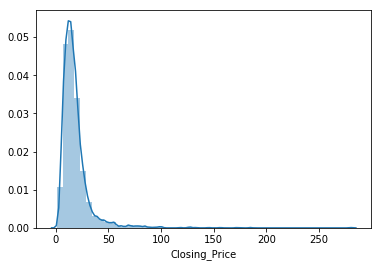

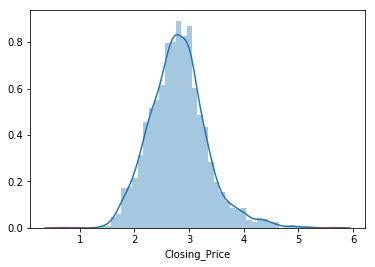

In [41]:
import seaborn as sns

#change the name of the column to avoid name duplicates
for i in range(0,len(ipo_text.columns)):
    ipo_text.rename(columns={str(i): 'text_'+str(i)}, inplace='True')


all_features = pd.concat([ipo.drop('Closing_Price',axis=1),ipo_text.drop(columns=['risks_sentences','risks_words'],axis=1)], axis=1)
target = ipo['Closing_Price']

#print the distribution of the target and the log tranform of the target
sns.distplot(target)
plt.show()
sns.distplot(np.log1p(target))
plt.show()

In [44]:
# Apply the log transform on the target
target = np.log1p(target)
# Separate target and features into test and training and validation sets
seed = 1
X_train, X_test, y_train, y_test = train_test_split(all_features, target, test_size = 0.2, random_state = seed)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = seed)

##### Random Forest Regressor

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

# Define a random forest regressor pipeline
estimators = []
estimators.append(('rf_clf', RandomForestRegressor()))
pipeline = Pipeline(estimators)
pipeline.set_params(rf_clf__random_state = seed)
    
# Finding best value of n_estimators using validation set
scores = []
NSs = []
for NS in [int(i) for i in np.linspace(10, 100, 10)]:
    pipeline.set_params(rf_clf__n_estimators = NS) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict(X_train_val)
    scores.append(r2_score(y_train_val, y_train_pred))
    NSs.append(NS)

best_NS = NSs[scores.index(max(scores))]
print ('best NS = %d with R2 score = %2.4f' %(best_NS, max(scores)))

# Performance of the tuned model on test set
pipeline.set_params(rf_clf__n_estimators = best_NS)
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)

print("R-squared score : " + str(r2_score(y_test, y_pred)))
print("Mean Squared Error : " + str(mean_squared_error(y_test, y_pred)))
print("Median Absolute Error : "+ str(mean_absolute_error(y_test, y_pred)))
print("Median Absolute Error : "+ str( median_absolute_error(y_test, y_pred)))

best NS = 100 with R2 score = 0.8732
R-squared score : 0.8839904791041119
Mean Squared Error : 0.0022737779697331304
Median Absolute Error : 0.03201714347868109
Median Absolute Error : 0.021431962331853627


##### XGB Regressor

In [48]:
from xgboost import XGBRegressor


# Define pipeline
estimators = []
estimators.append(('xgb_clf', XGBRegressor()))
xgb_pipe = Pipeline(estimators)
xgb_pipe.set_params(xgb_clf__n_jobs = -1)
xgb_pipe.set_params(xgb_clf__random_state = seed)

score = 'roc_auc'

# Finding best value of n_estimators using validation set
scores = []
NSs = []
for NS in [int(i) for i in np.linspace(10, 100, 10)]:
    xgb_pipe.set_params(xgb_clf__n_estimators = NS) 
    xgb_pipe.fit(X_train_train,y_train_train)
    y_train_pred = xgb_pipe.predict(X_train_val)
    scores.append(r2_score(y_train_val, y_train_pred))
    NSs.append(NS)

best_NS = NSs[scores.index(max(scores))]
print ('best NS = %d with auc score = %2.4f' %(best_NS, max(scores)))

# Performance of the tuned model on test set
xgb_pipe.set_params(xgb_clf__n_estimators = best_NS)
xgb_pipe.fit(X_train,y_train)
y_pred_gb = xgb_pipe.predict(X_test)

print("R-squared score : " + str(r2_score(y_test, y_pred)))
print("Mean Squared Error : " + str(mean_squared_error(y_test, y_pred)))
print("Median Absolute Error : "+ str(mean_absolute_error(y_test, y_pred)))
print("Median Absolute Error : "+ str( median_absolute_error(y_test, y_pred)))

best NS = 80 with auc score = 0.8980
R-squared score : 0.8839904791041119
Mean Squared Error : 0.0022737779697331304
Median Absolute Error : 0.03201714347868109
Median Absolute Error : 0.021431962331853627


##### Prediction 

In [ ]:
#  get our new train and test sest
X_train = all_features
y_train = target
X_test = pd.concat([ipo_predict.drop('Closing_Price',axis=1),ipo_text_predict.drop('risks_words',axis=1)], axis=1)

# initialize the best model with the best parameters
best_model= XGBRegressor(n_estimators=best_NS)
best_model.fit(X_train,y_train)
prediction = best_model.predict(X_test)

print(shape(prediction))
print(prediction)

In [ ]:
update_final_file('Price_All',prediction)
save_final_file()

## Data

As mentioned earlier, you can find the dataset under project directory in the course git repository under the name of *ipo.xlsx*. The description of each variable can also be found in *variable_description.xlsx*.

## Requirements

We expect your solution for each step to contain the following:

* data preprocessing and feature extraction (can be shared across different steps)
* feature reduction
* train, tune and test different predictive models
* model comparison and arguing about the best model (don't forget mentioning a baseline model)
* predict the labels of the to_predict dataset using your final model
* discussion on possible additional tasks that can be done to boost the performance

## Deliverables

* Predict values from your *best* predictive model for the target variable in Parts 1 to 4 above, and insert those values into the file __*ipo_to_predict.xlsx*__ The fields to be completed by you are: __Price_Change_Non_Textual__ (Part 1), __Price_Change_Textual__ (Part 2), __Price_Change_All__ (Part 3), and __Price_All__ (Part 4).  
  
  
* Deliver a Jupyter notebook with an explanation of your methods, codes and results. Don't forget to divide your notebook into different parts, which clearly shows your solution to the common pre-processing as well as different steps separately. 
    
    

* Submit your final notebook and files into the git repository of the team (we will create that git repo for you).


* Present your results in the final session of the course. Communicate them in a clear and concise manner. The goal is to learn how to present your results to stakeholders at the right level of detail. **We will discuss this more in classe**. 

## Tips

* Take some time at the start of the project to educate yourslef about the IPO process. We privde you wiht two main texts in the class repository under *resources* folder. Understanding how variables relate to the target outcomes will help you to construct new measures from the tabularized data and/or selecting or eliminating features that relate to the target variable.  


* Present your results as a story - this is very important!   
  

* Document all of your assumptions (e.g. evaluation metric, hyper-parameter values, ...).  


* Make sure your code will run and results are reproducible (fix random seeds, etc.).  


*  Comment your blocks of code (and lines of code if needed) and anything in your story/logic that might not be obvious by looking at your code.    


* To speed up experimentation, you might use a small sample of the original dataset to do your initial coding. Also try to use all possible cores for computation, by setting the option of n_jobs = -1, when needed. 


* Try to be creative to improve your predictions, but don't forget that it is also important to explain your line of thinking/reasoning.


* Your final grade is based on the whole process of doing the project and not just based on your results on the unseen data. 

## Grading

Grading of the project (apart from presentation), is based on the following components:
    
    20 %  Documentation and organization of your notebook
    15 %  Quality and commenting of code
    10 %  Pre-processing
    15 %  Part 1
    15 %  Part 2
    10 %  Part 3
    15 %  Part 4
    
     5%   Bonus Contest


## Bonus Contest

As an optional bonus contest at the end of the project, we will award an extra 5% of the total project grade to the team that comes up with the "best" strategy for investing into IPOs based on your estimated model(s). Specifically, assume you have USD 1,000,000 to invest into the IPO stocks that appear in the "unseen" file __*ipo_to_predict.xlsx*__. In the column "Your_Bet", allocate some portion of that USD 1,000,000 to each of the stocks listed in the unseen file. The total allocation must sum to $1,000,000. The top team making the most money (once outcomes are revealed at time of grading) will earn the 5% bonus. 